Looking for flares in all the STIS data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from matplotlib import cm
from scipy import interpolate
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
import matplotlib.patches as mpatches
from astropy.modeling import models, fitting
from astropy.units import cds
cds.enable()

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/'

In [4]:
tags = glob.glob('{}*tag.fits'.format(path))

In [5]:
g140ms = []
g140m_stars = []
e140ms = []
e140m_stars = []
g140ls = []
g140l_stars = []
g230ls = []
g230l_stars = []
for tag in tags:
    grating = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating == 'E140M':
        e140ms.append(tag)
        e140m_stars.append(star)
    elif grating == 'G140M':
        g140ms.append(tag)
        g140m_stars.append(star)
    elif grating == 'G140L':
        g140ls.append(tag)
        g140l_stars.append(star)
    elif grating == 'G230L':
        g230ls.append(tag)
        g230l_stars.append(star)
        
    else:
        print ('Unknown grating: {}'.format(grating))

g140m_stars = np.unique(g140m_stars)
g140l_stars = np.unique(g140l_stars)
e140m_stars = np.unique(e140m_stars)


In [6]:
outpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/'

In [7]:
import stistools


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [8]:
t_bin = 20 #in seconds
grating = 'g140l'

use_tags = []
stars = []

for tag in tags:
    grating_i = fits.getheader(tag, 0)['OPT_ELEM']
    star = fits.getheader(tag, 0)['TARGNAME']
    if grating_i.lower() == grating:
        use_tags.append(tag)
        stars.append(star)

stars = np.unique(stars)
print(stars)

['GJ649' 'GJ674' 'GJ676A' 'GJ699' 'LHS-2686']


In [9]:

for tag in use_tags:
    print(tag)
    rootname = fits.getheader(tag)['ROOTNAME'] #find the rootname of the tagfile to name the output file
    exptime = fits.getheader(tag)['TEXPTIME']
    n_bins = int(exptime/t_bin) #use the exposure time to tell inttag how many time bins there will be
    print('n_bins = {}'.format(n_bins) )
    outfile = '{}{}/{}_{}s_raw.fits'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    if os.path.exists(outfile) == False:
        # os.remove(outfile)
        stistools.inttag.inttag(tag, outfile, rcount = n_bins, increment = t_bin, verbose=False) #change verbose to true to diagnose problems

/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm04010_tag.fits
n_bins = 79
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm04030_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm04040_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm12050_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm12060_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm12070_tag.fits
n_bins = 46
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm21050_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm21060_tag.fits
n_bins = 137
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm22010_tag.fits
n_bins = 78
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/odlm22020_tag.fits
n_bins = 136
/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/data/o

In [10]:
os.environ['oref'] = path 

In [11]:
raws = glob.glob('{}{}/*raw.fits'.format(outpath, grating))
raws

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04010_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04040_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12070_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21060_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22020_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22030_20s_raw.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm34050_20s_raw.fits',
 '/media/david/2tb_ext_hd/hdda

In [12]:
for raw in raws:
    rootname = fits.getheader(raw)['ROOTNAME'] 
    outname = '{}{}/{}_{}s'.format(outpath, grating, rootname, t_bin) #build the file path and file name of the output
    # if os.path.exists(outname):
    #     os.remove(outname)
    if os.path.exists(outname) == False:
        
        stistools.calstis.calstis(raw, outroot = outname, wavecal='{}{}_wav.fits'.format(path, rootname), trailer='trls/{}_{}s_extract.trl'.format(rootname,t_bin))

In [13]:
new_x1ds = glob.glob('{}{}/*{}s*x1d.fits'.format(outpath, grating, t_bin))
new_x1ds

['/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04010_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04030_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm04040_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm12070_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21050_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm21060_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22010_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/output/g140l/odlm22020_20s_x1d.fits',
 '/media/david/2tb_ext_hd/hdda

odlm04010


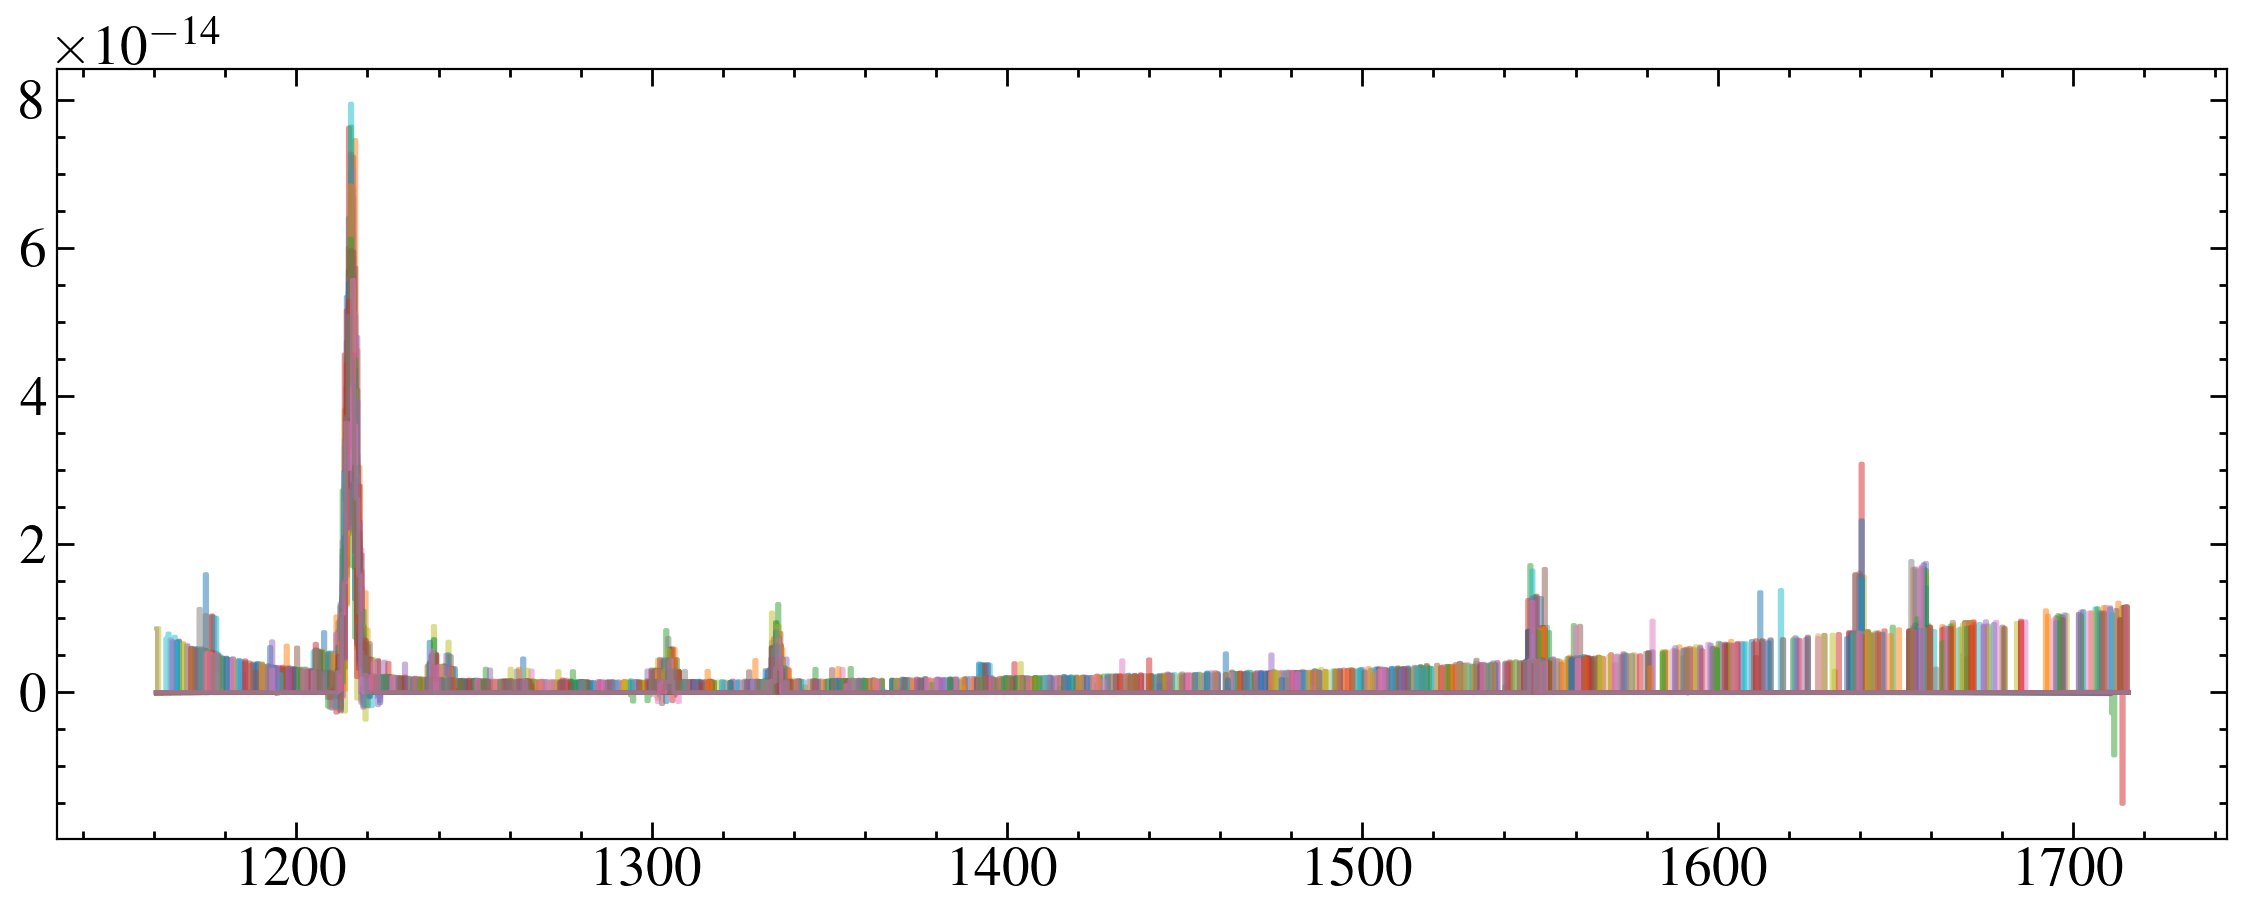

odlm04030


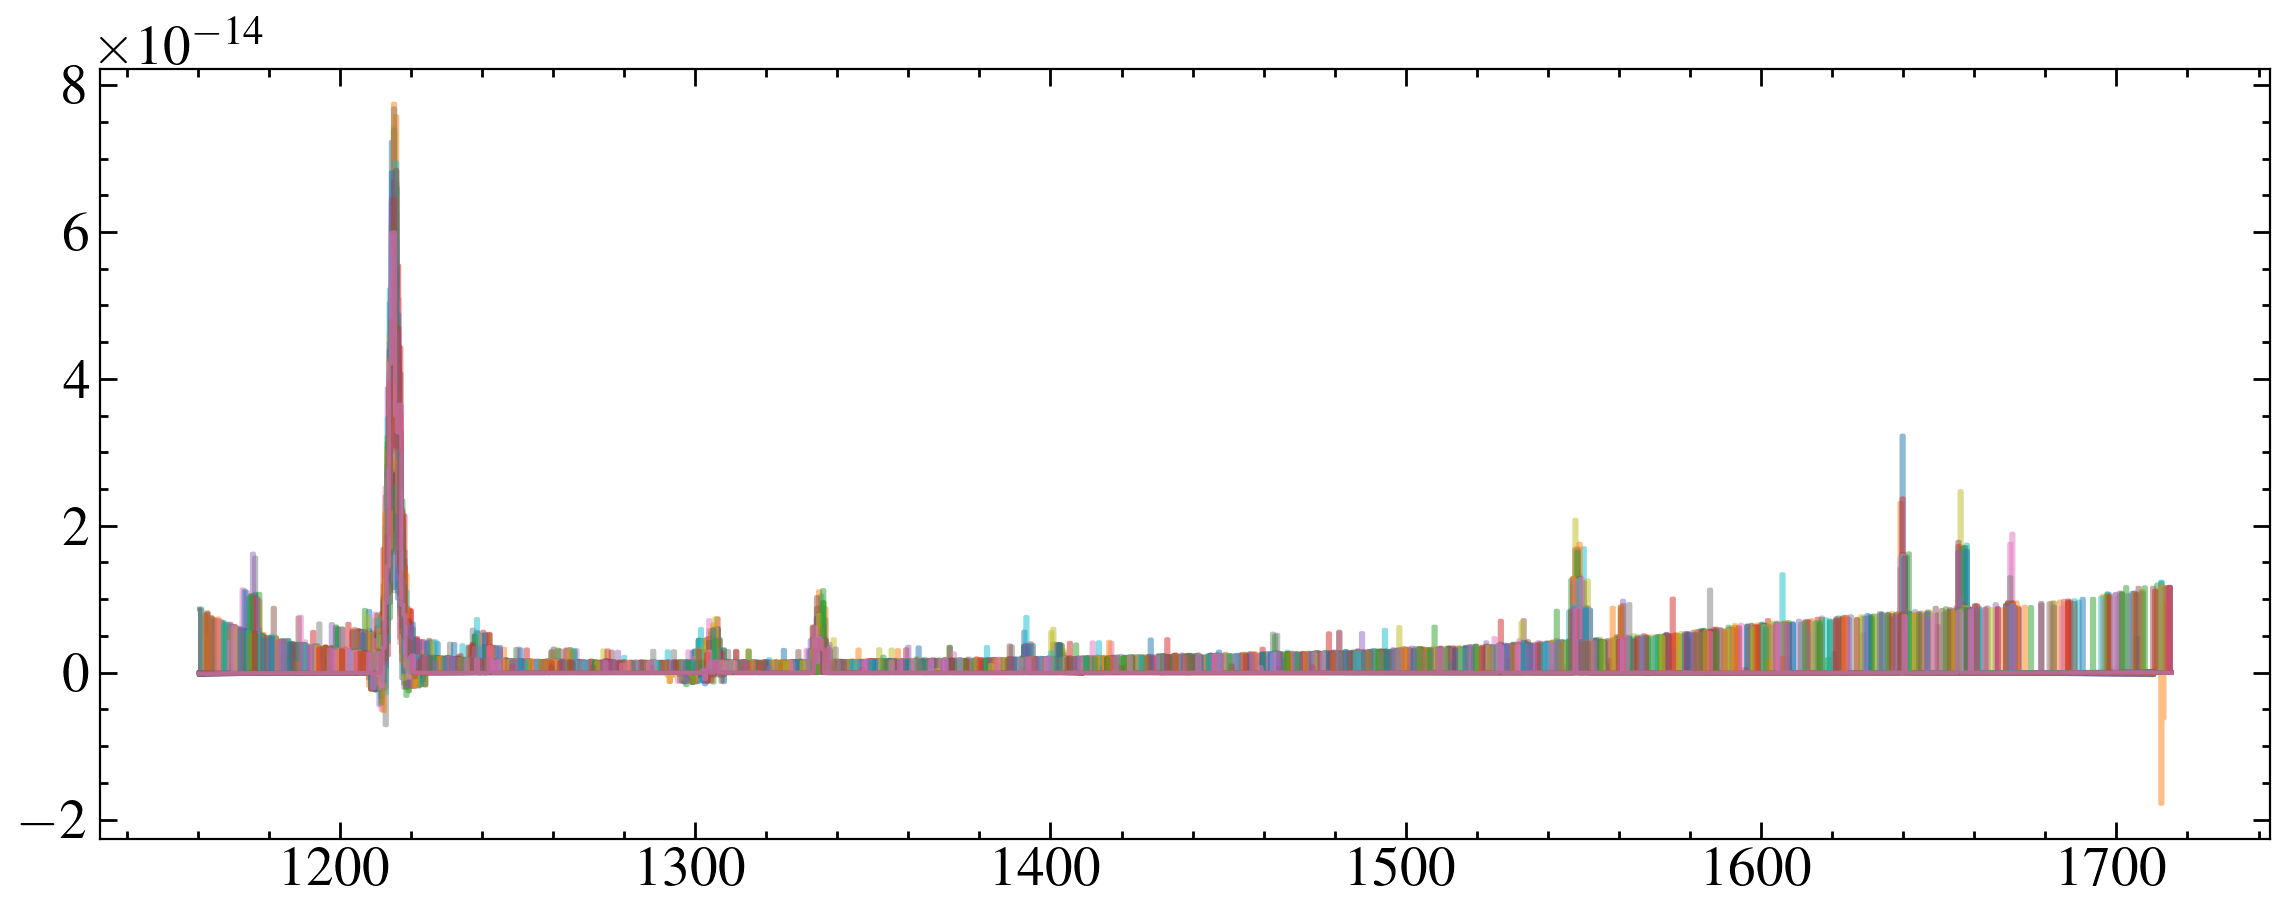

odlm04040


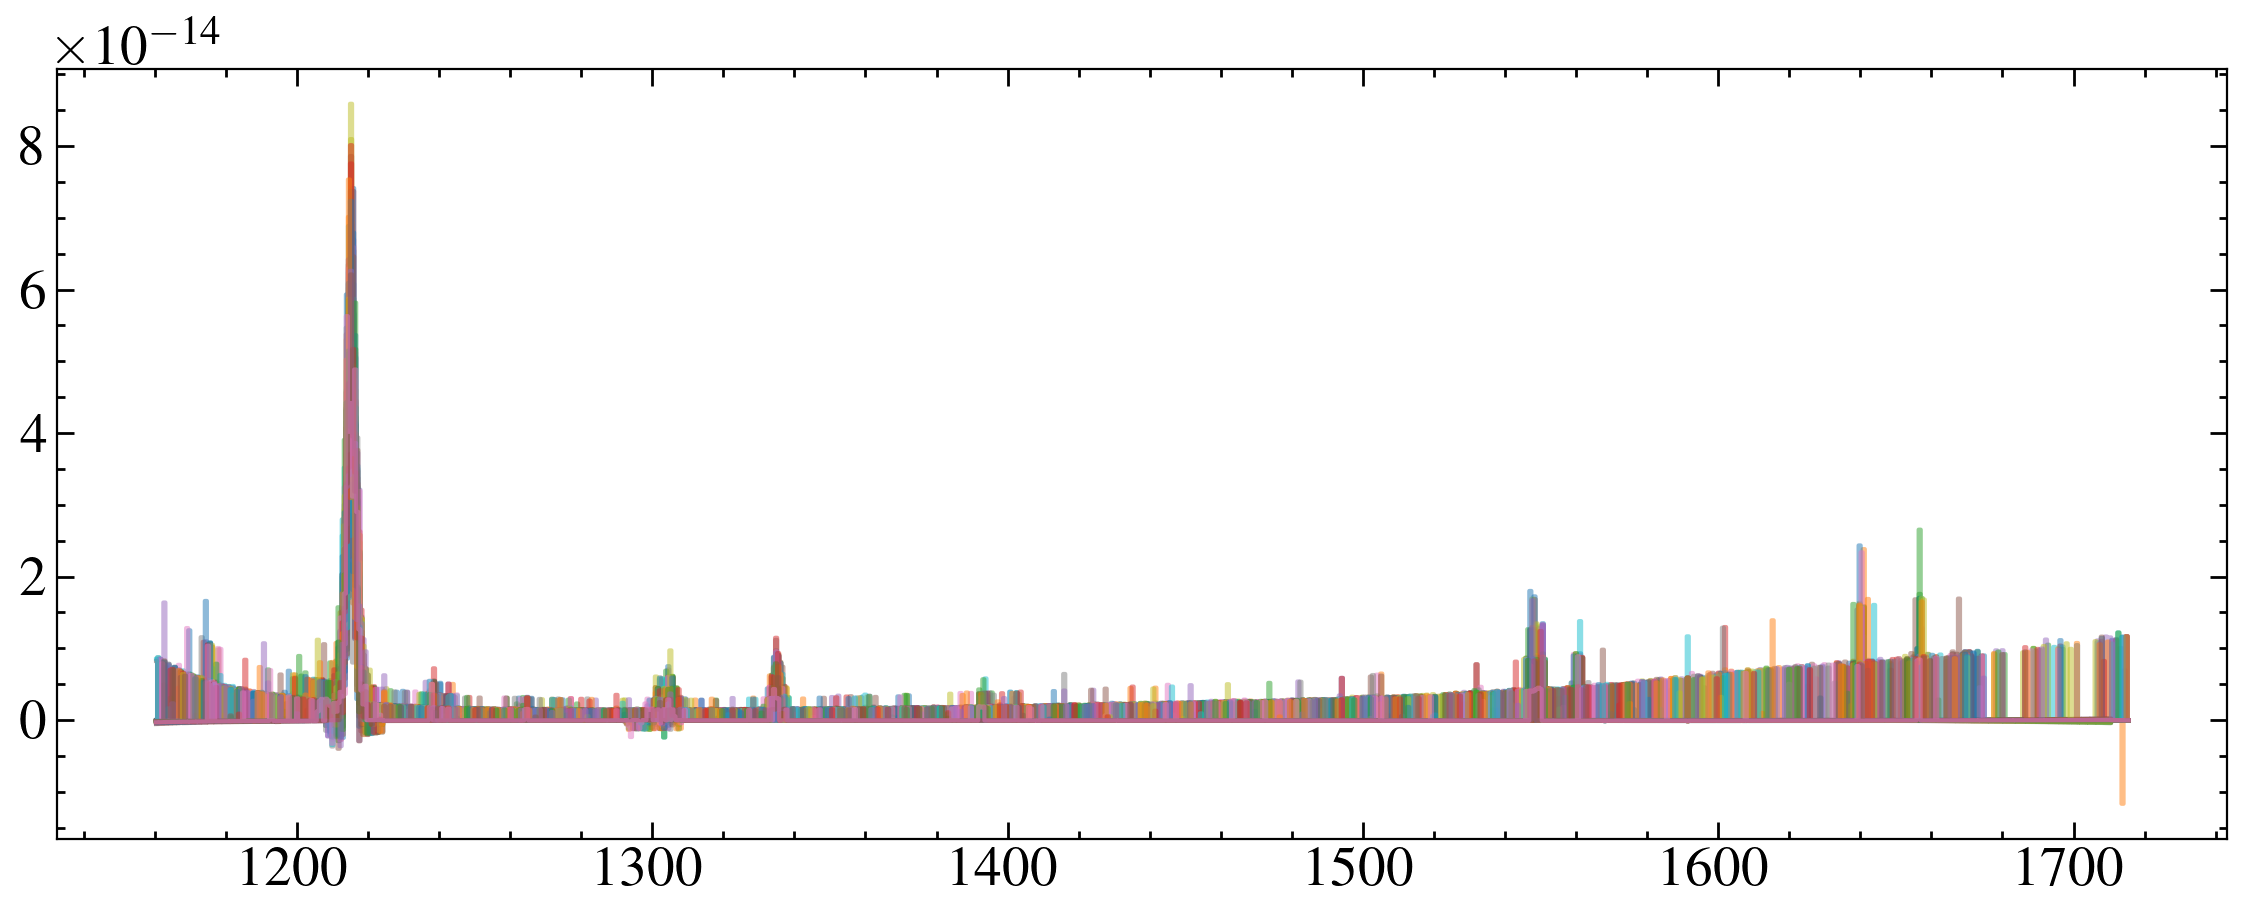

odlm12050


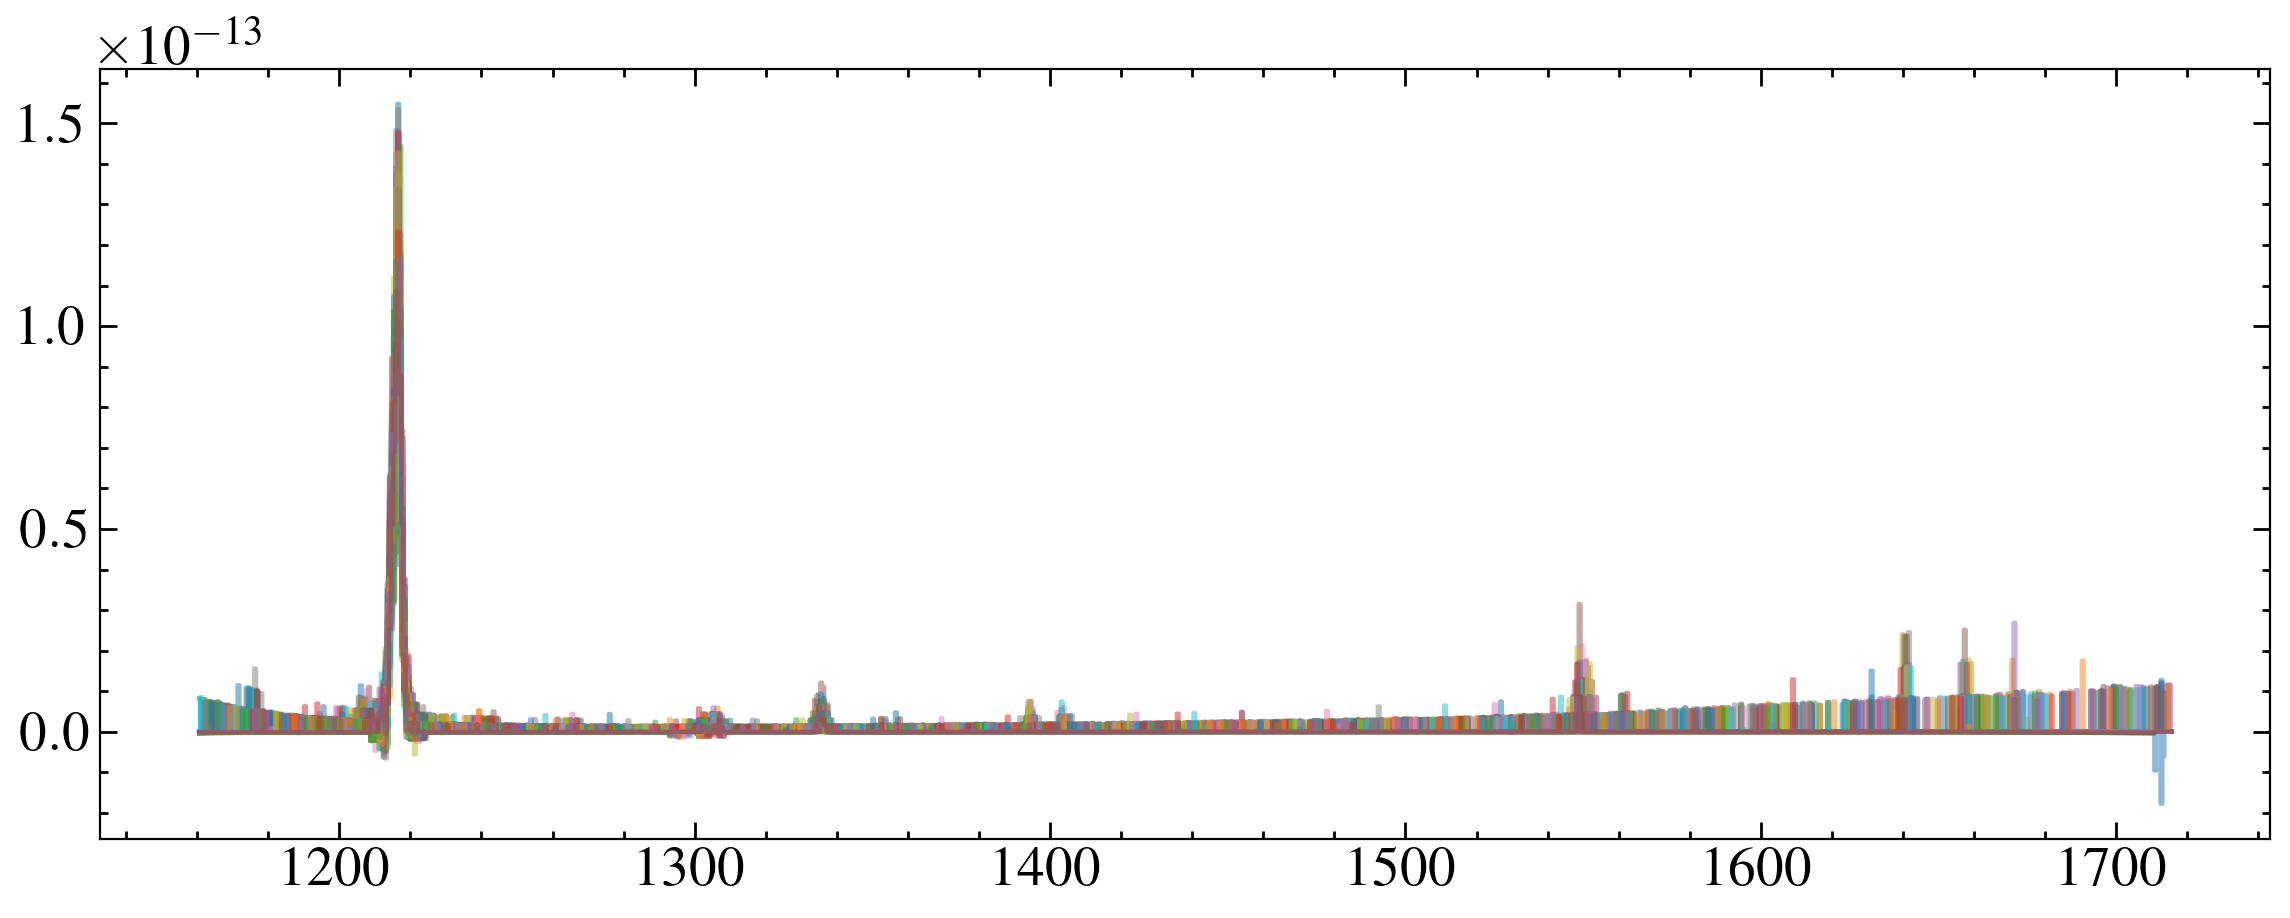

odlm12060


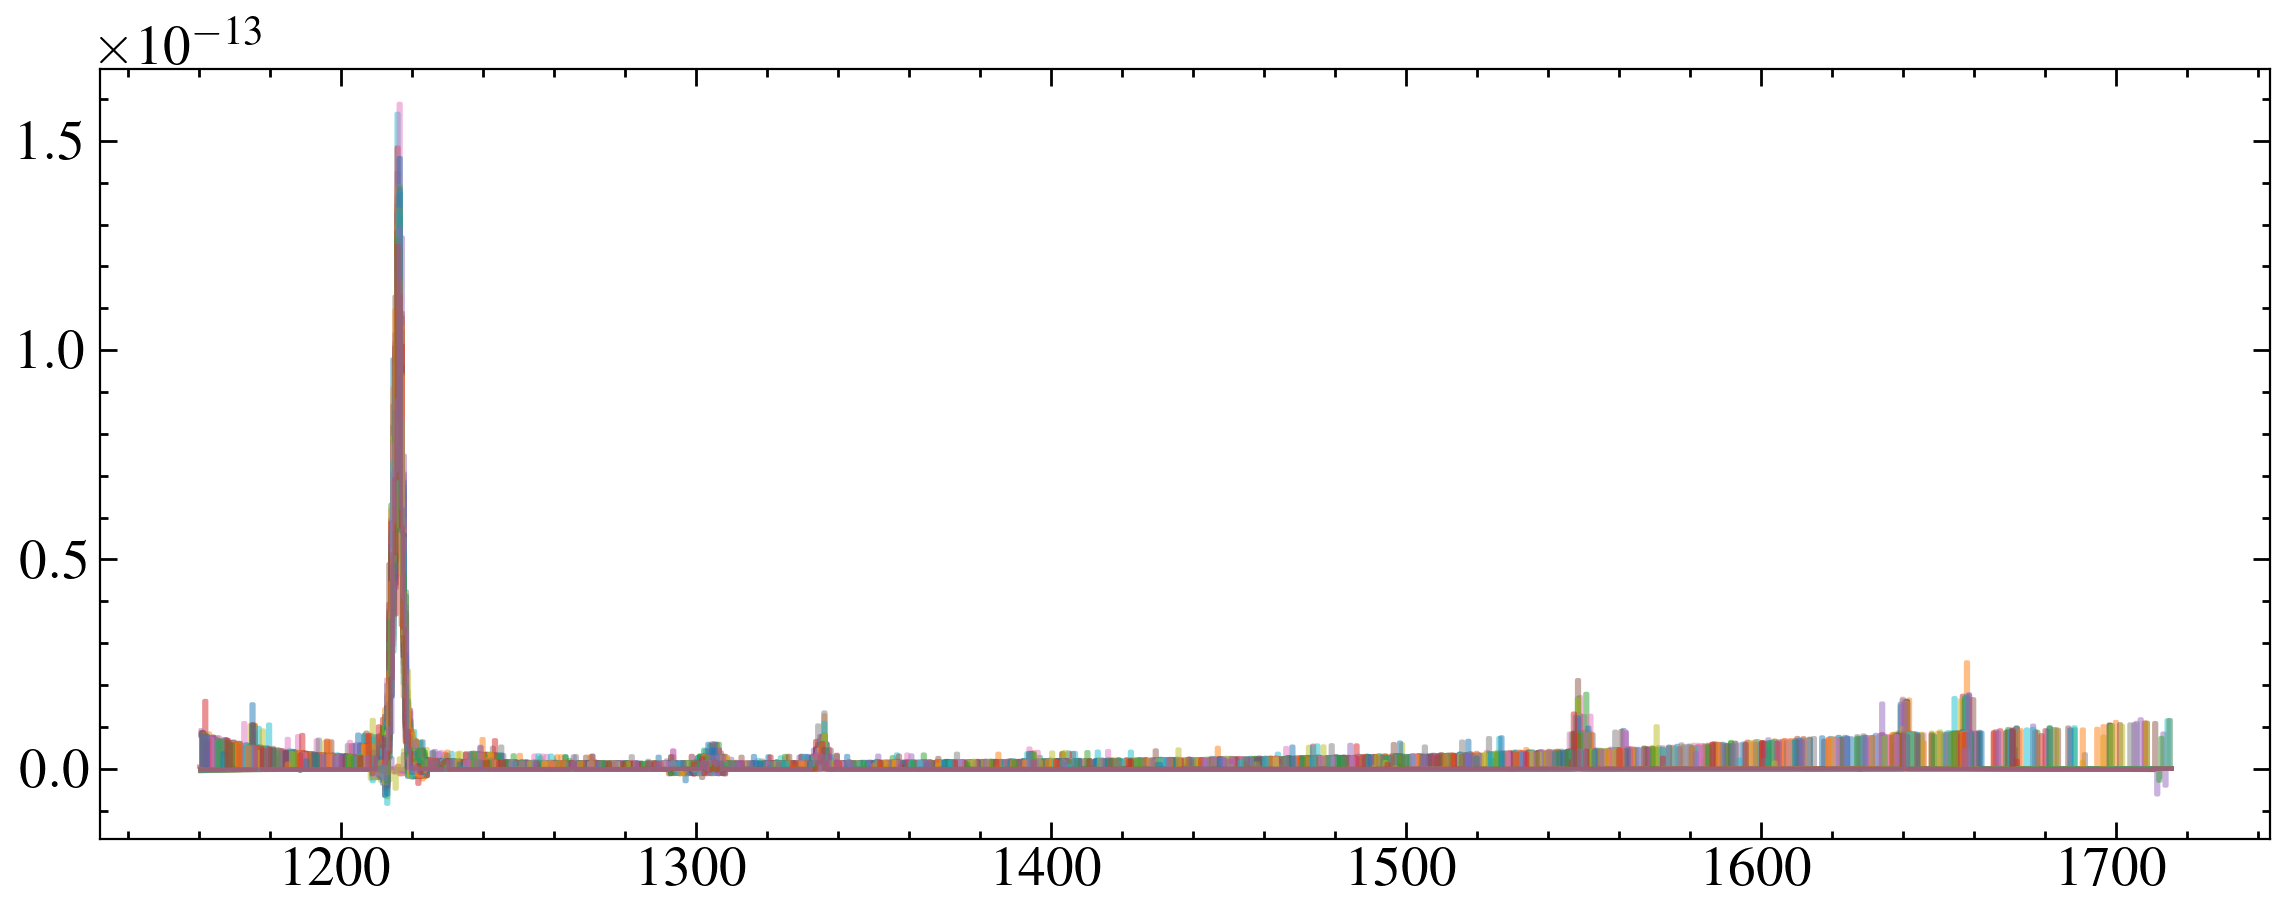

odlm12070


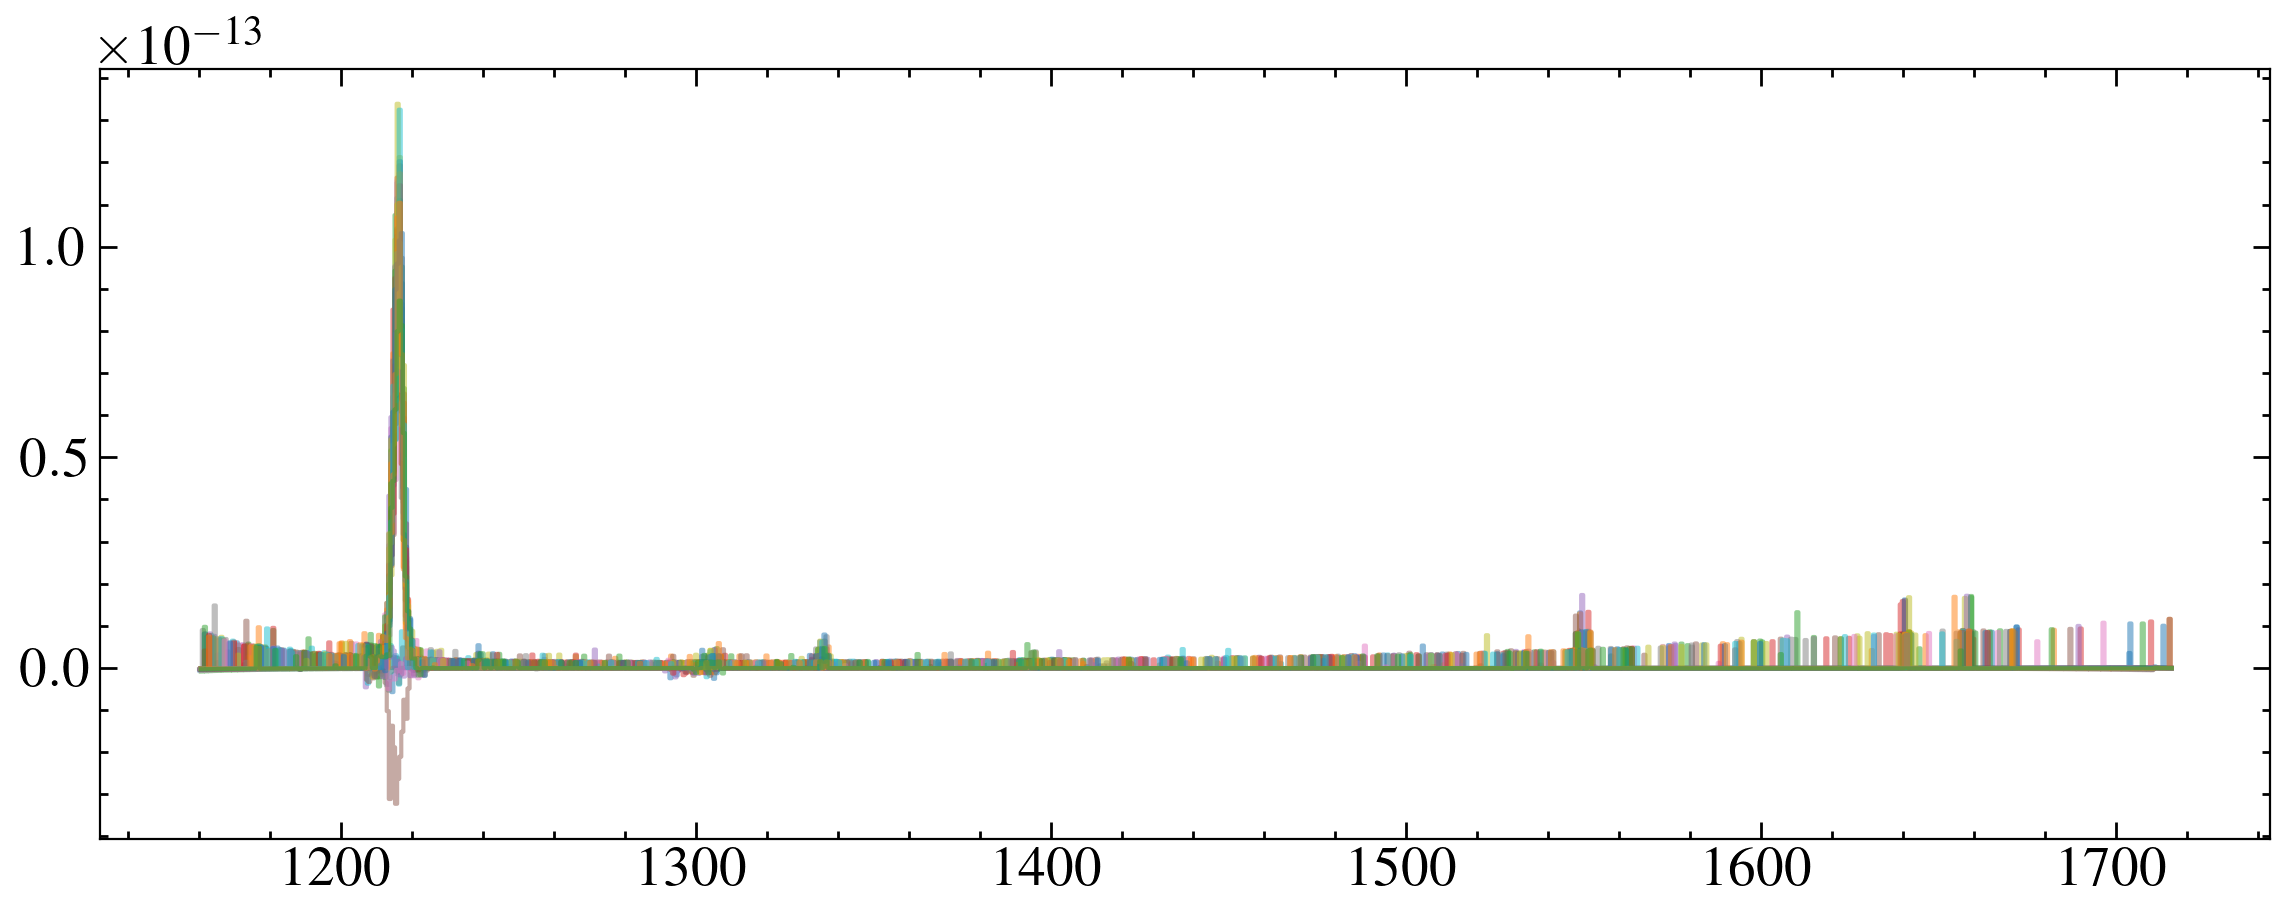

odlm21050


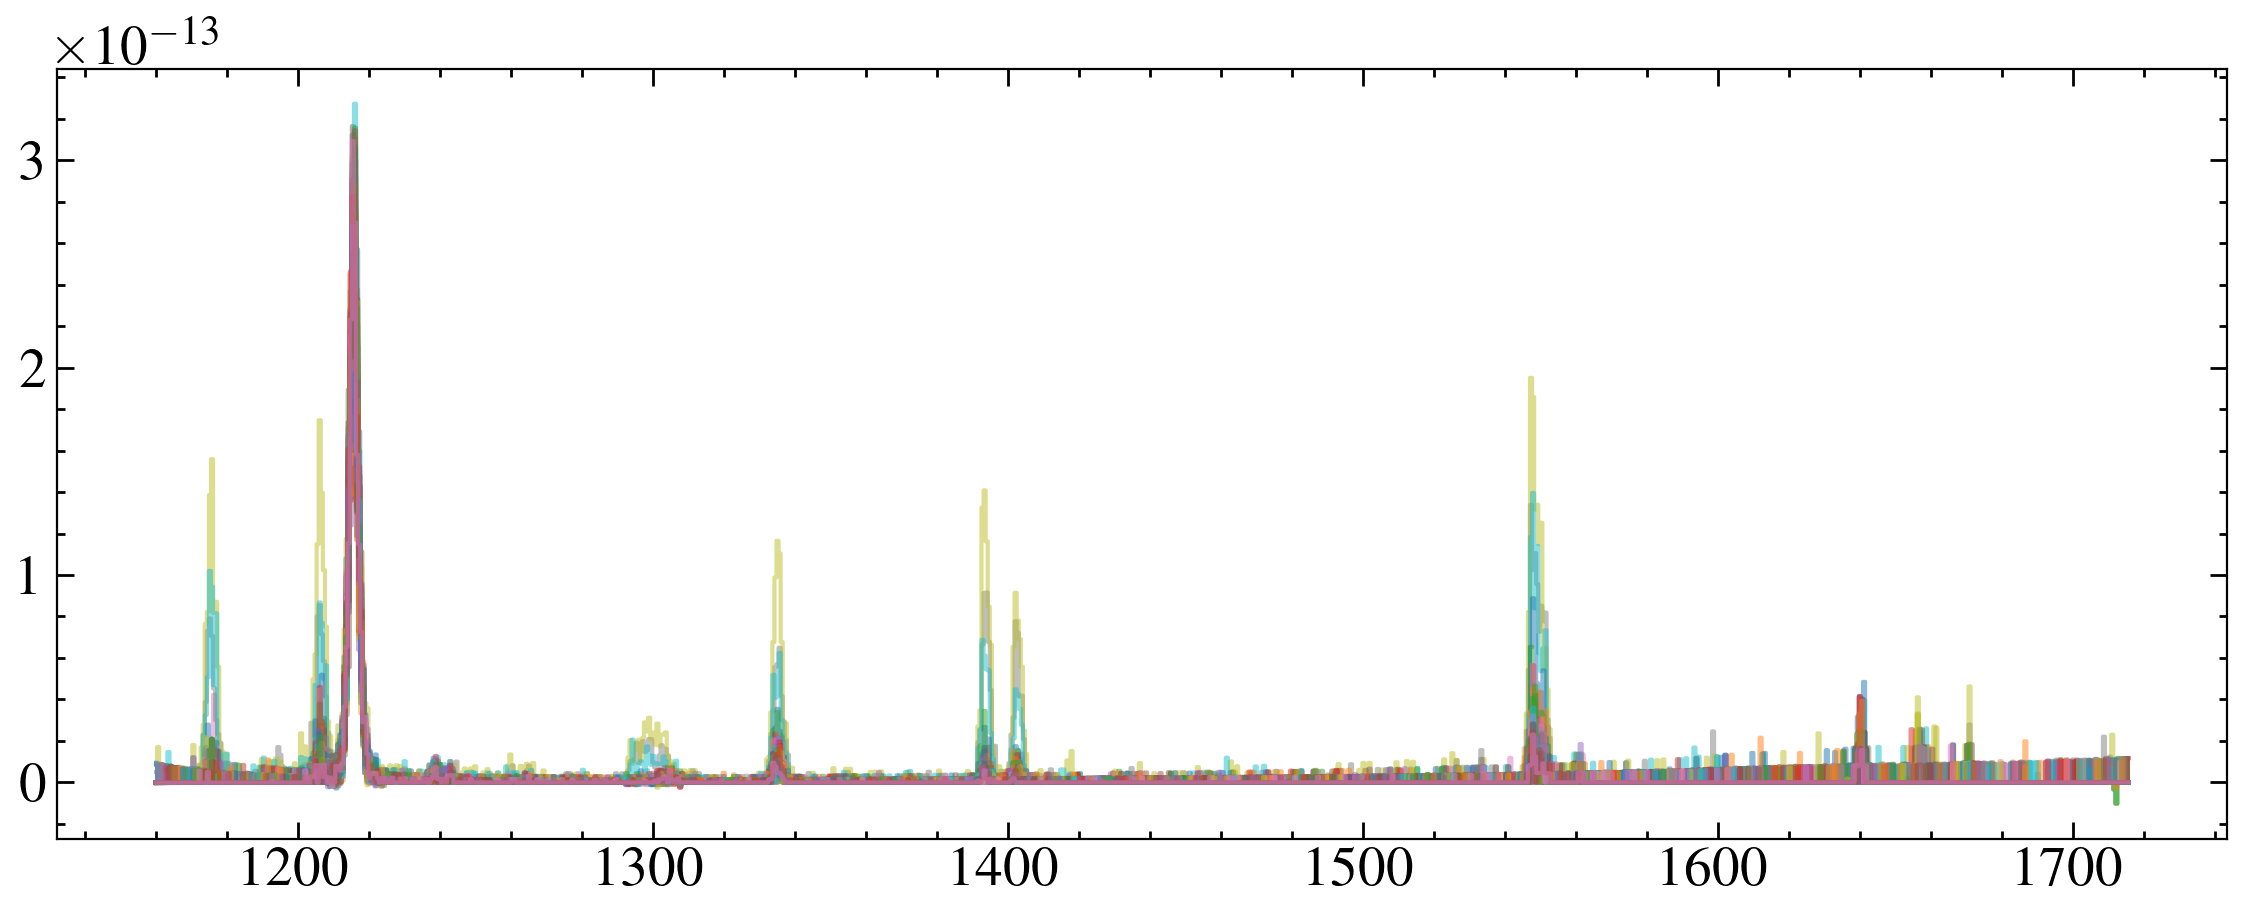

odlm21060


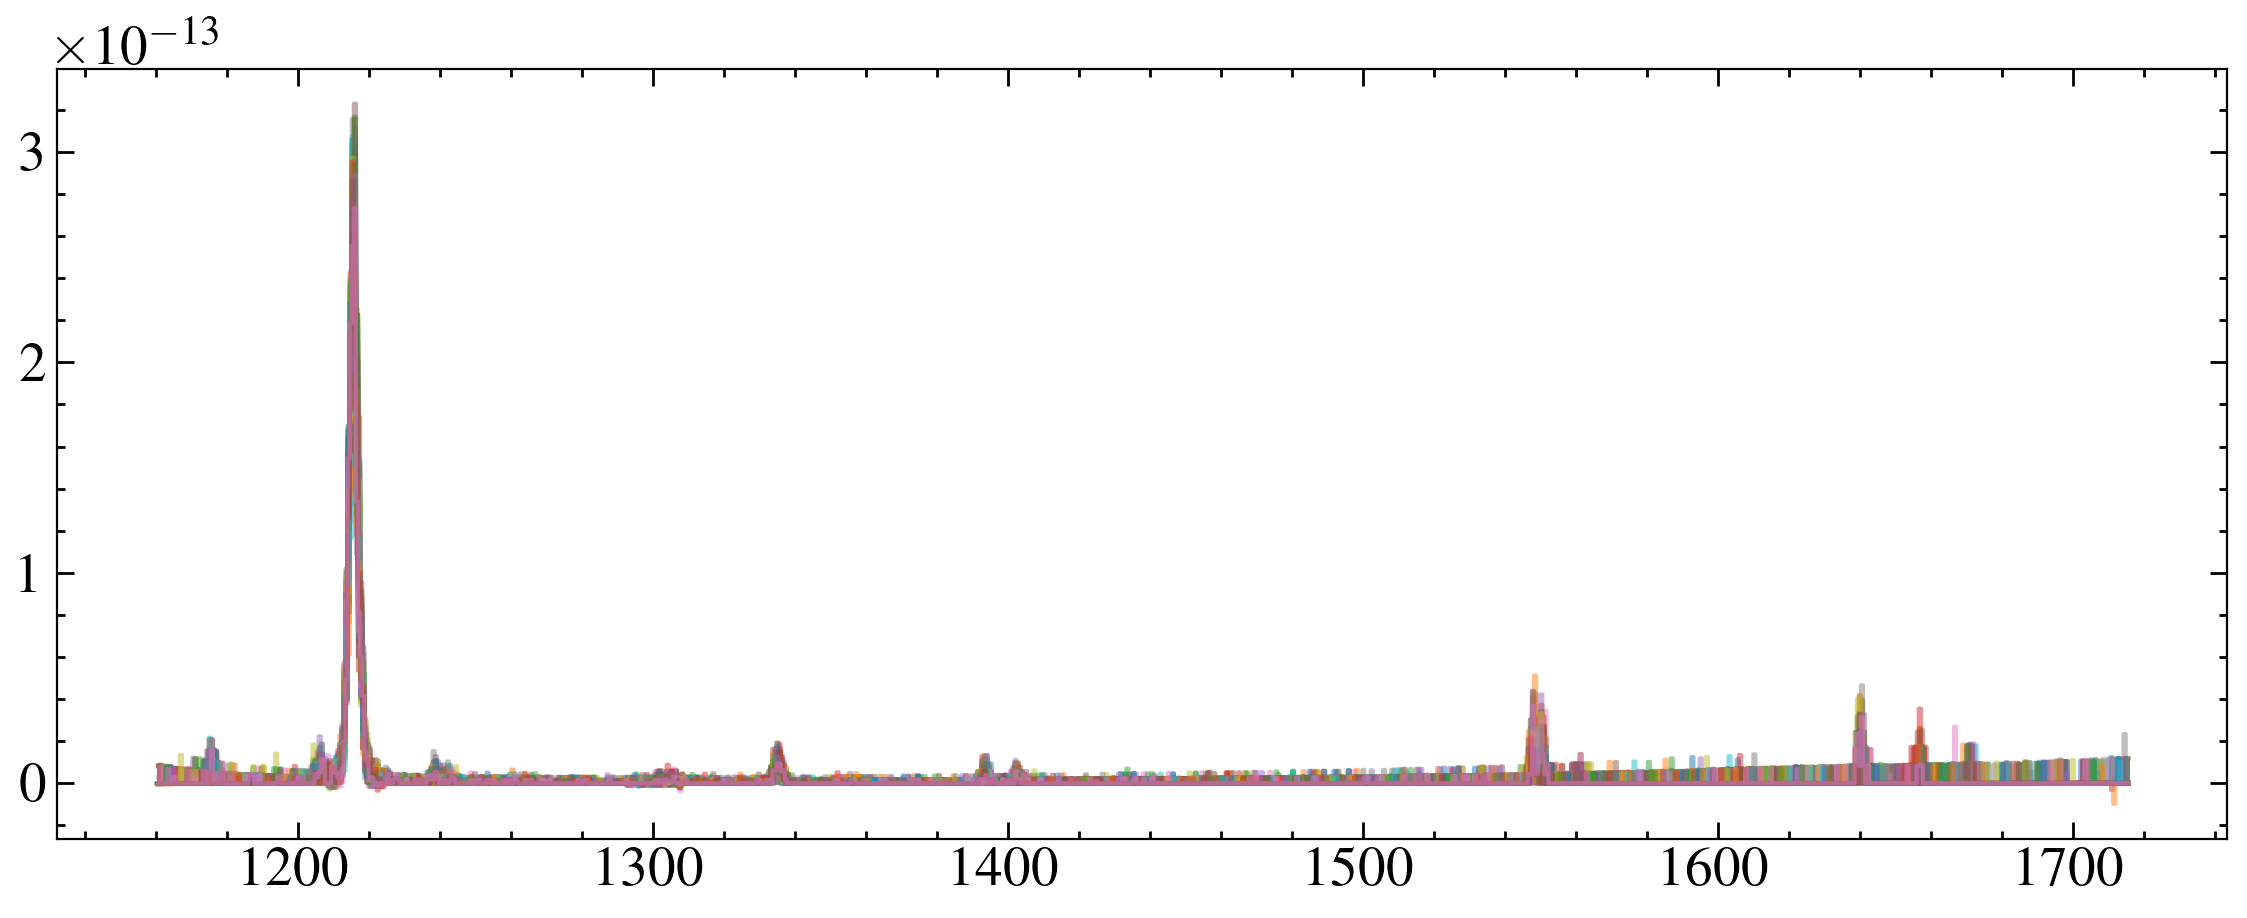

odlm22010


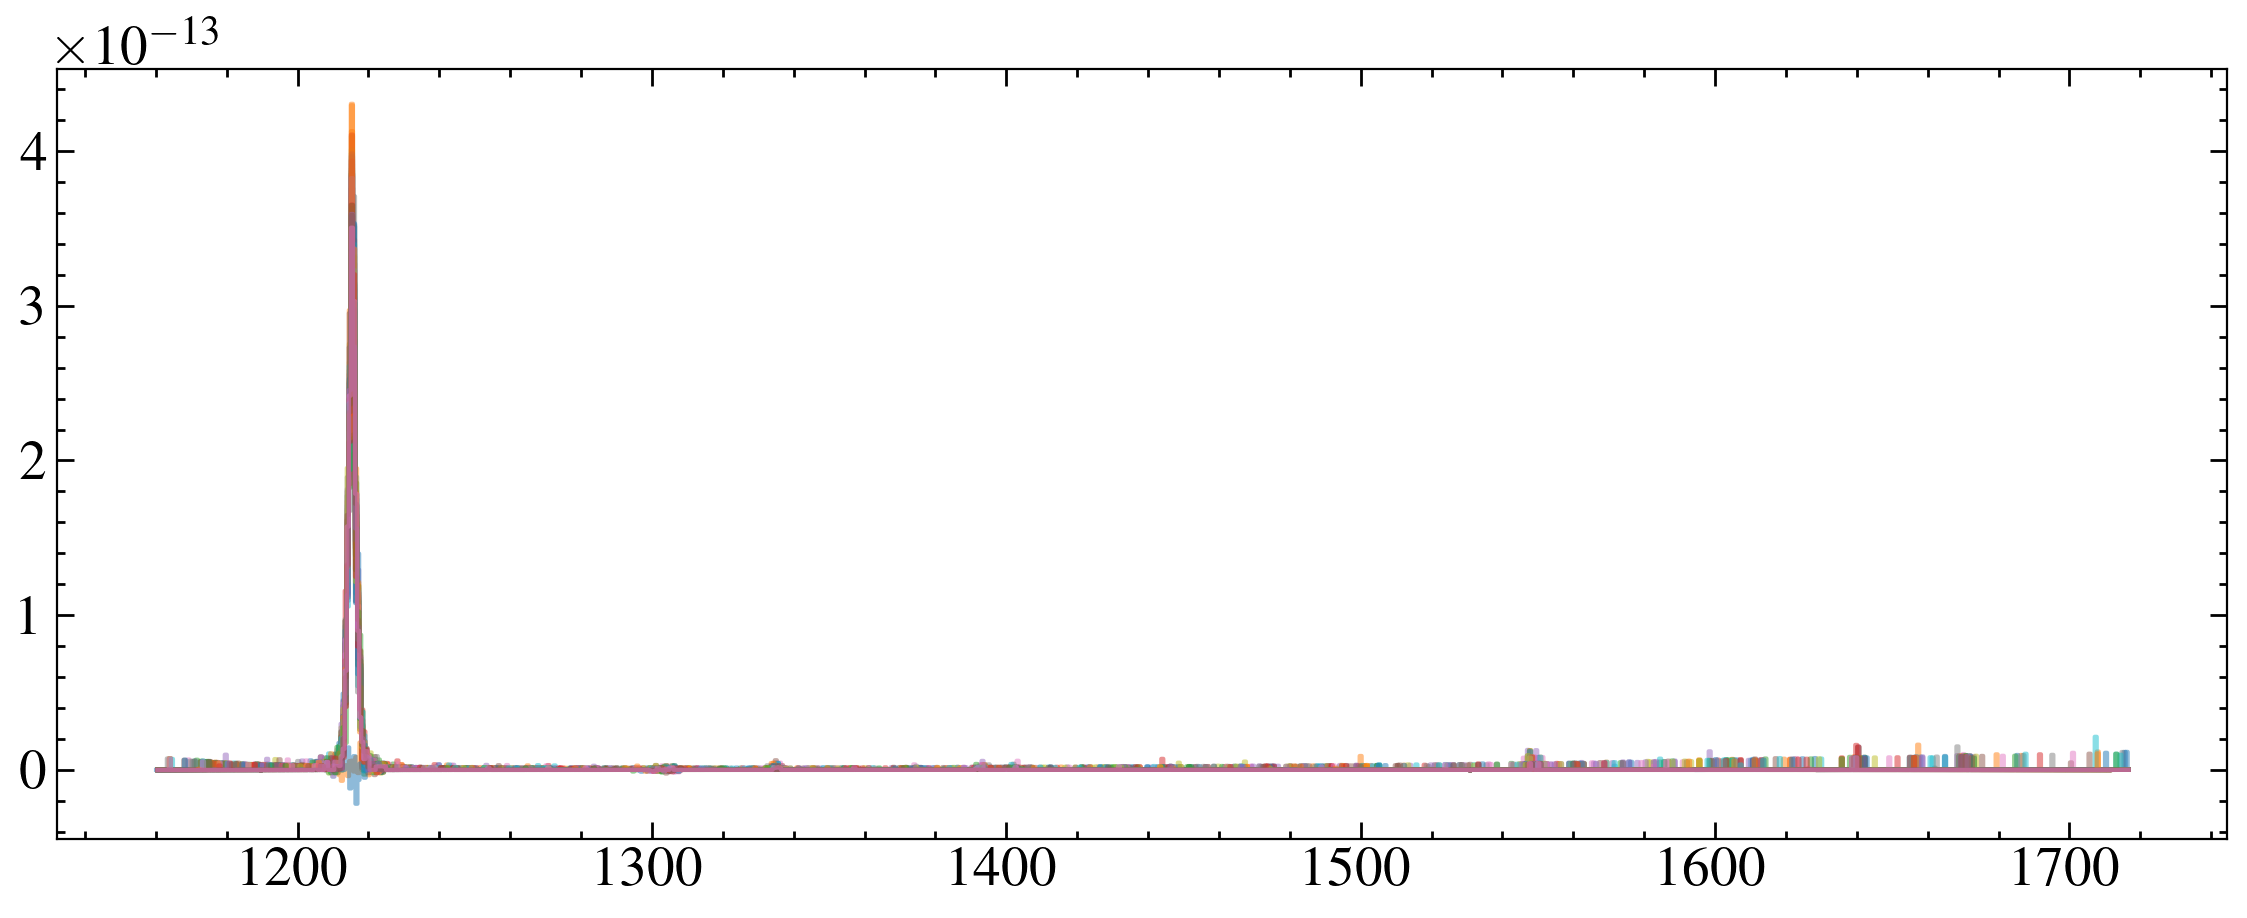

odlm22020


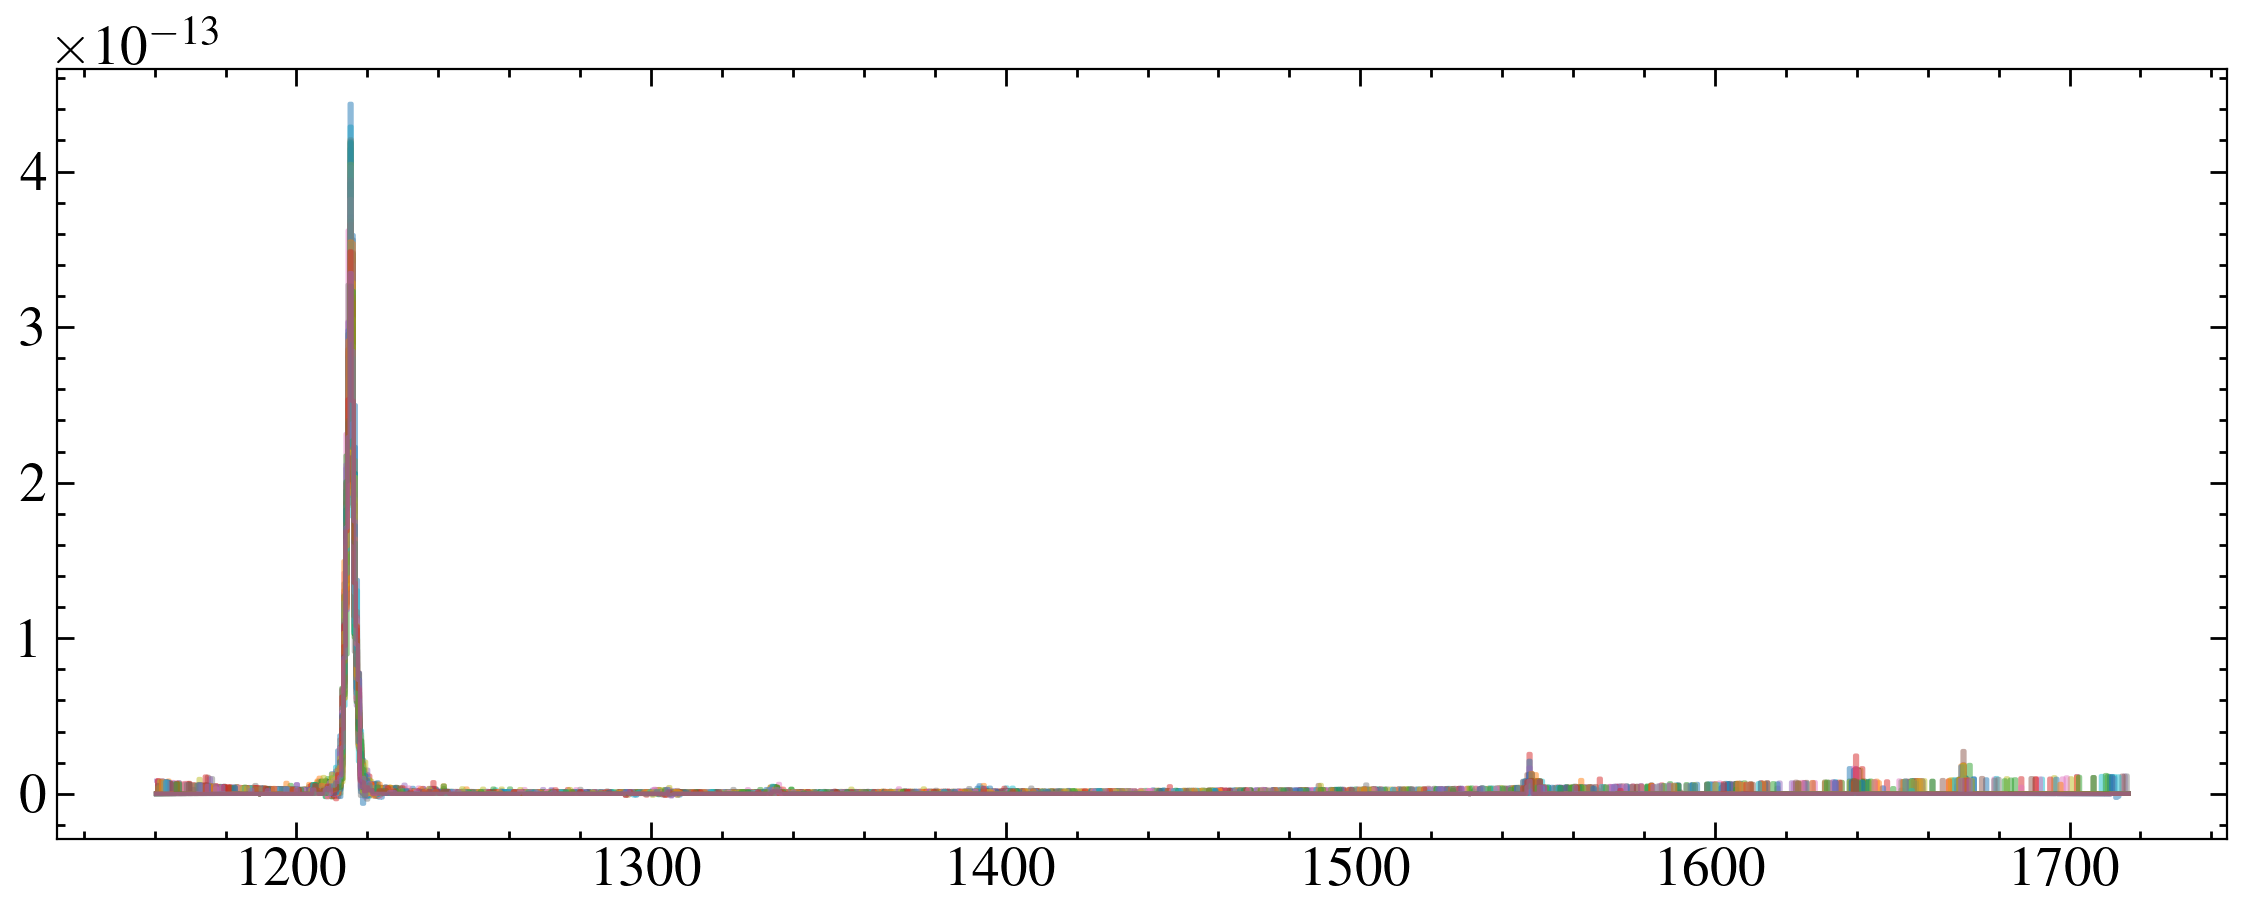

odlm22030


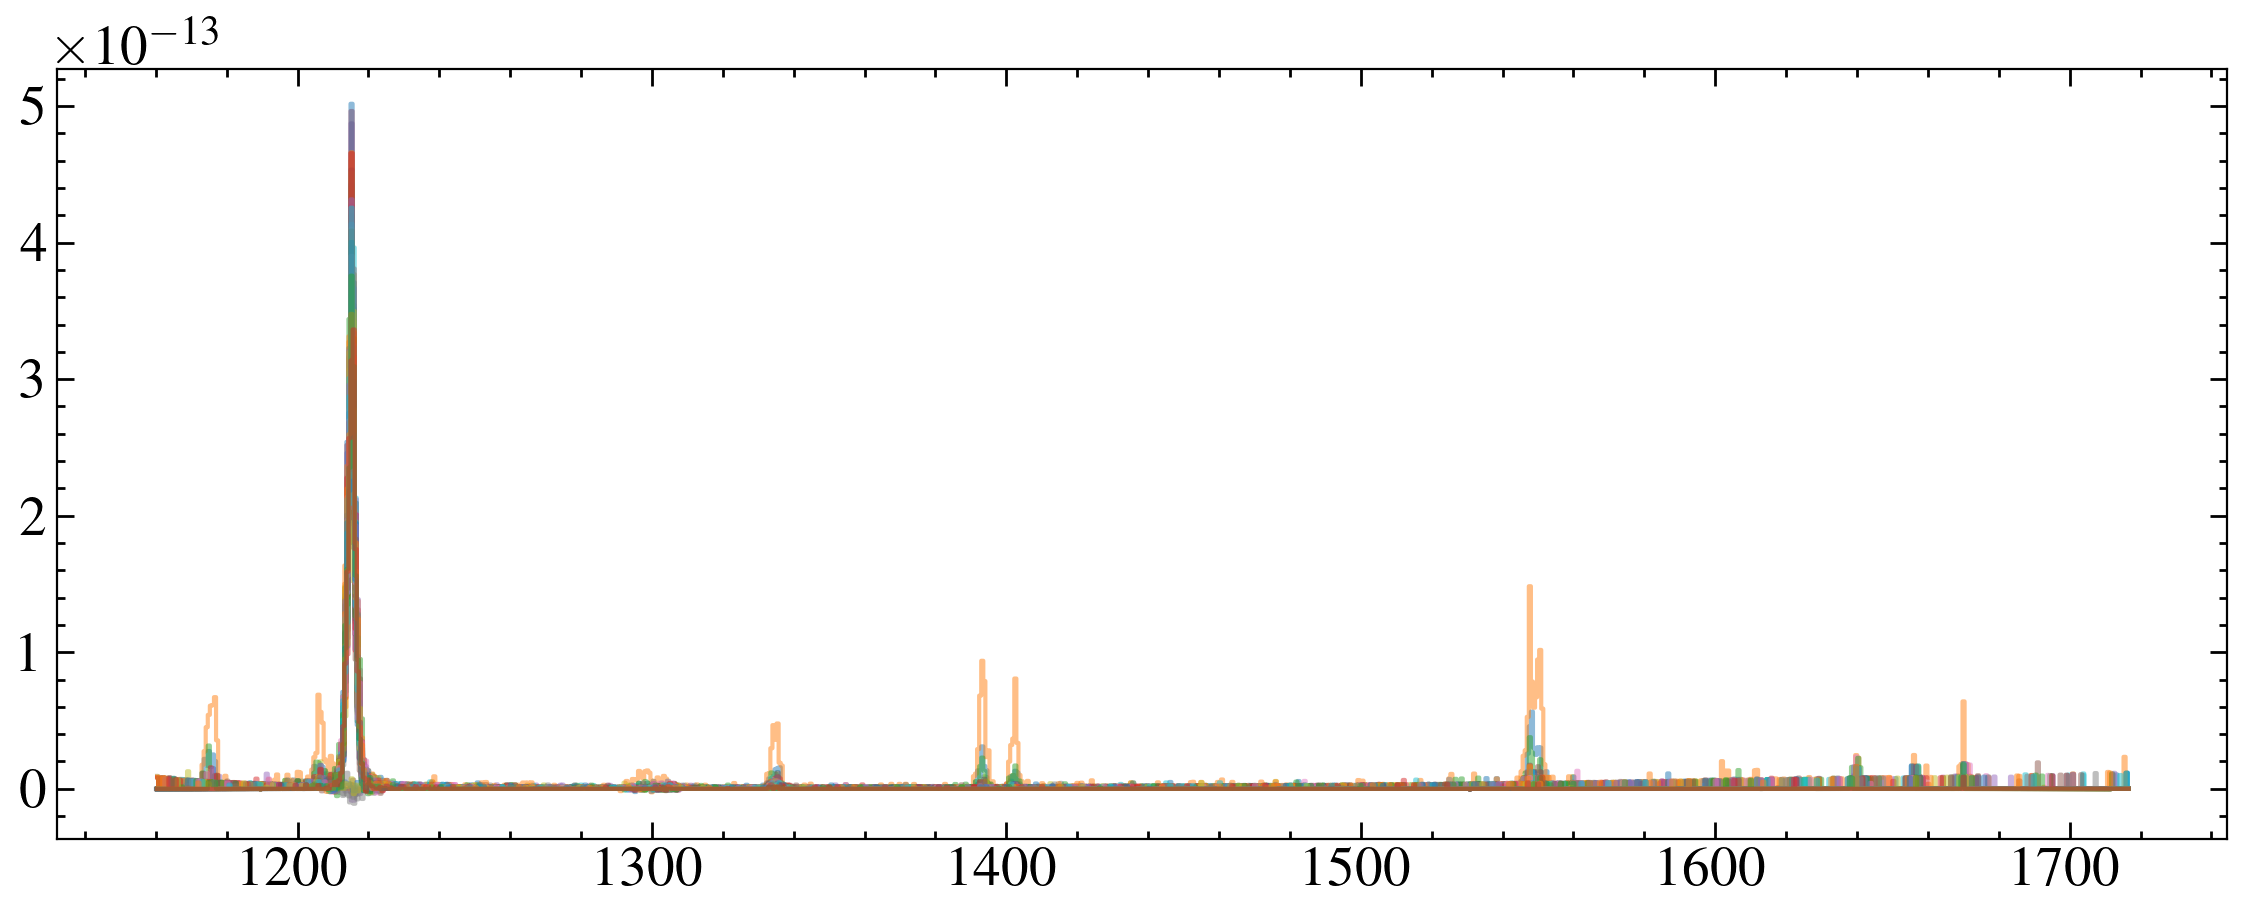

odlm34050


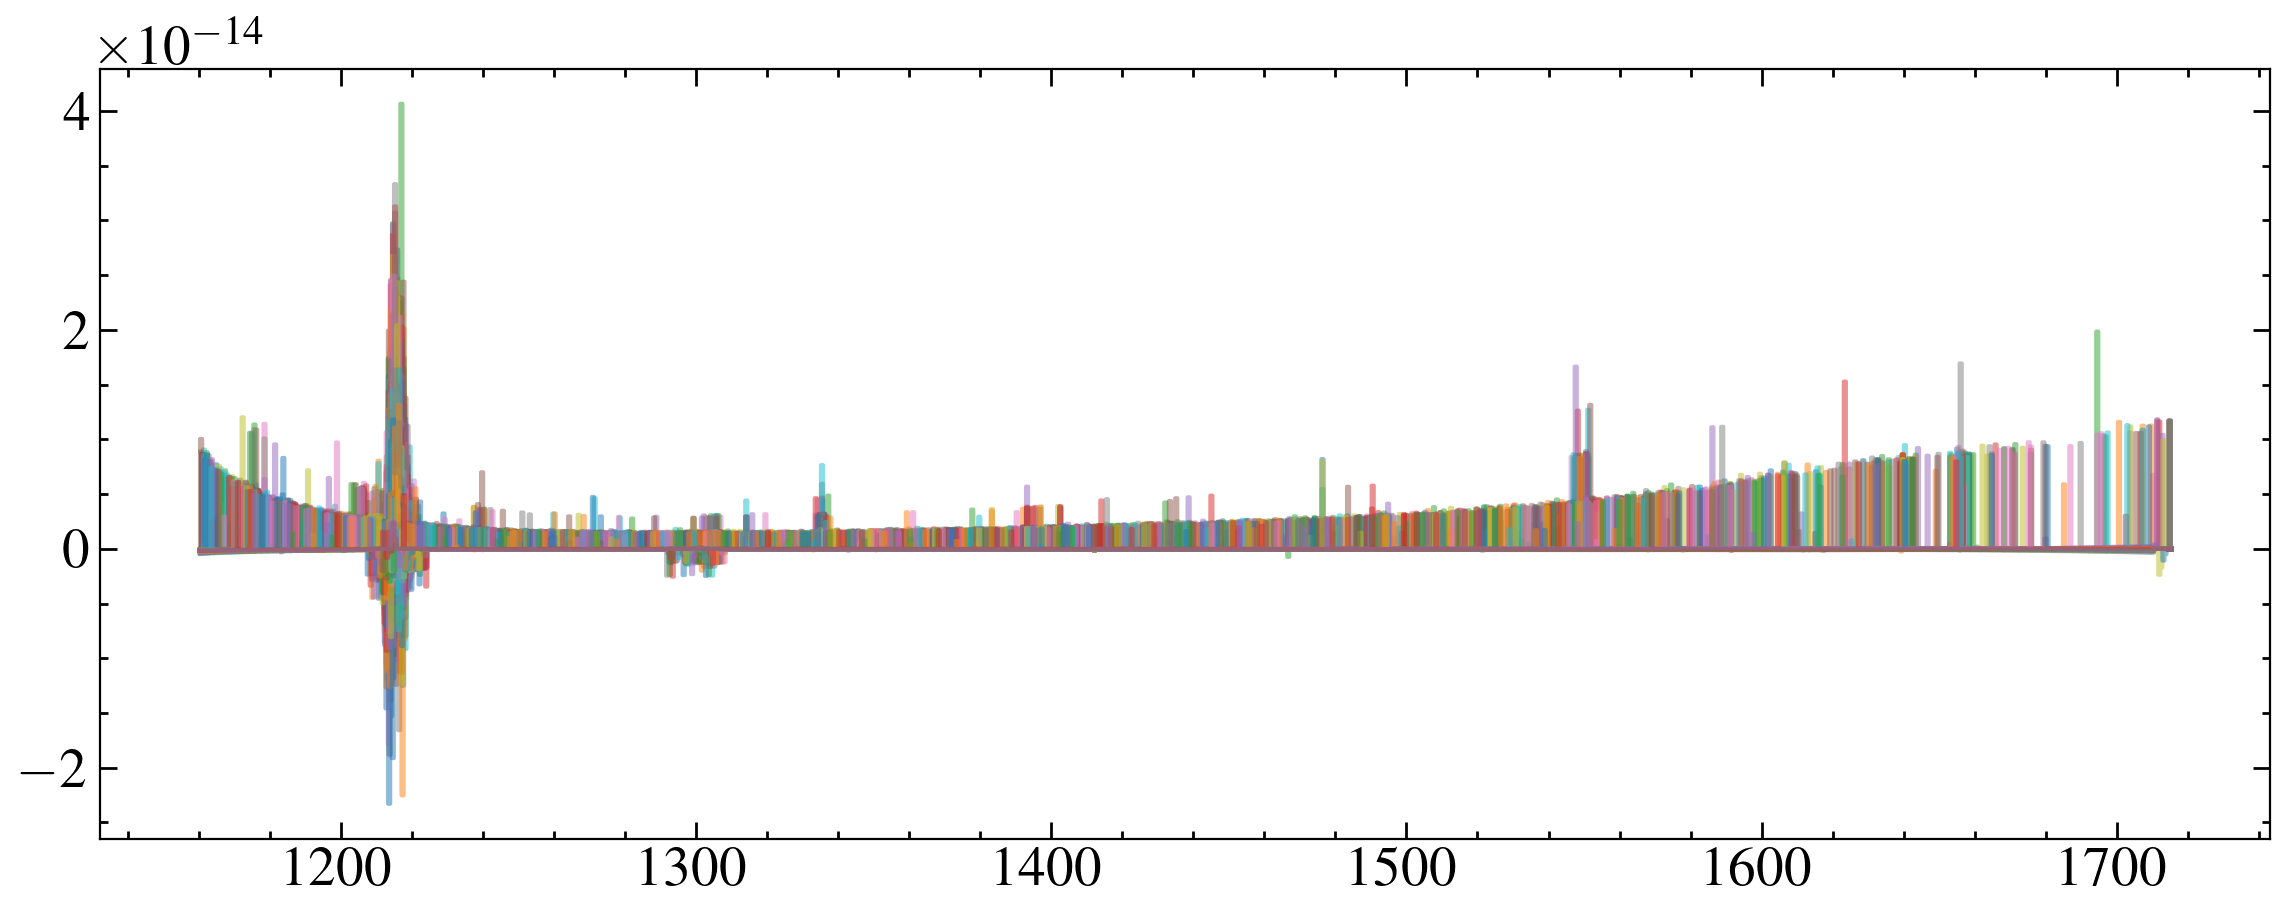

odlm34060


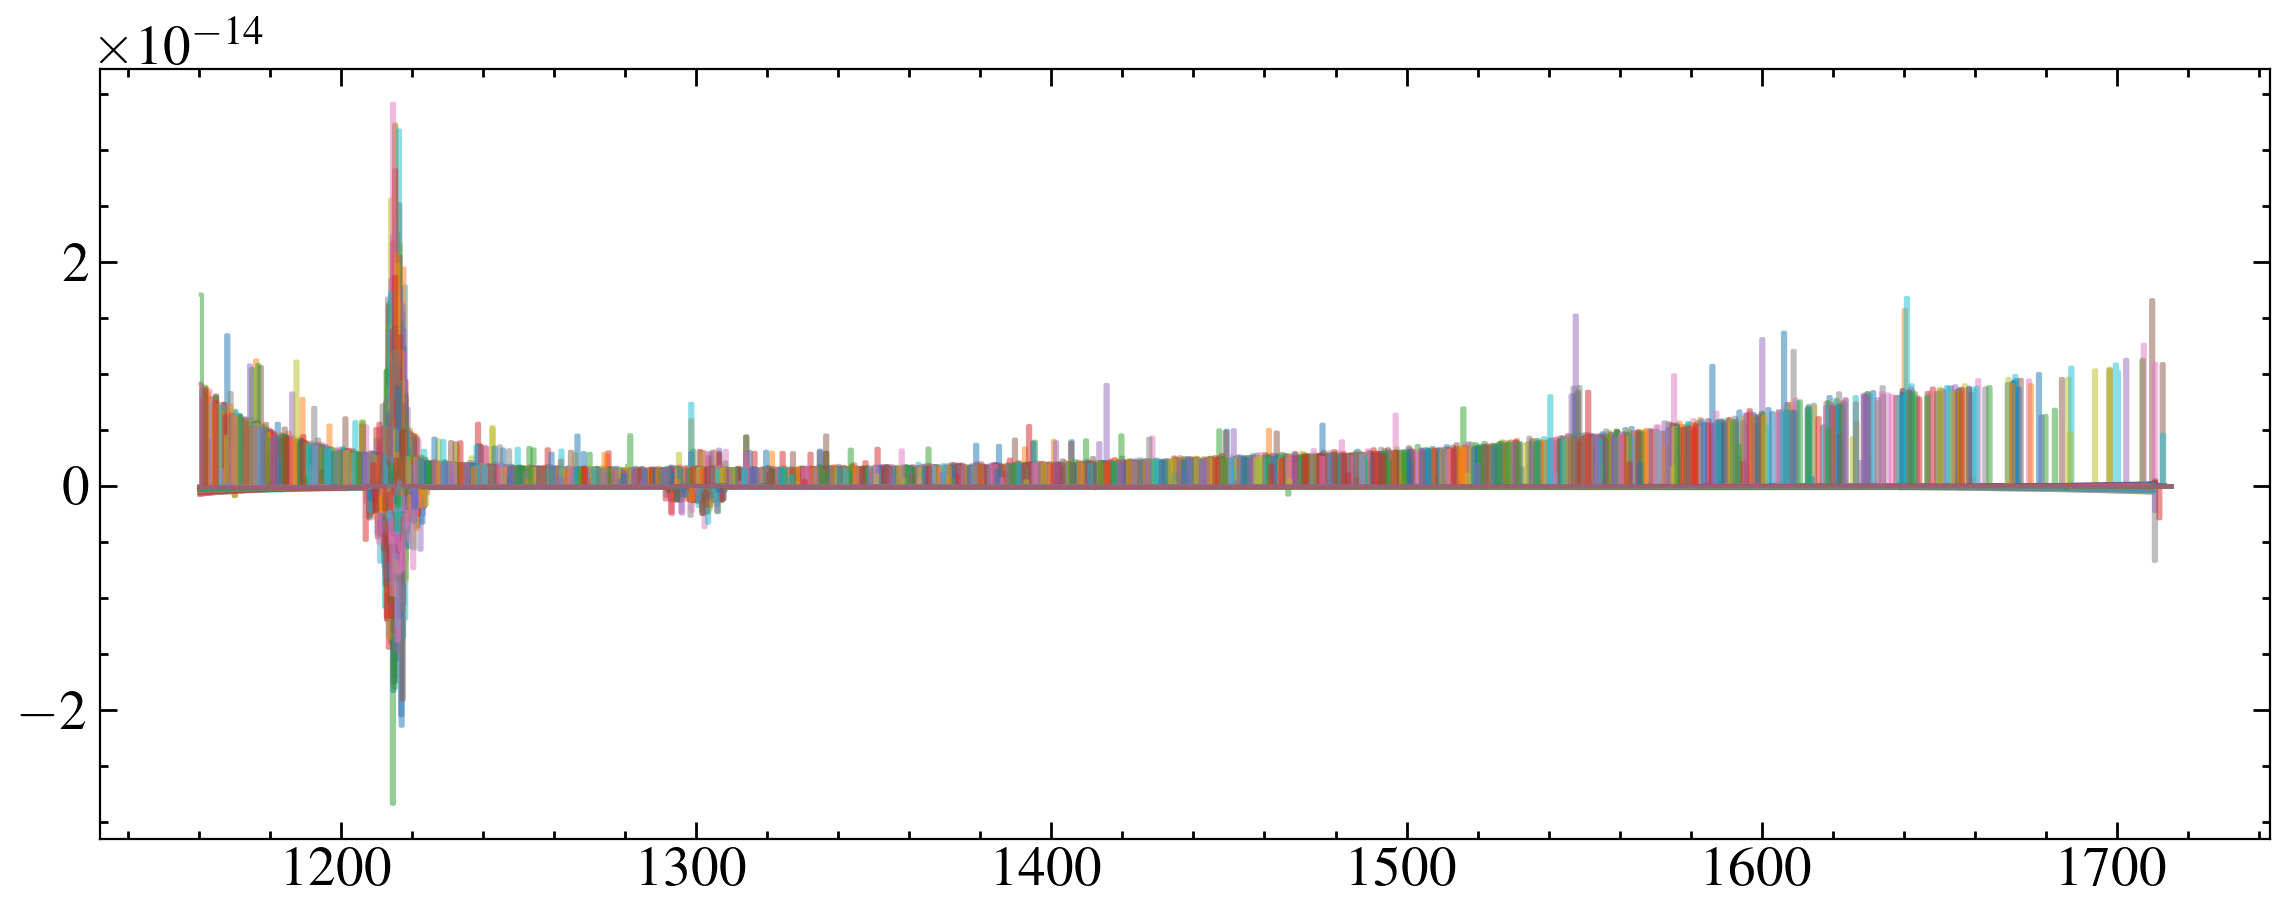

odlm35050


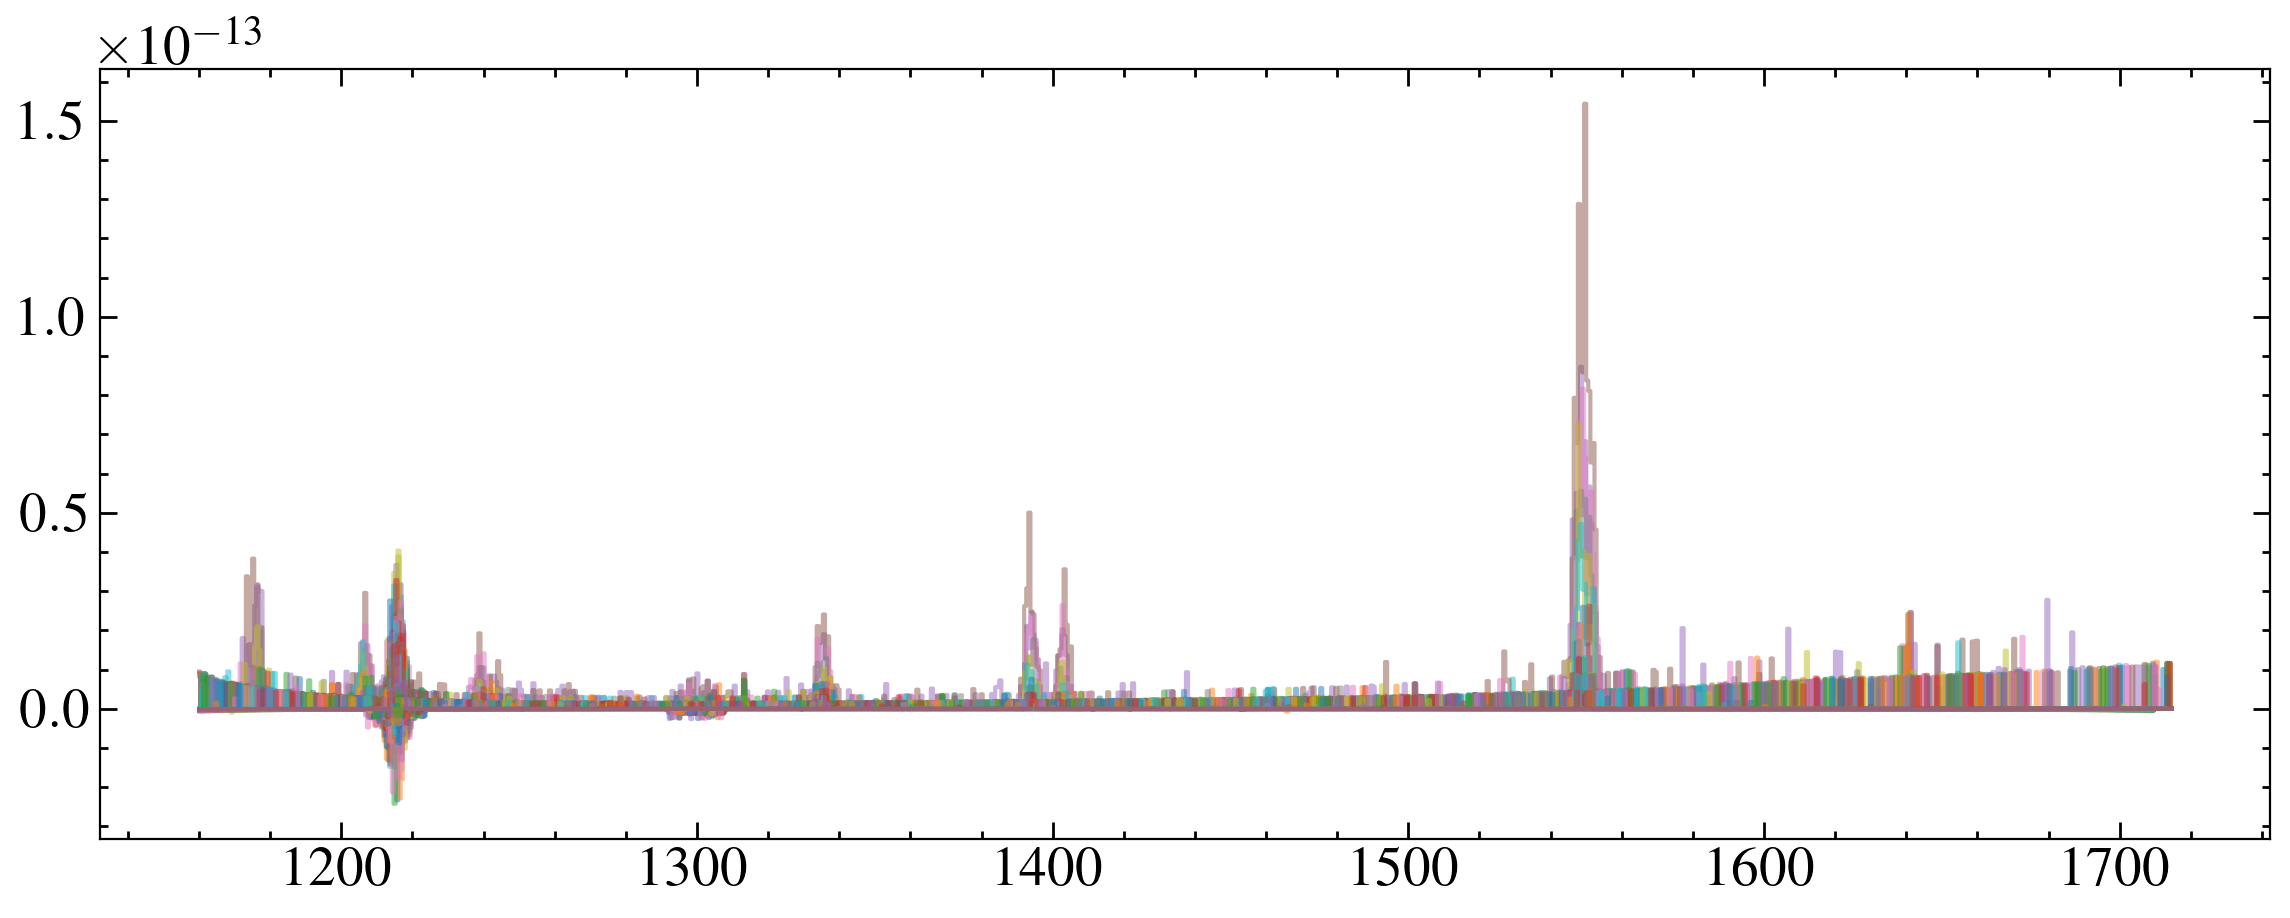

odlm35060


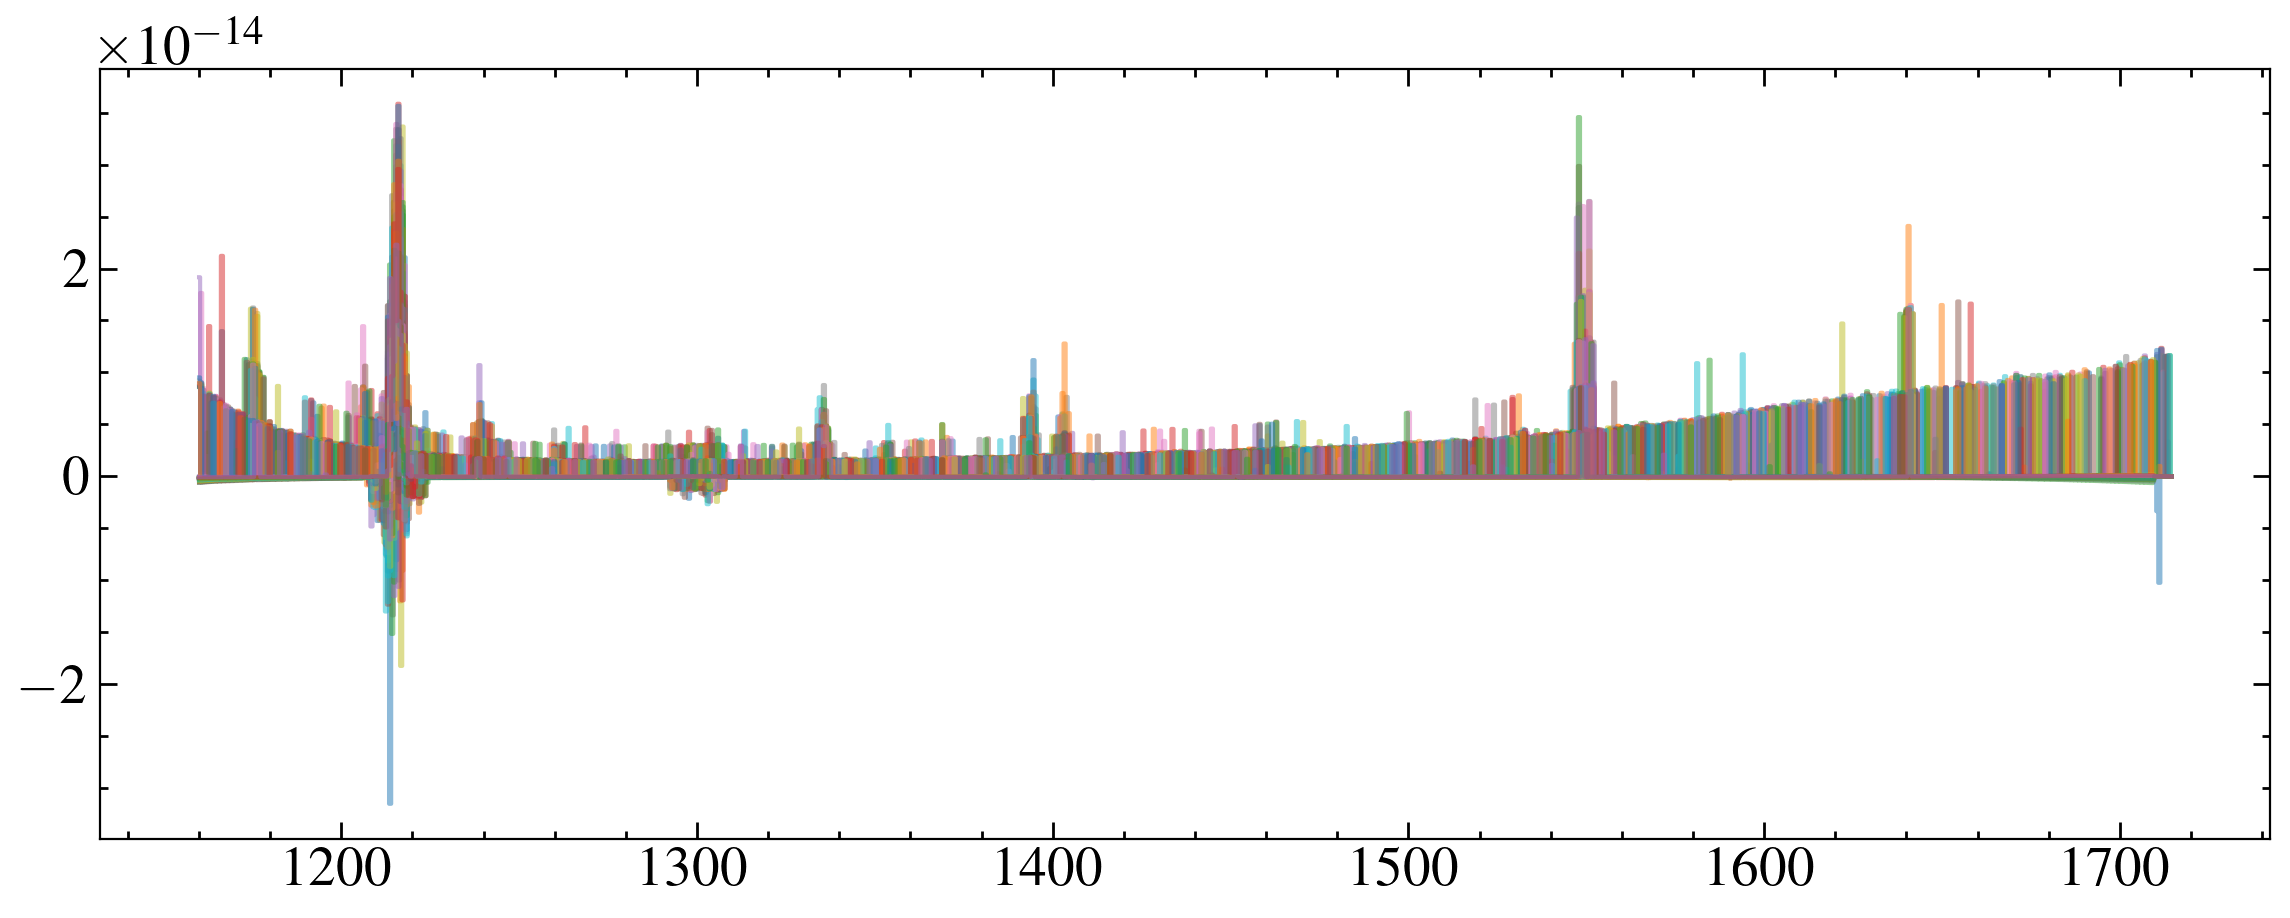

odlmz4010


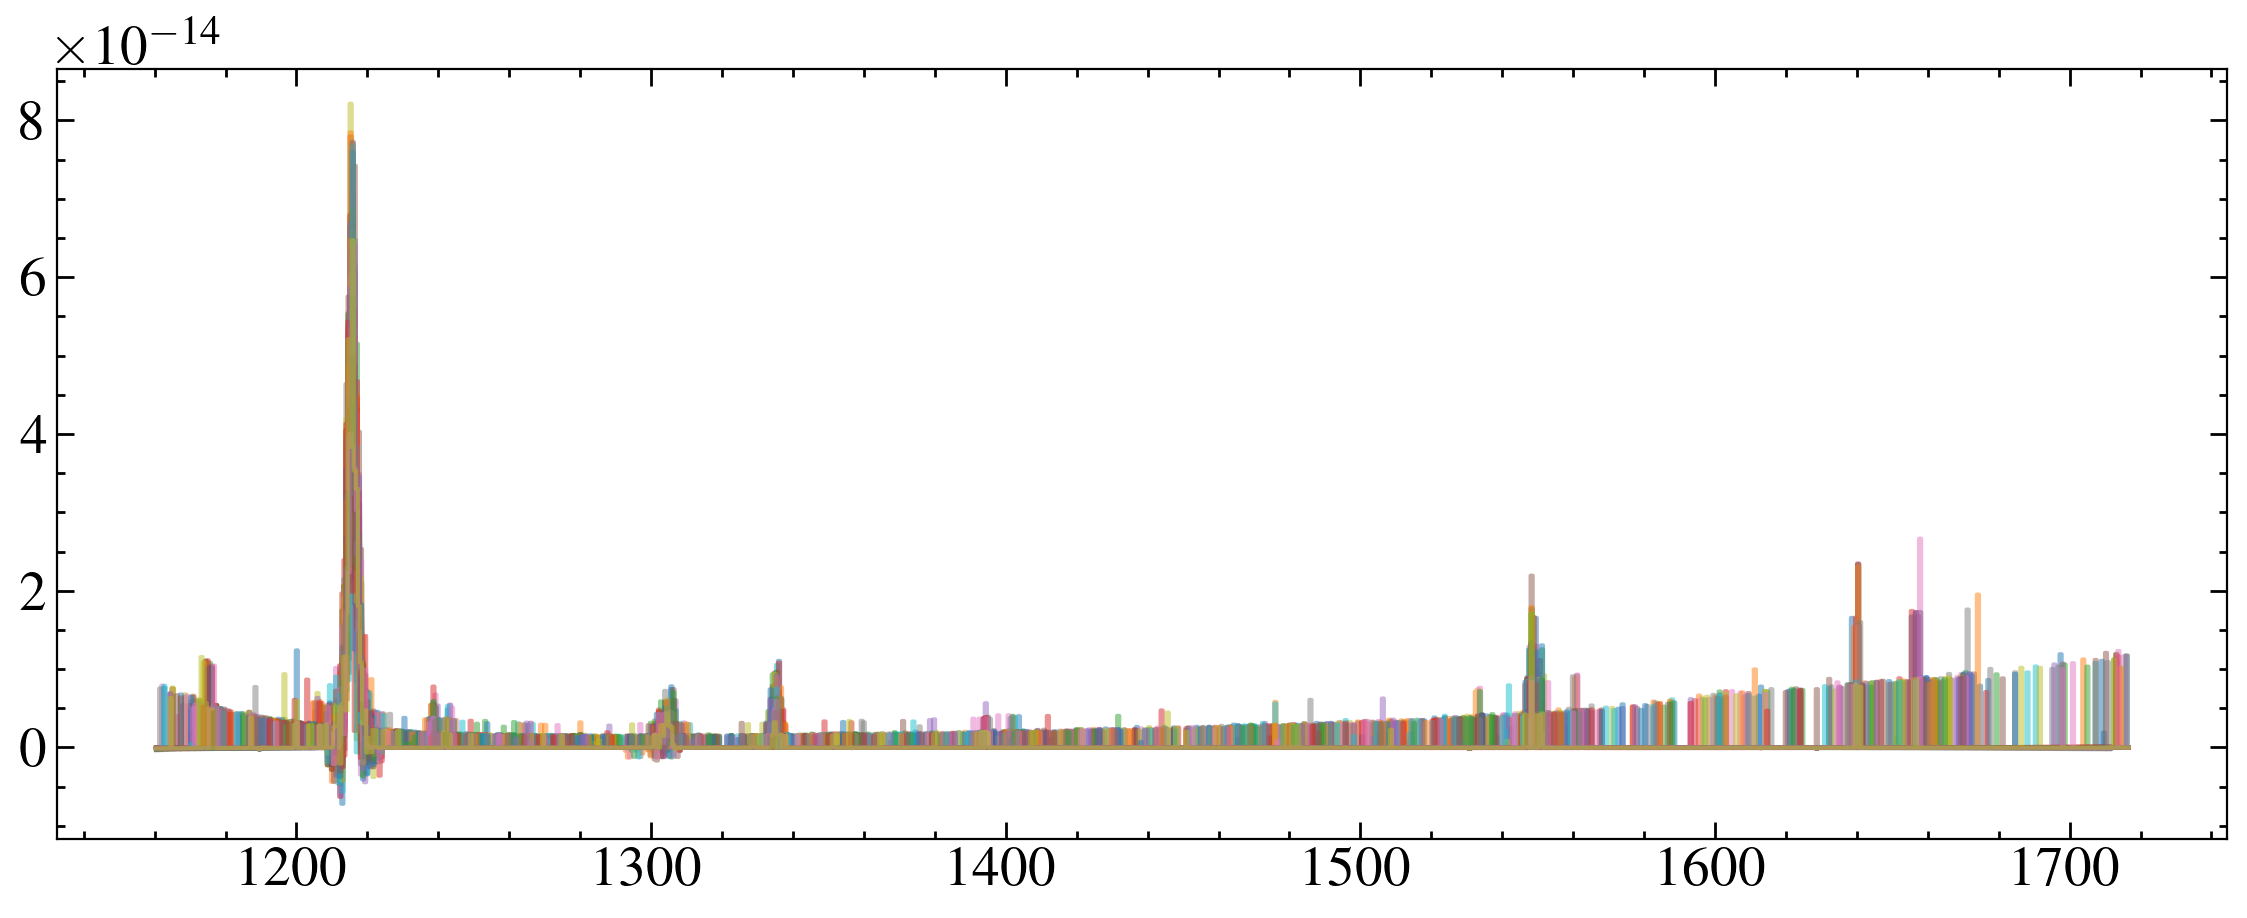

odlmz4020


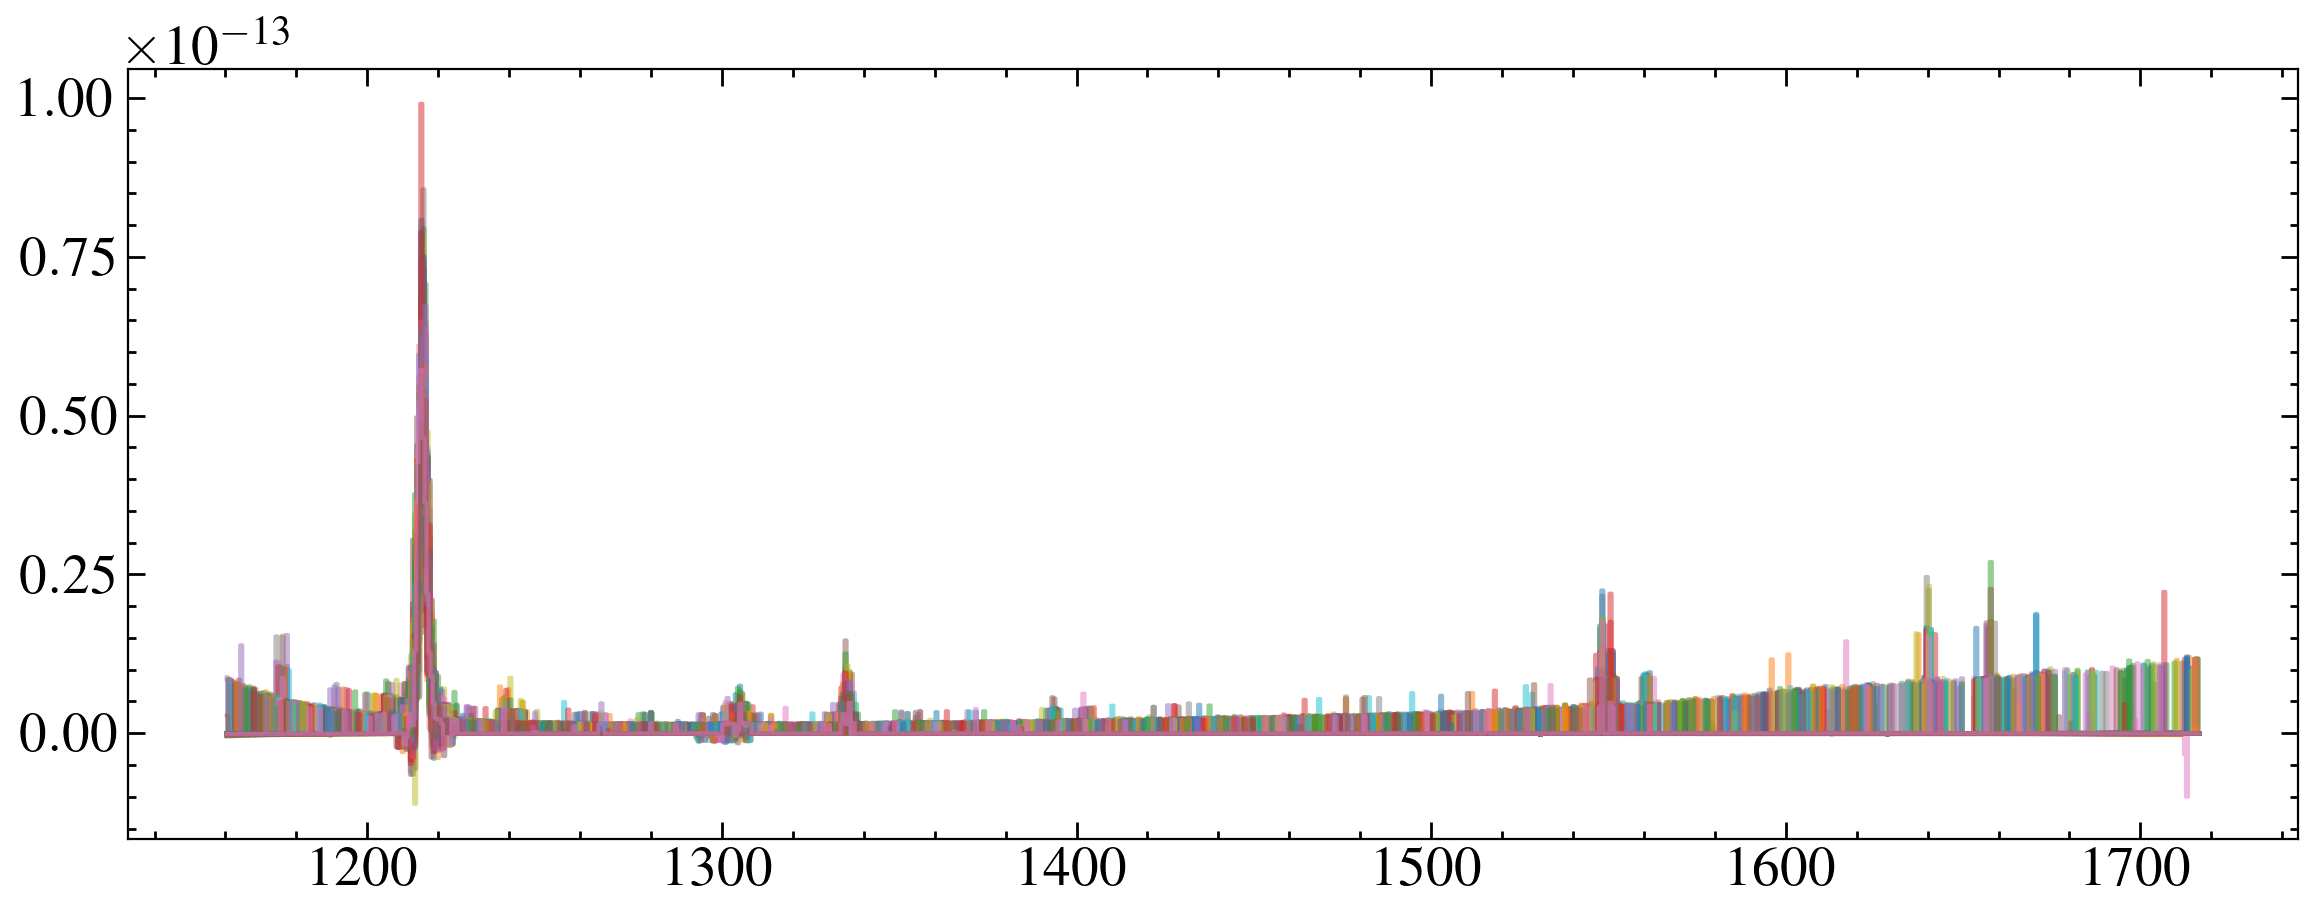

odlmz4030


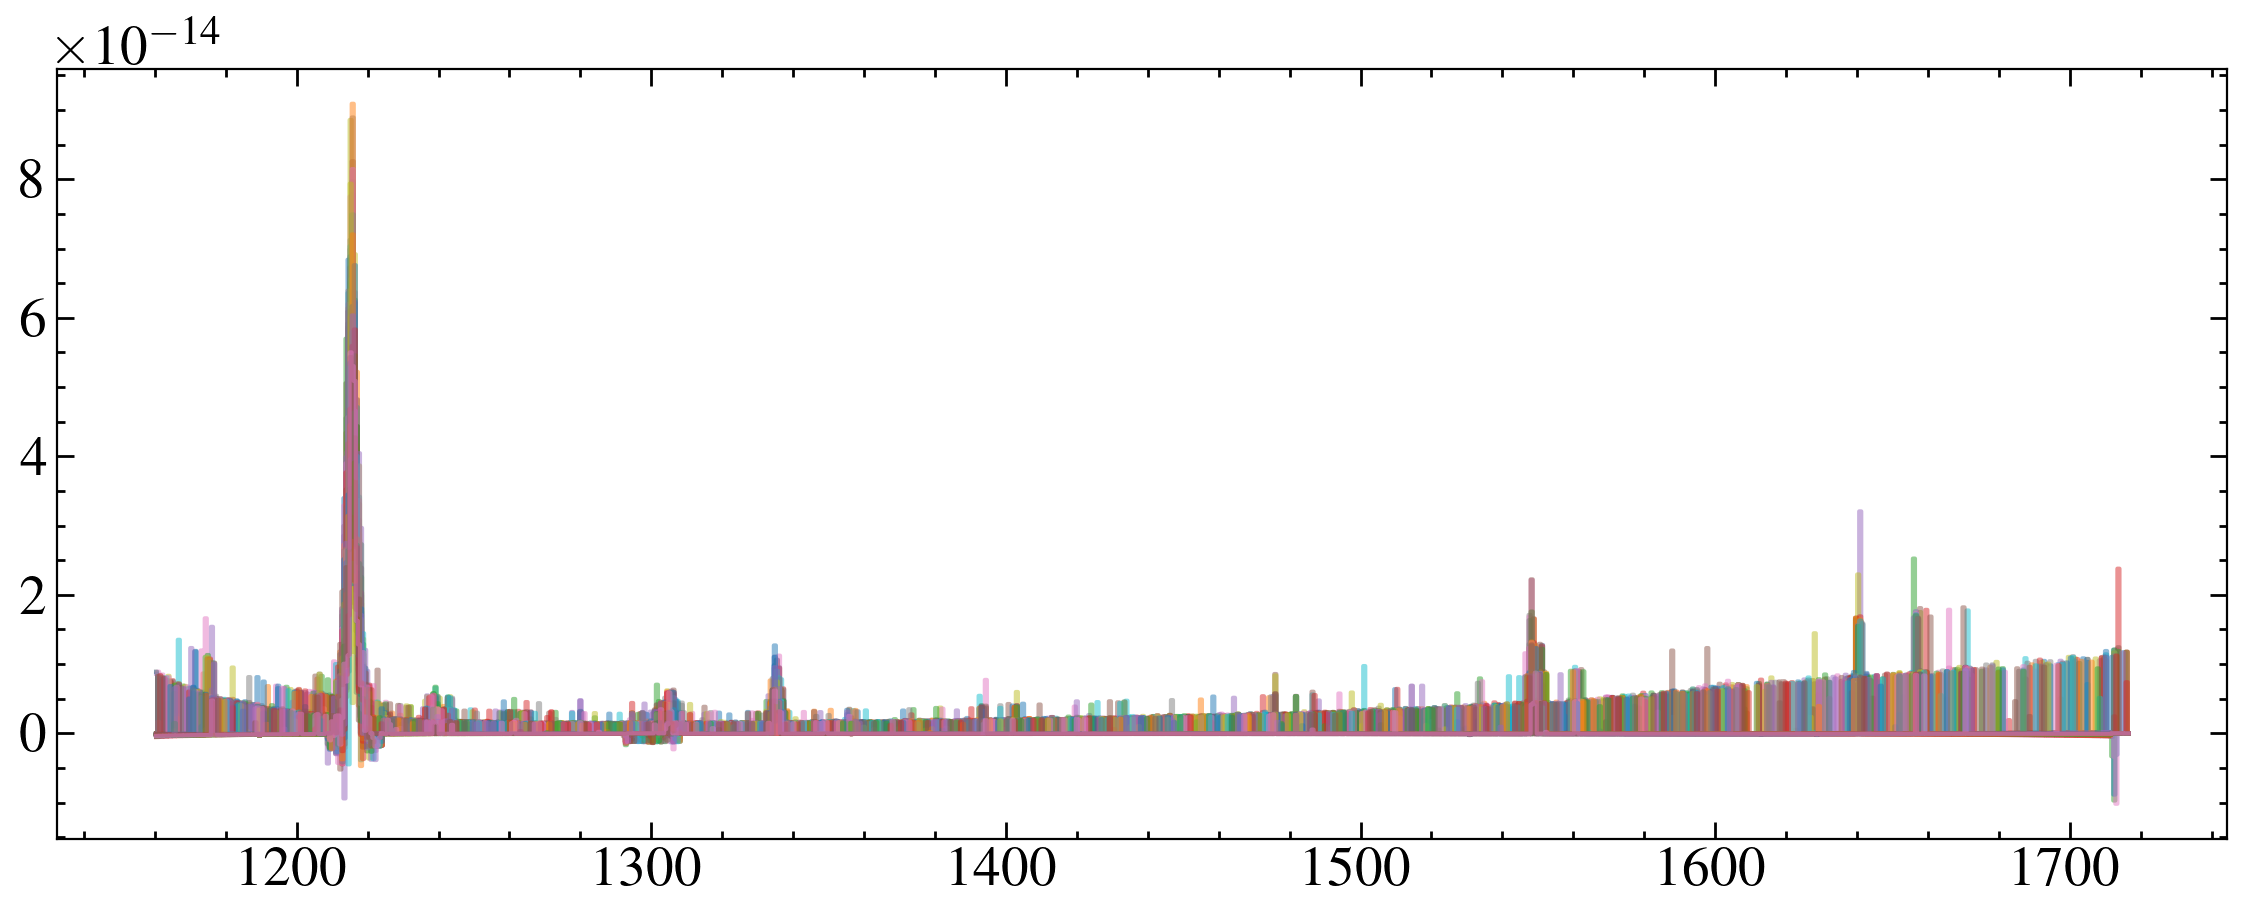

odlmz4040


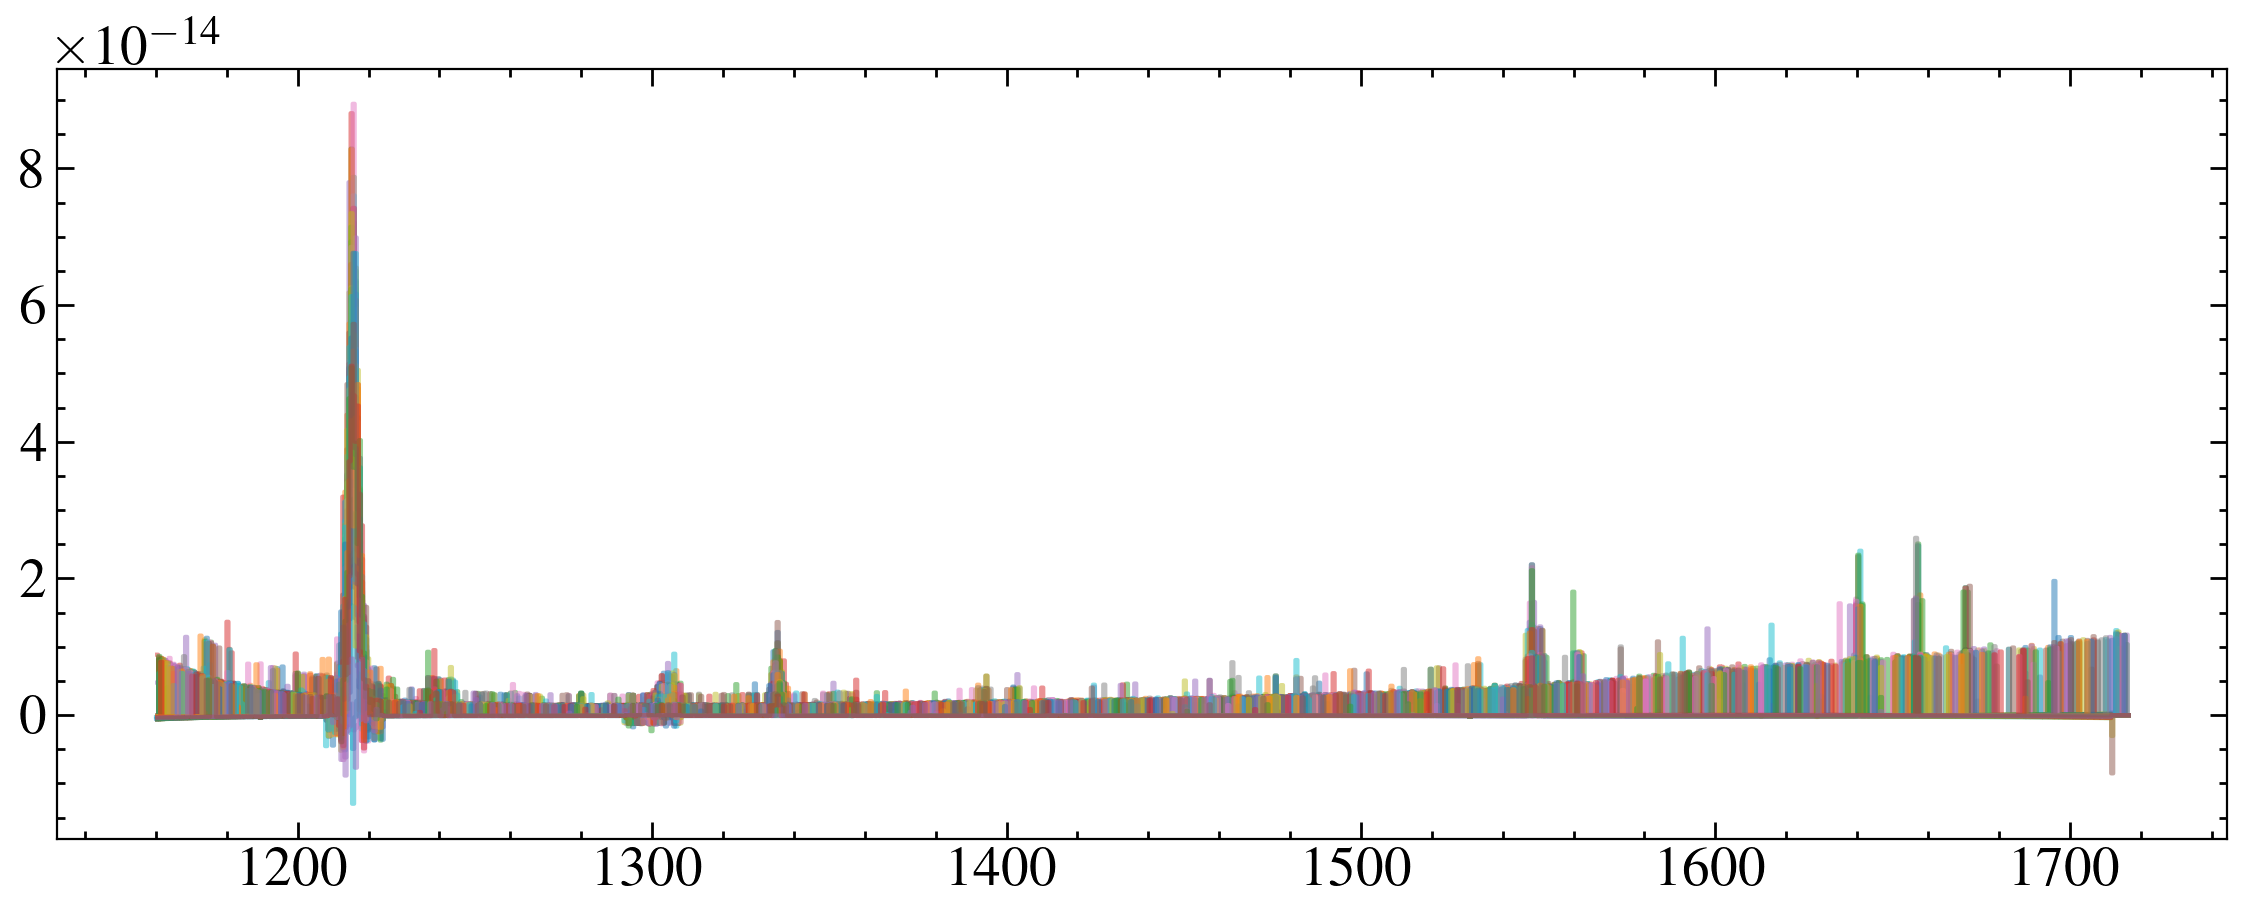

odlmz4050


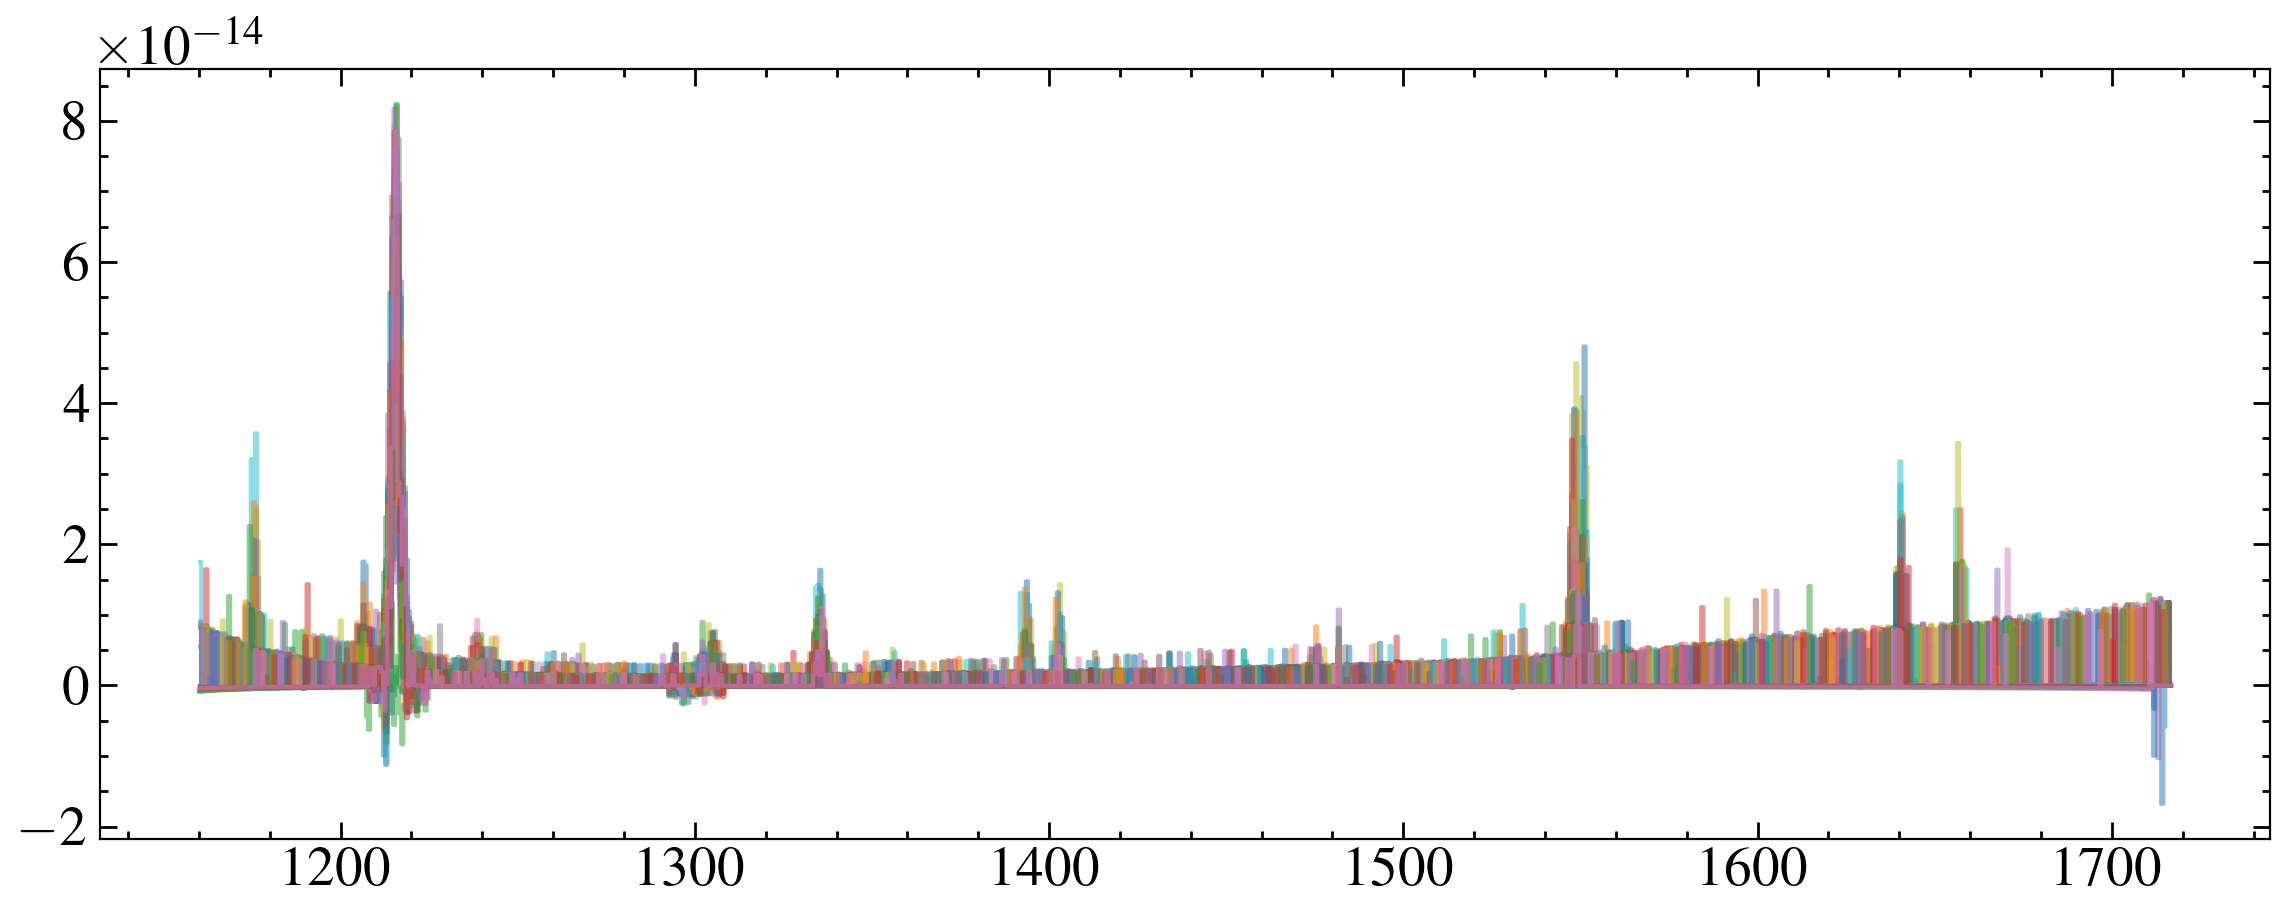

In [14]:
for x in new_x1ds:
    fig, ax = plt.subplots()
    hdul = fits.open(x)
    print(hdul[0].header['ROOTNAME'])
    for ext in hdul[1::]: #spectra in every extension after the first
        data = ext.data
        for dt in data:
            mask = dt['WAVELENGTH'] > 1160
            ax.step(dt['WAVELENGTH'][mask], dt['FLUX'][mask], where='mid', alpha=0.5)
        # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
        # ax.set_ylim(0, 1.1*max(data['FLUX']))
        # plt.show()
    hdul.close()
    plt.show()
    

In [15]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**0.5
    return flux,error

def echelle_coadd_dq(wavelength, flux, err, dq, nclip =5, find_ratio =True, dq_adjust=False, dq_cut =0):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    #slice dodgy ends off orders (usually 5-10 for stis el40m)
    wavelength = wavelength[:, nclip:-(nclip+1)]
    flux = flux[:, nclip:-(nclip+1)]
    err = err[:, nclip:-(nclip+1)]
    dq = dq[:, nclip:-(nclip+1)]
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)
    dq_full = np.array([], dtype=int)
    if find_ratio:
        r_full = np.array([], dtype=float) #ratio between orders

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
        dq_full = np.concatenate((dq_full, dq[order][overmask]))
        if find_ratio:
            r_full = np.concatenate((r_full, np.full(len(err[order][overmask]), -1)))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            dqi = interpolate.interp1d(wavelength[order + 1], dq[order + 1], kind='nearest',bounds_error=False, fill_value=0)
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
            dq0 = dq[order][overlap]
            dq1 = dqi(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            if dq_adjust: #removes values with high dq: #THIS DOESN'T REALLY WORK YET
                if dq_cut == 0:
                    dq_cut = 1 #allows zero to be the default
                for i in range(len(wavelength[order][overlap])):
                    if dq0[i] >= dq_cut:
                        g0 *= 100 #make error very large so it doesn't contribute to the coadd
                    if dq1[i] >= dq_cut:
                        g1 *= 100 
                        
            
            
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            dq_av = [(np.sum(np.unique(np.array([dq0, dq1])[:,i]))) for i in range(len(dq0))]
            
            
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
            dq_full = np.concatenate((dq_full, dq_av))
            
            if find_ratio:
                r_full = np.concatenate((r_full, f0/f1))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
    sorted_dq = dq_full[arr1inds]
    if find_ratio:
        sorted_r = r_full[arr1inds]
 
    if find_ratio:
        return sorted_w, sorted_f, sorted_e, sorted_dq, sorted_r
    else:
        return sorted_w, sorted_f, sorted_e, sorted_dq

GJ676A
1.446252449097314 1.519857677090744 1.0508937620395187 4.8429026679868


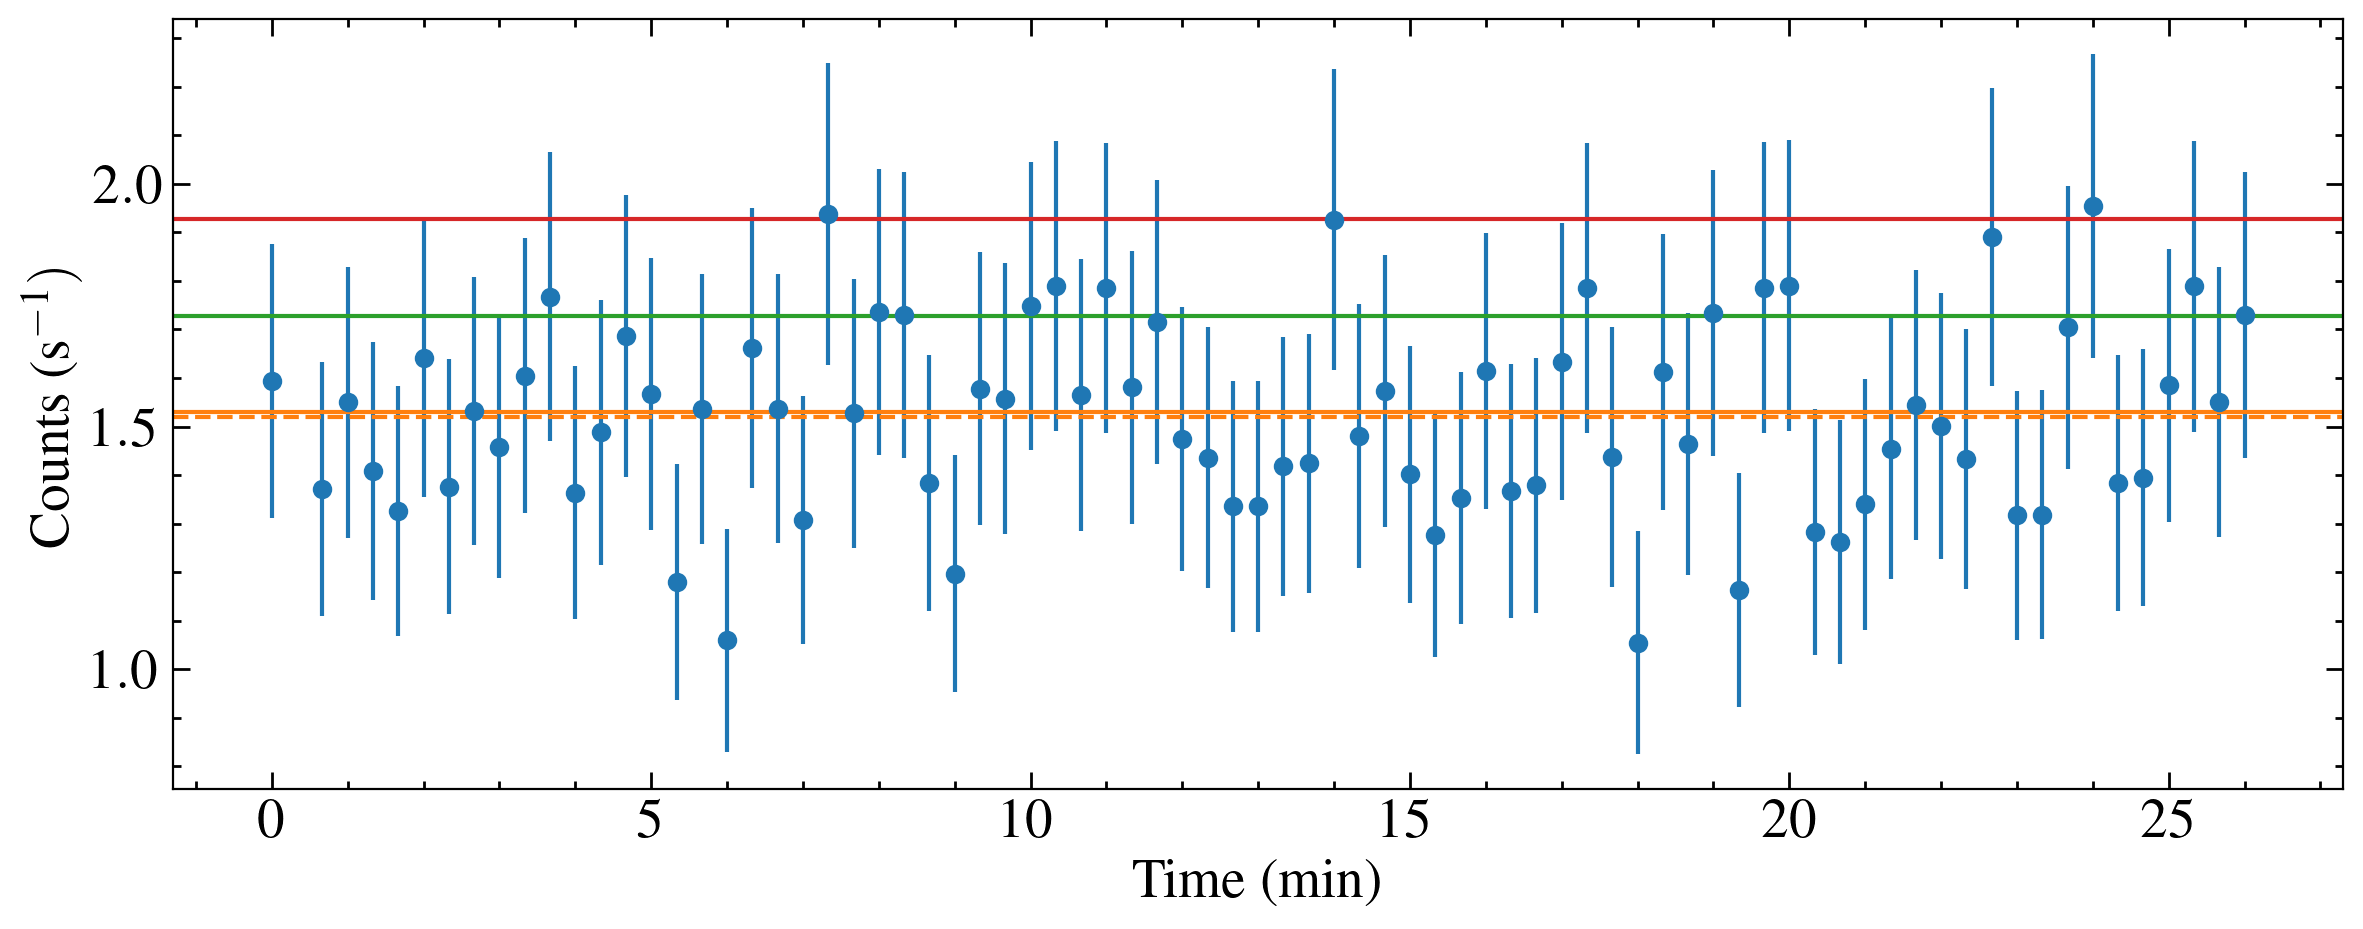

GJ676A
1.3635377750503634 1.4417969549374967 1.0573942147545143 5.427891883051305


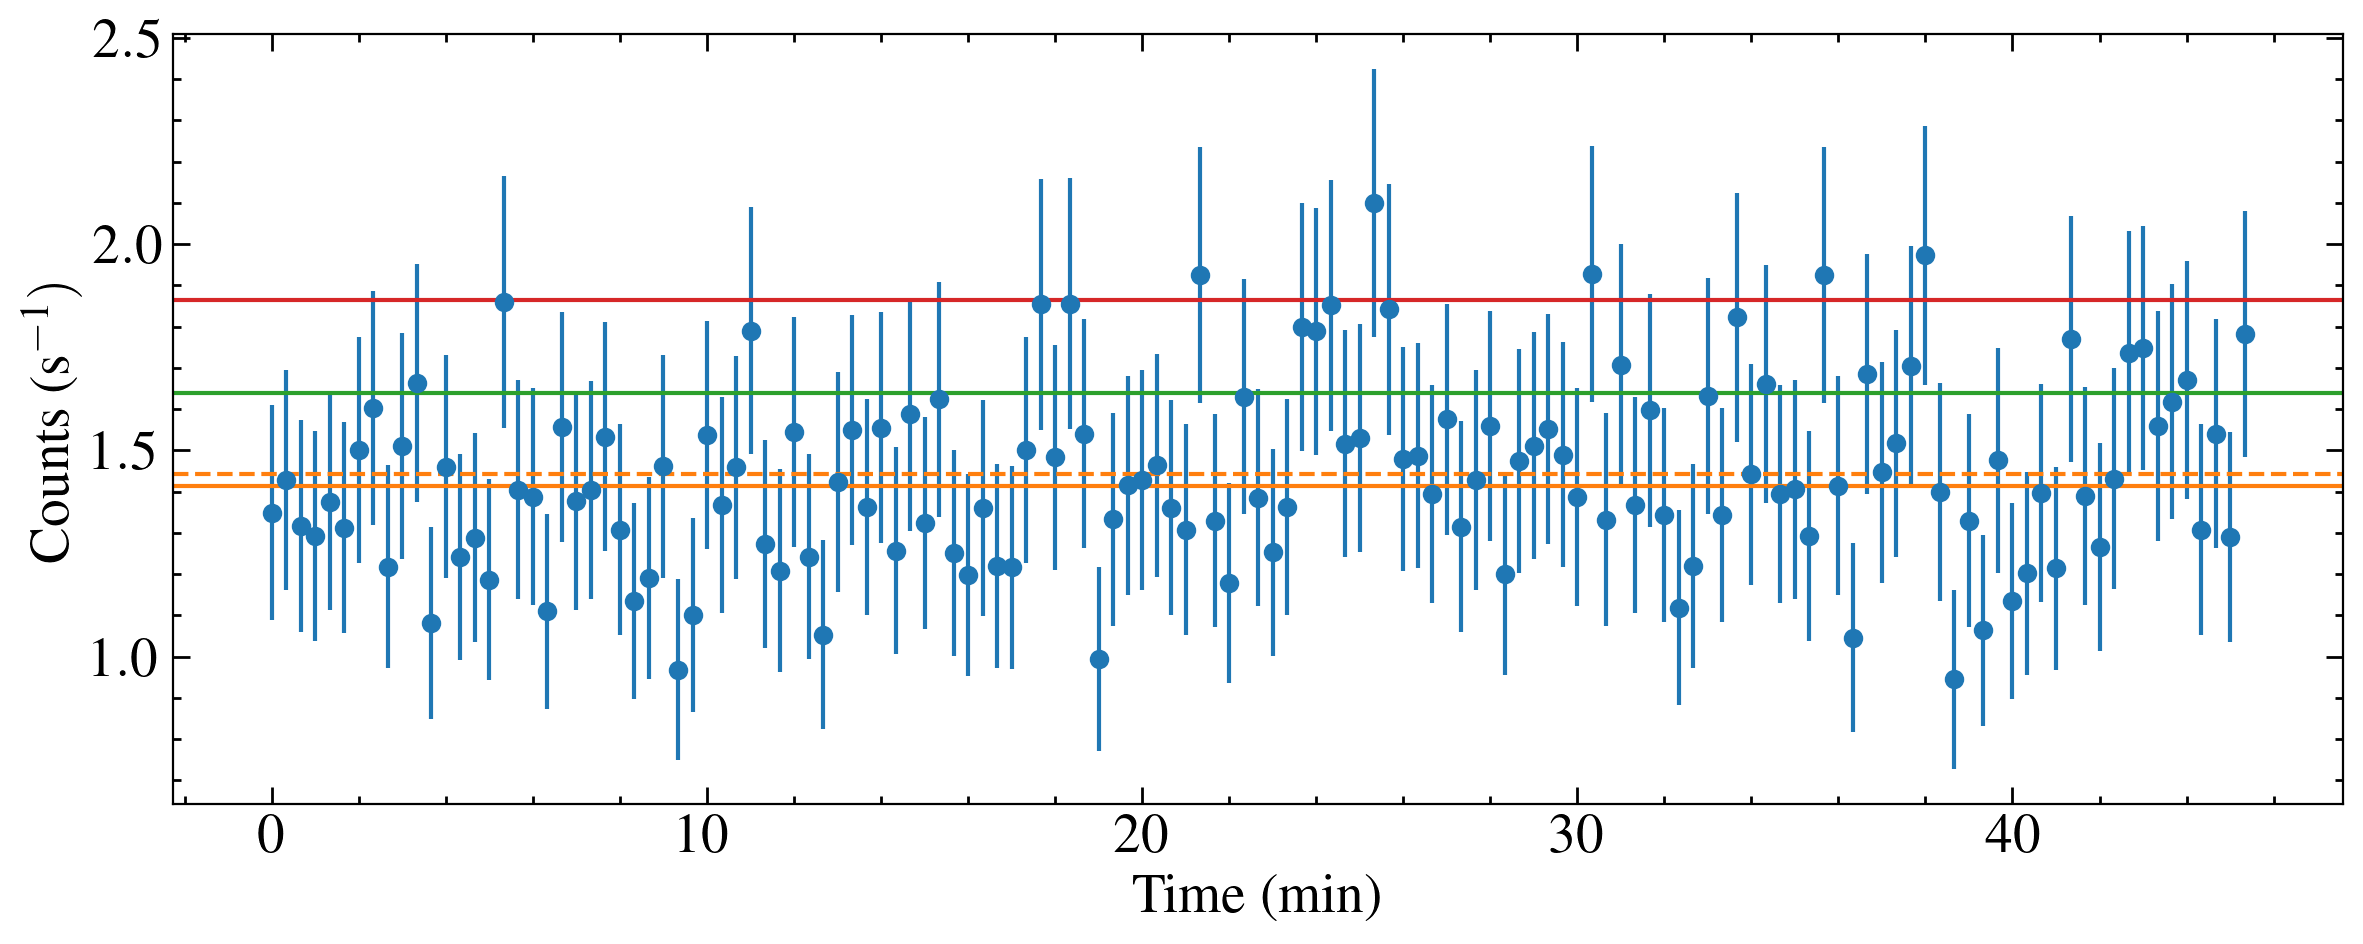

GJ676A
1.564286907071915 1.6299325082952683 1.0419651925273932 4.027504261020686


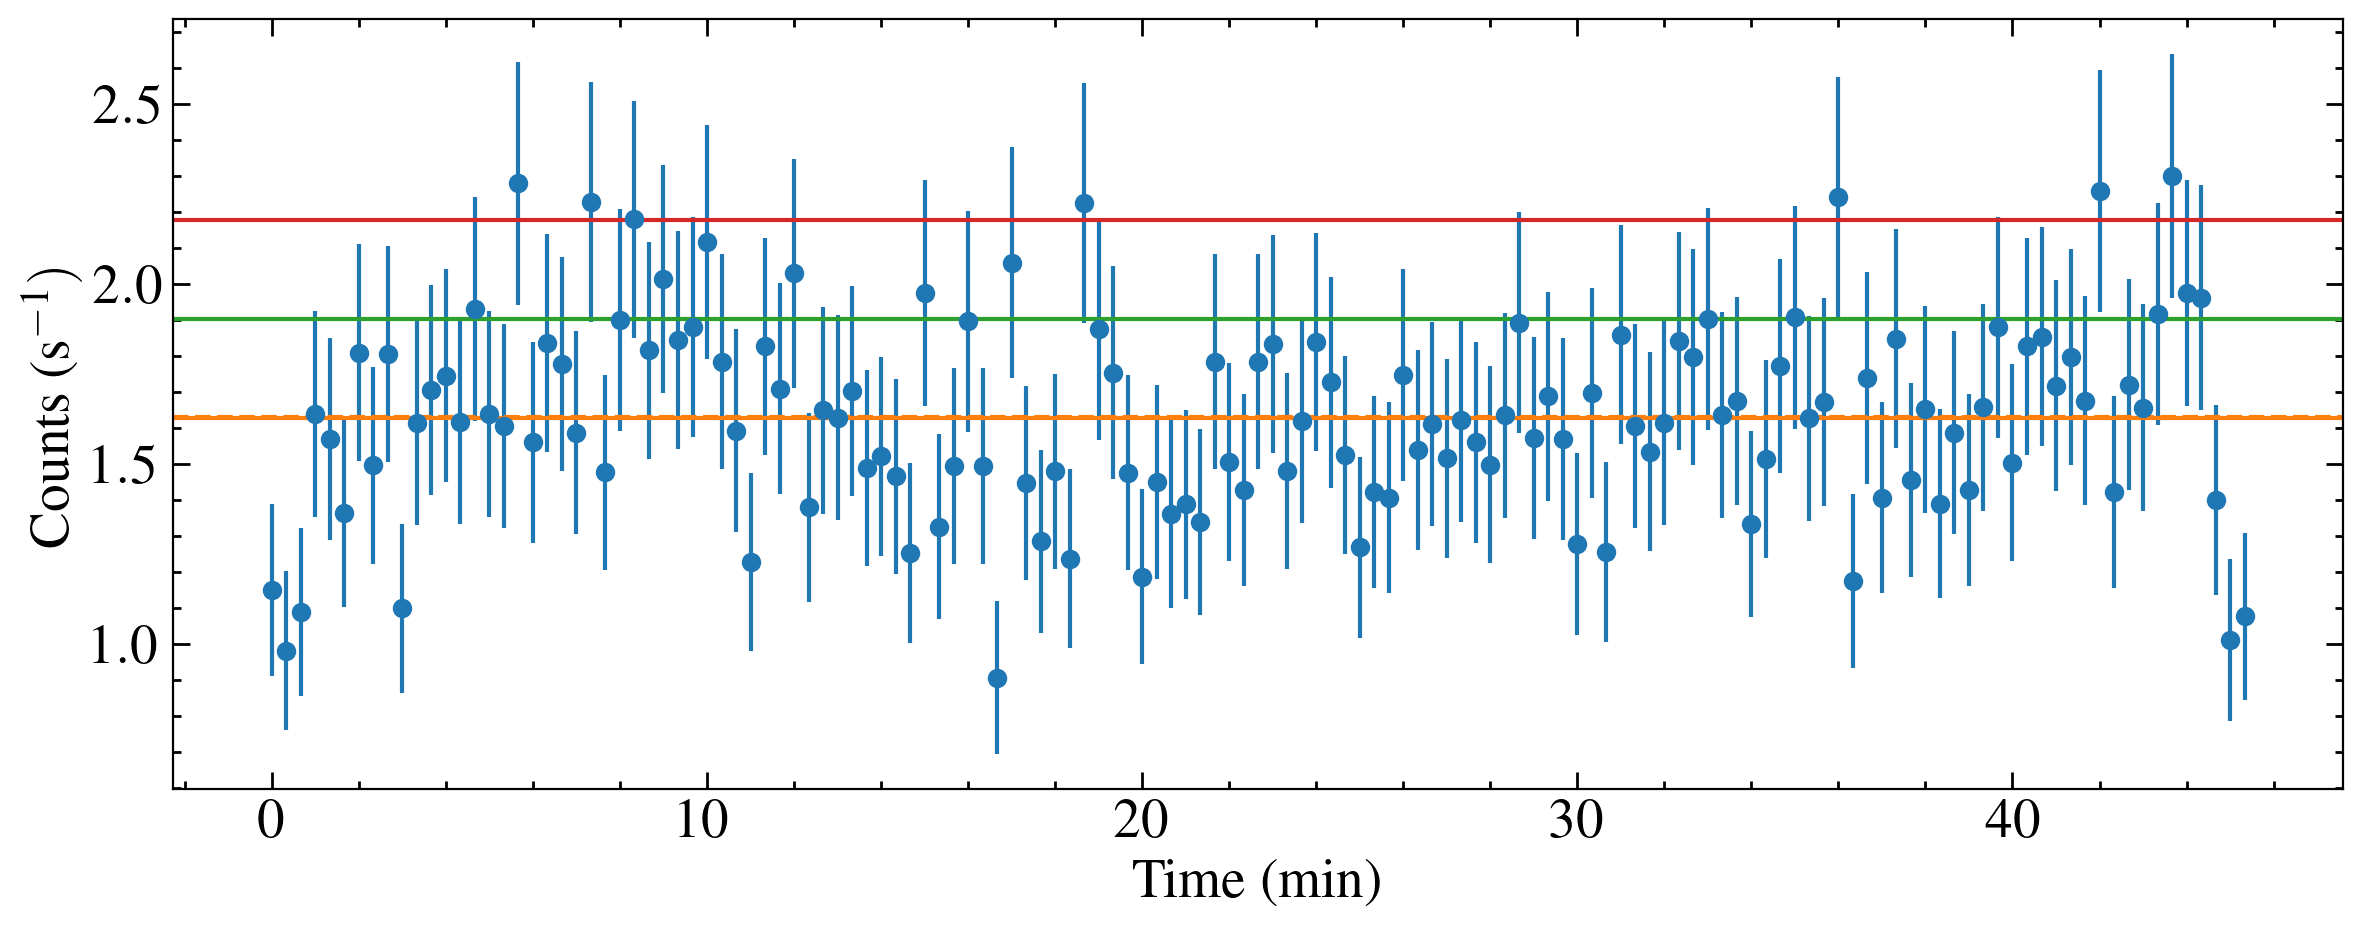

GJ649
1.1549159525162243 1.2342518529874509 1.0686940900750197 6.427853462743253


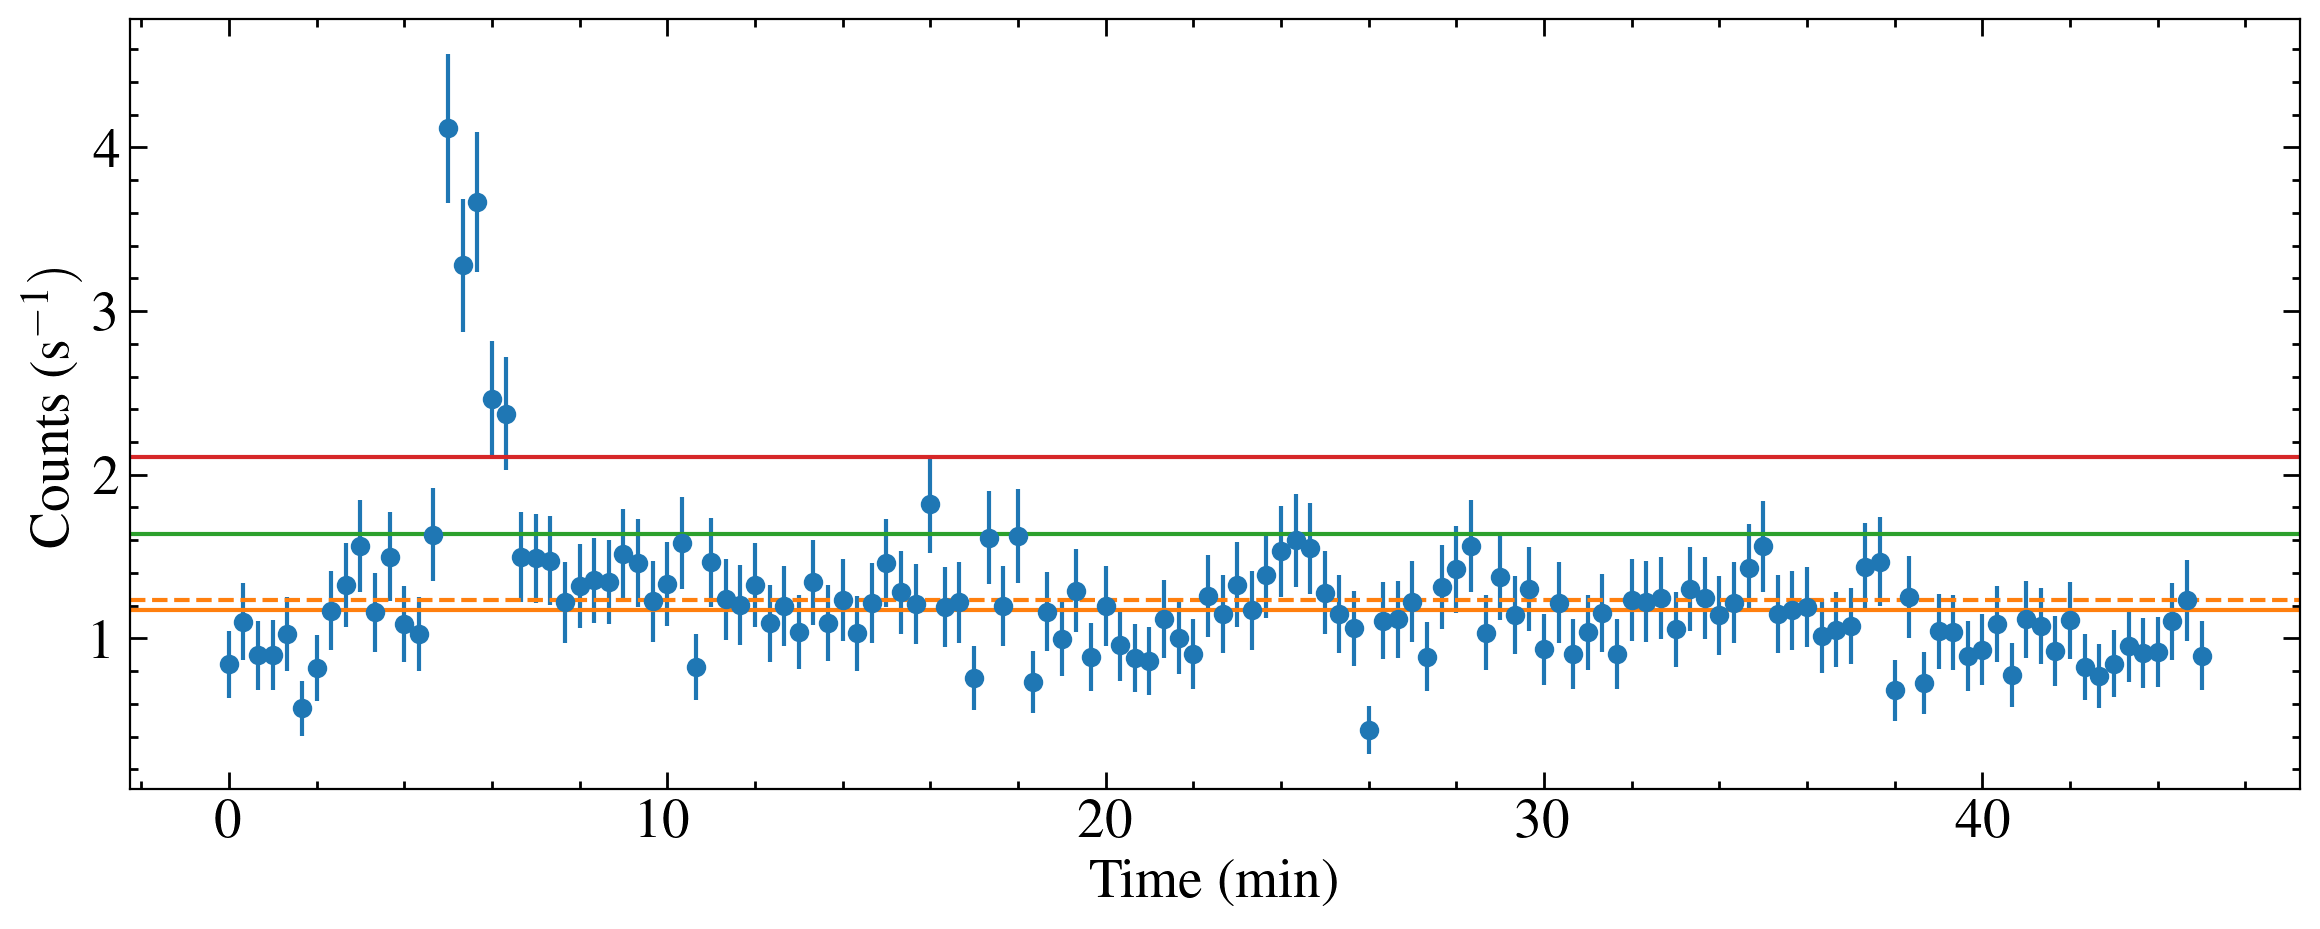

GJ649


/tmp/ipykernel_199270/2118407131.py:41: RuntimeWarning: invalid value encountered in scalar power
  ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts


1.1567098485804321 1.2043900141991521 1.0412205063155944 3.958864243027164


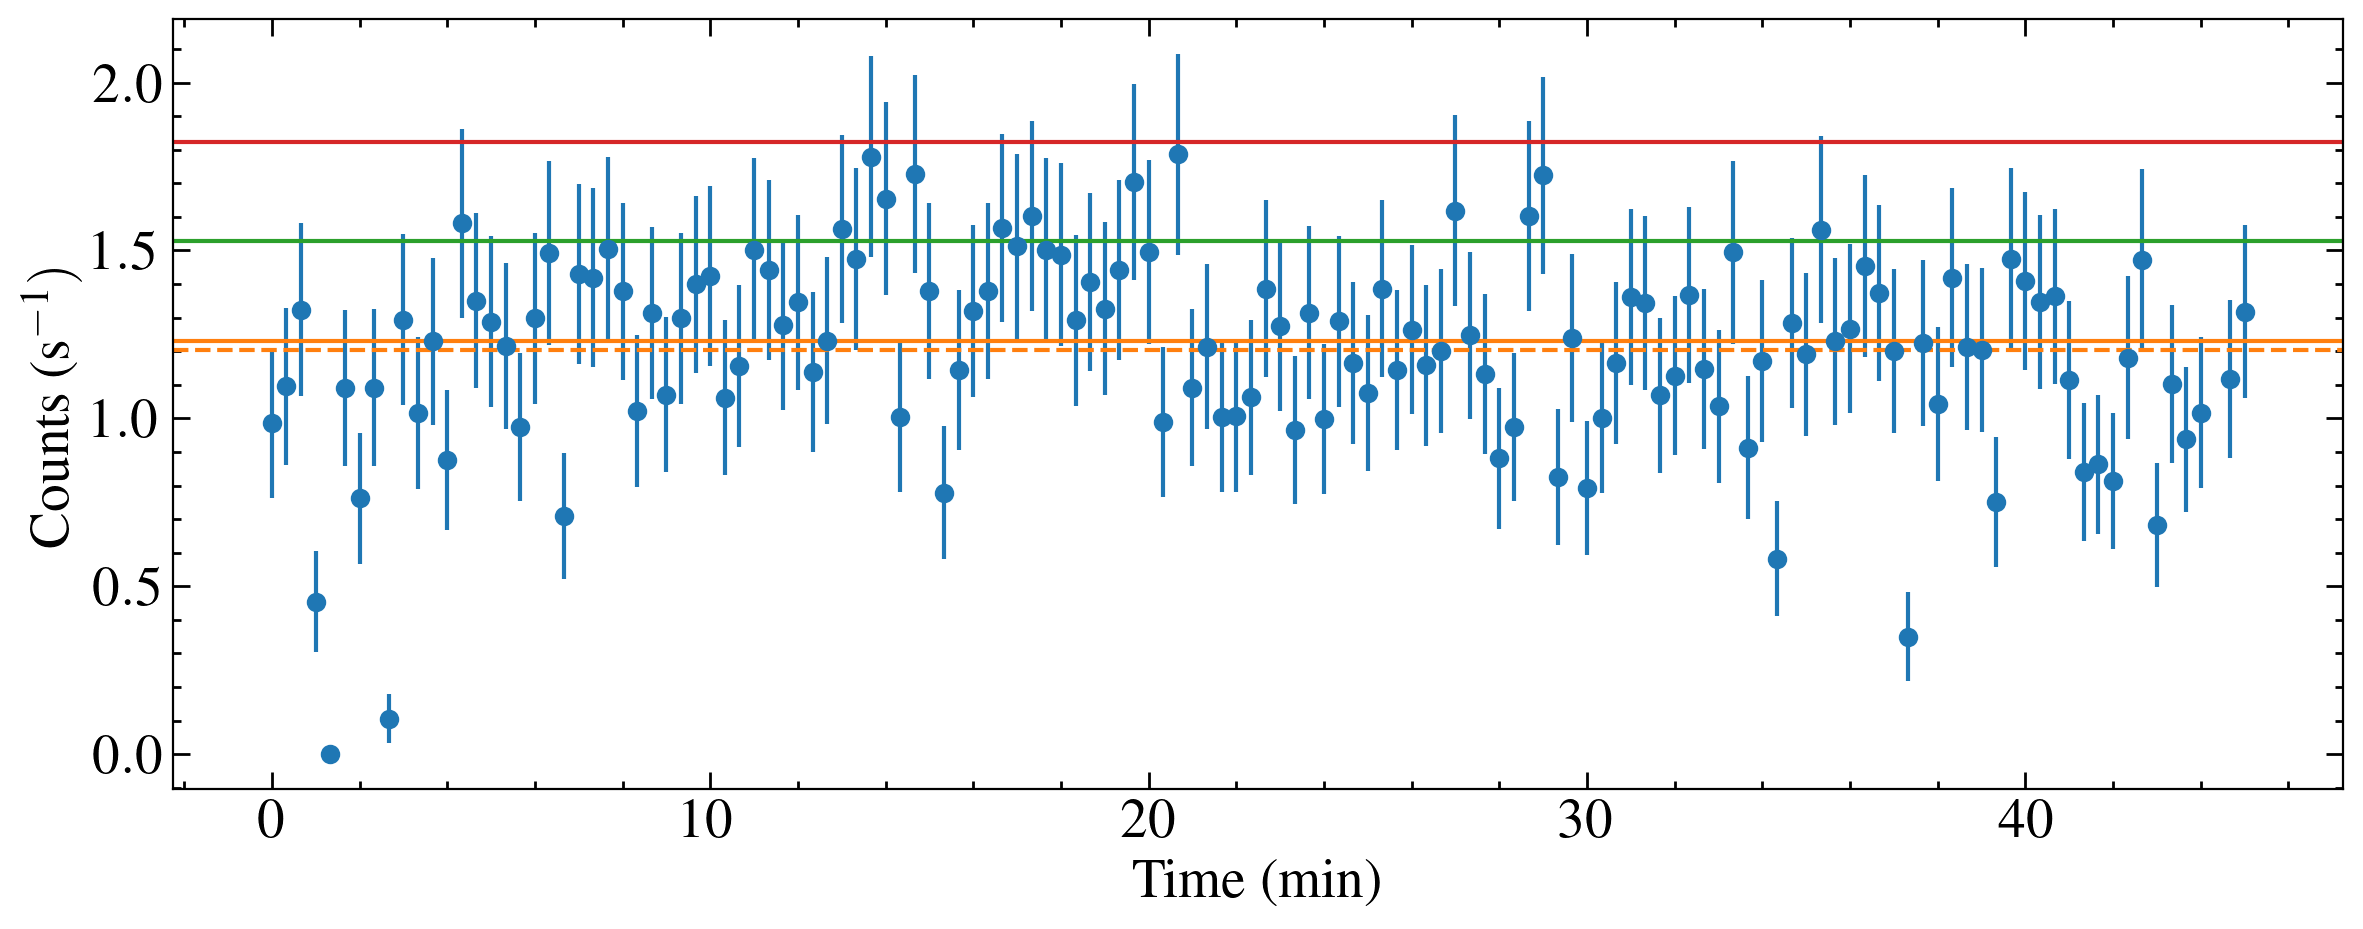

GJ649
0.8791280862283676 0.9013961683816656 1.0253297357940554 2.4703990248014174


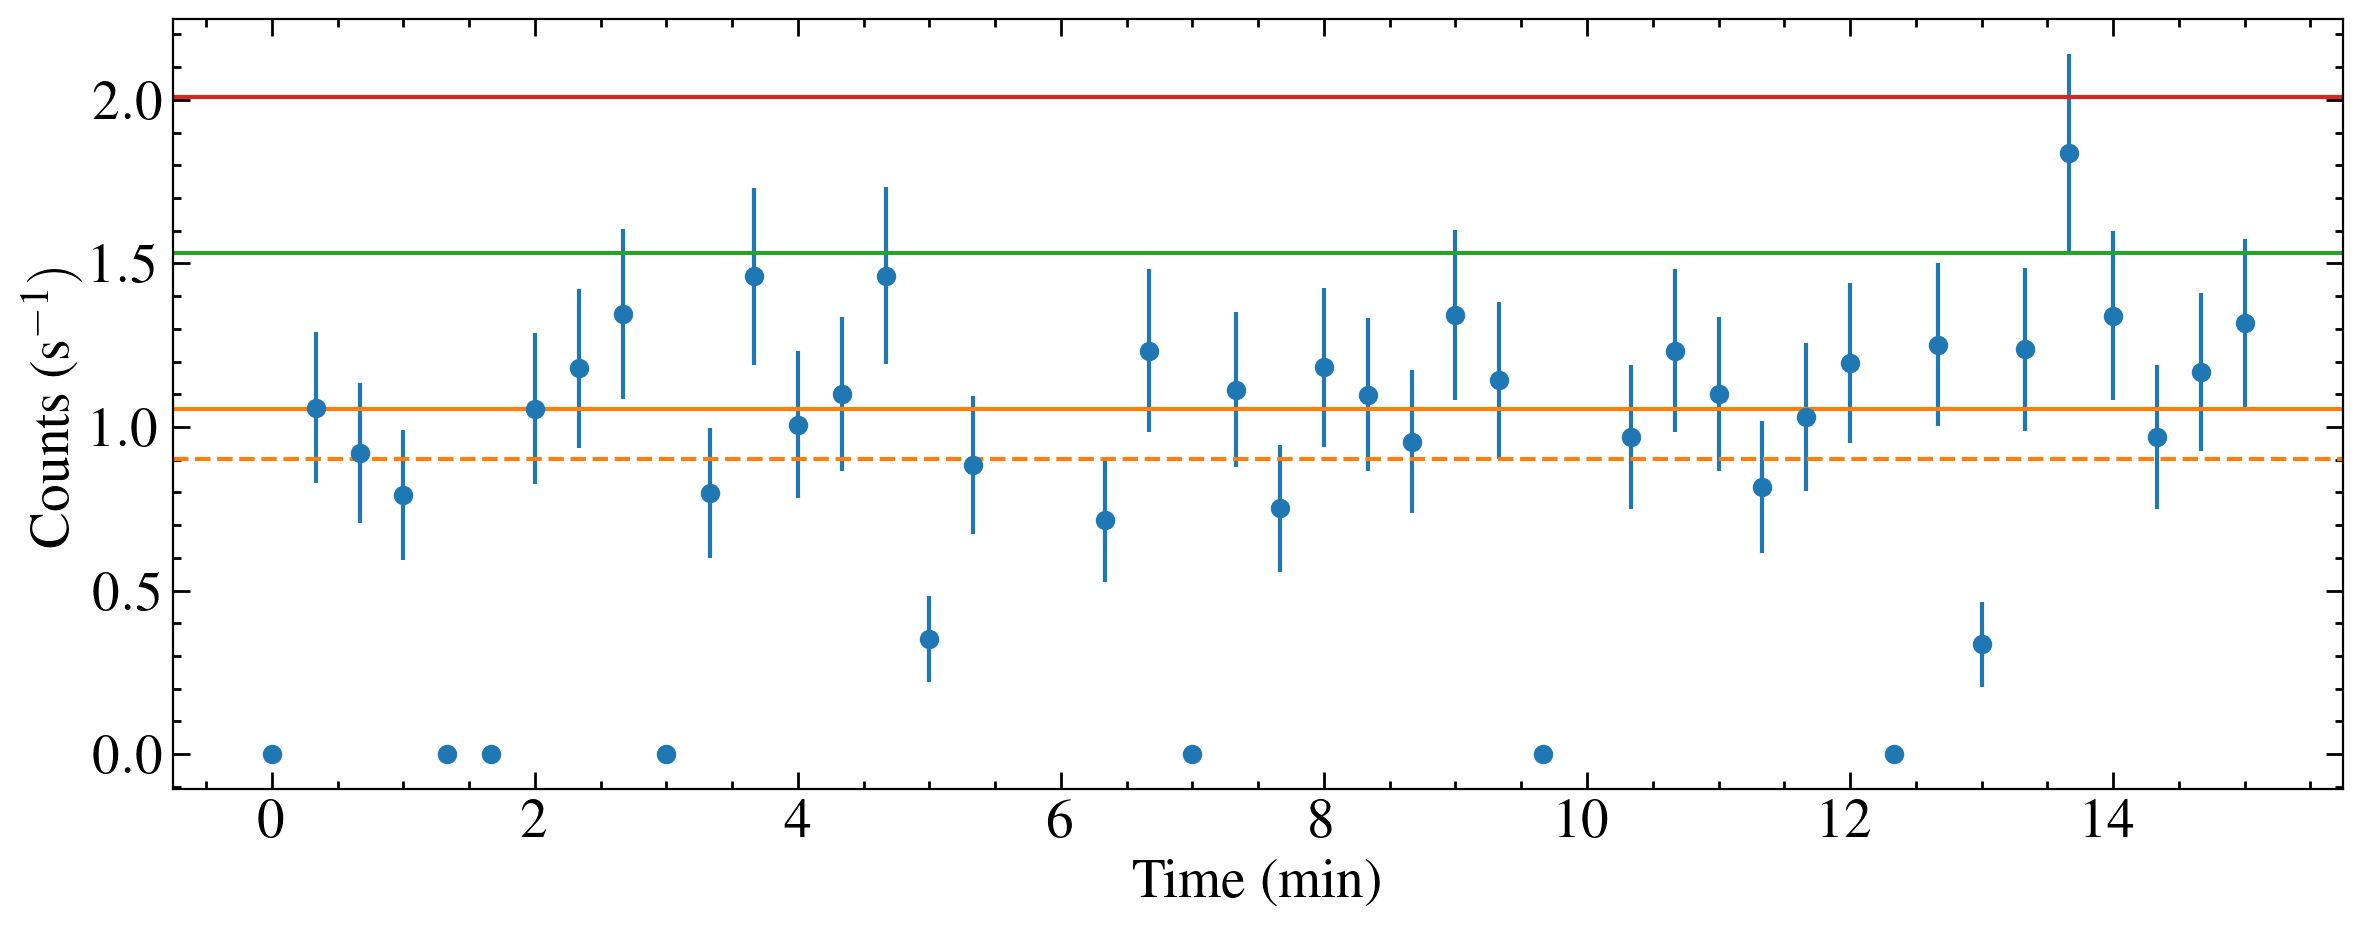

GJ674
4.552309493069046 5.6171073177340896 1.2339027753464944 18.95633756726188


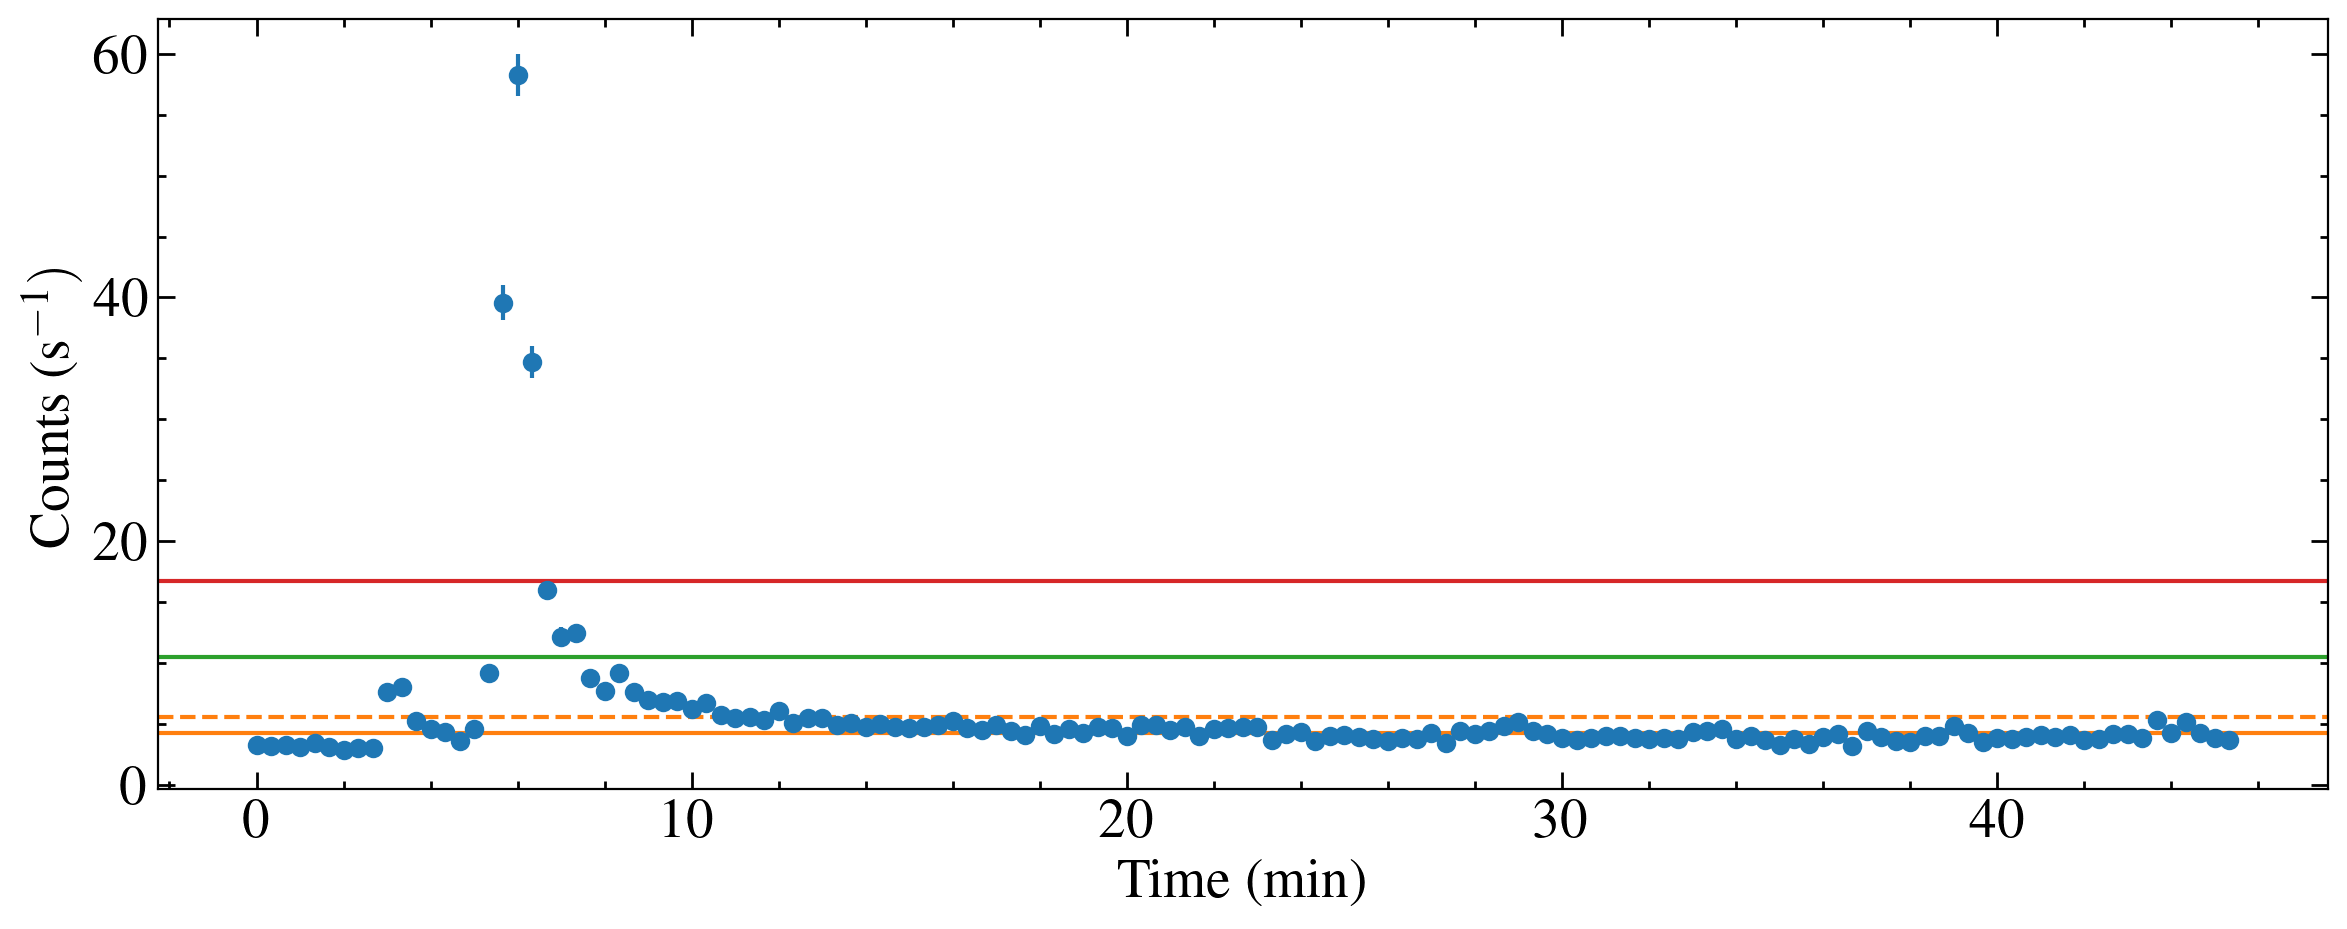

GJ674
3.6564347348963224 3.9740132879580514 1.0868547030337556 7.991381257431801


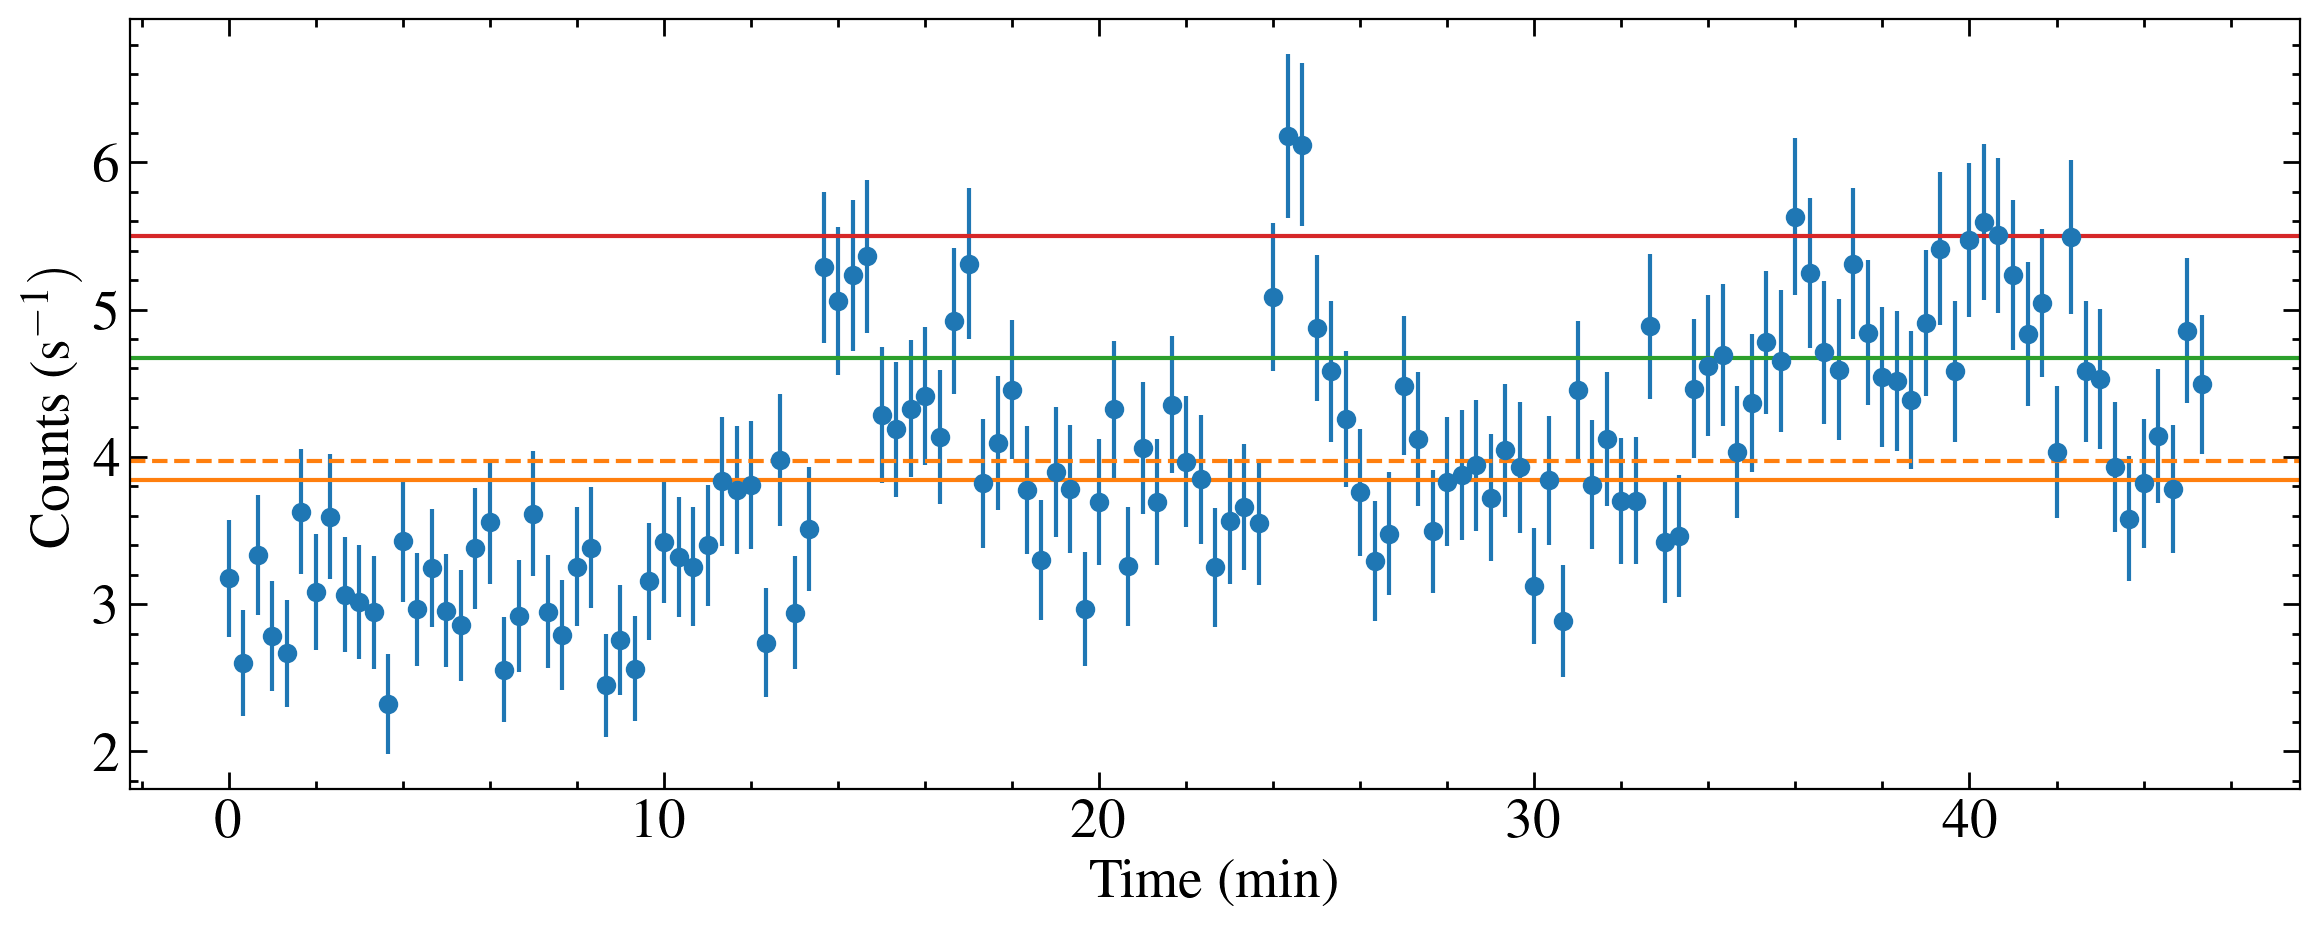

GJ699
0.6235689463672923 0.6717902265976508 1.0773311123193028 7.178026461411914


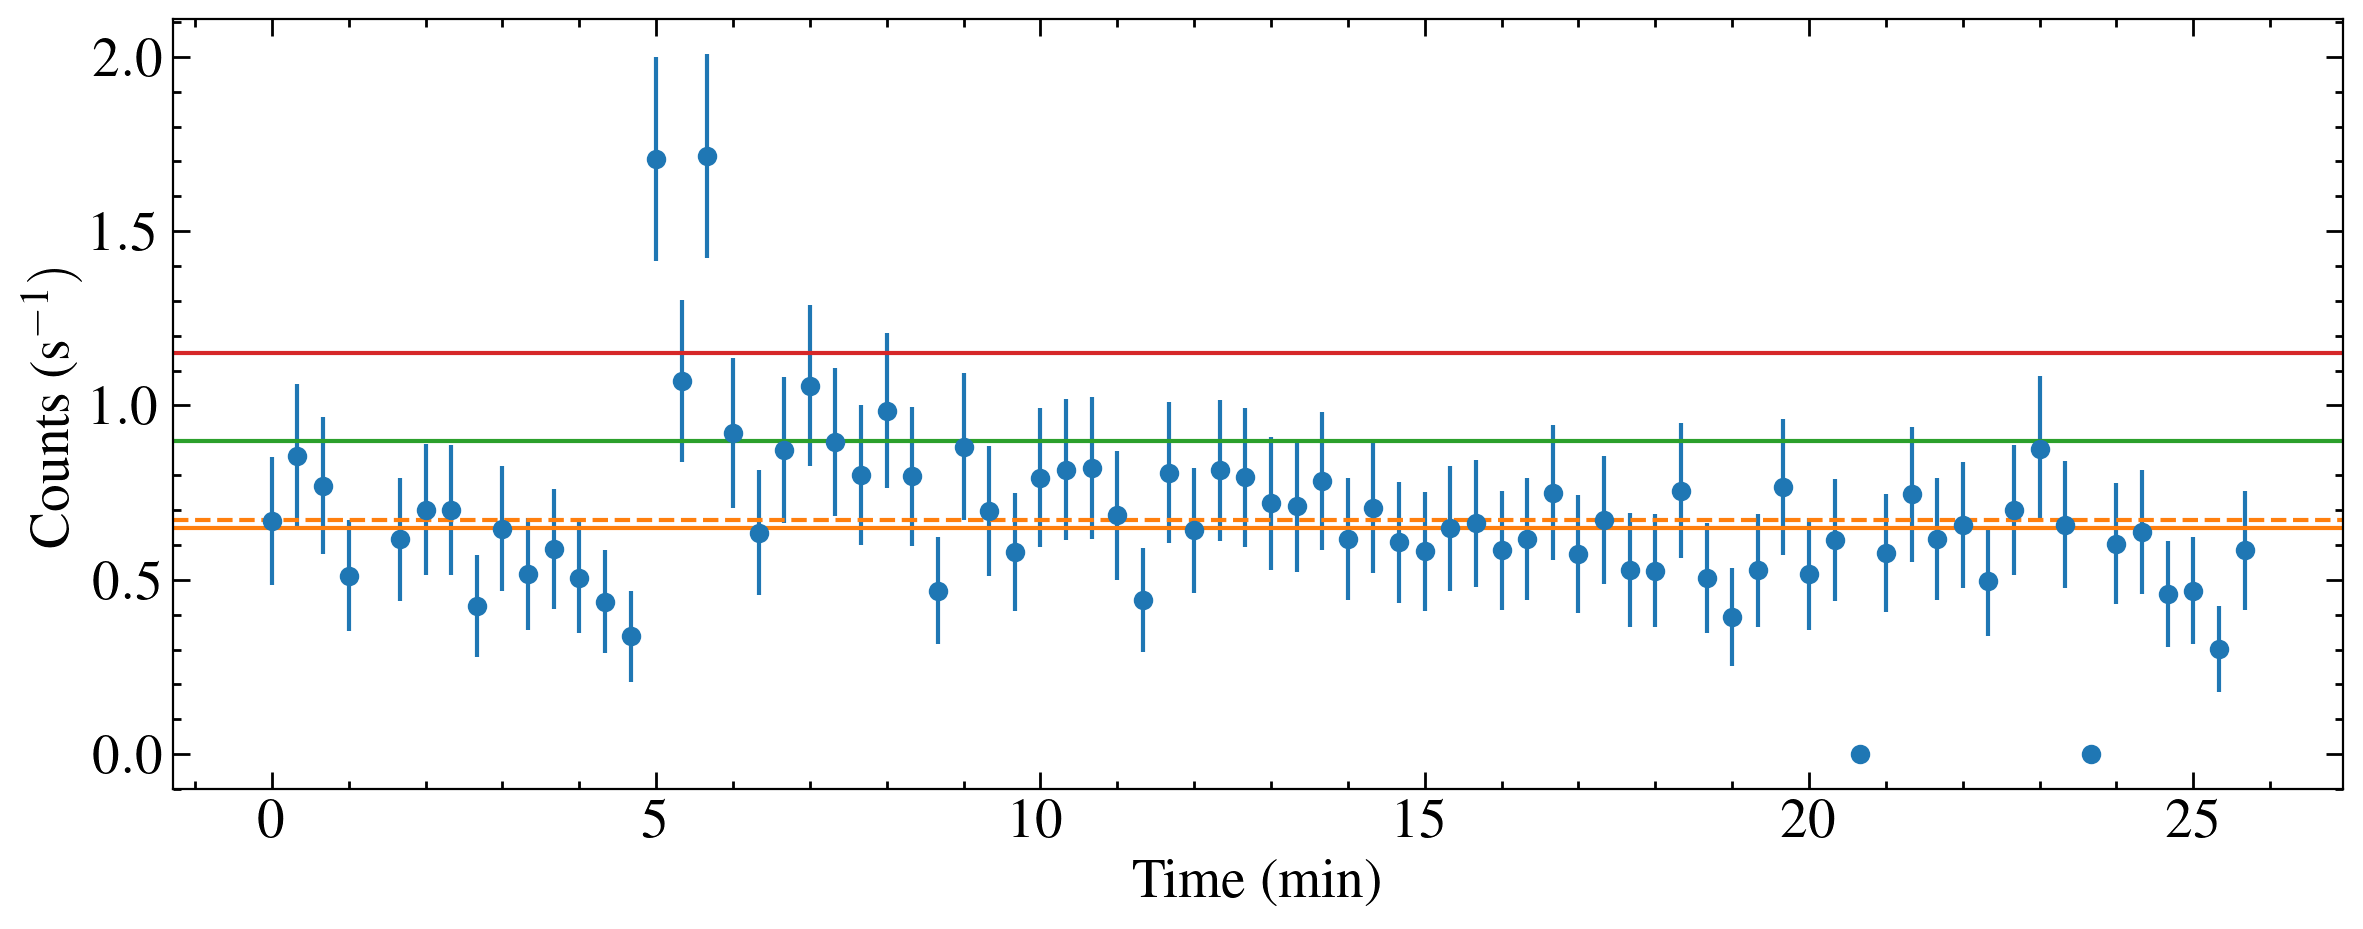

GJ699
0.7040431930891591 0.7713994888348469 1.0956706866948687 8.731700852877863


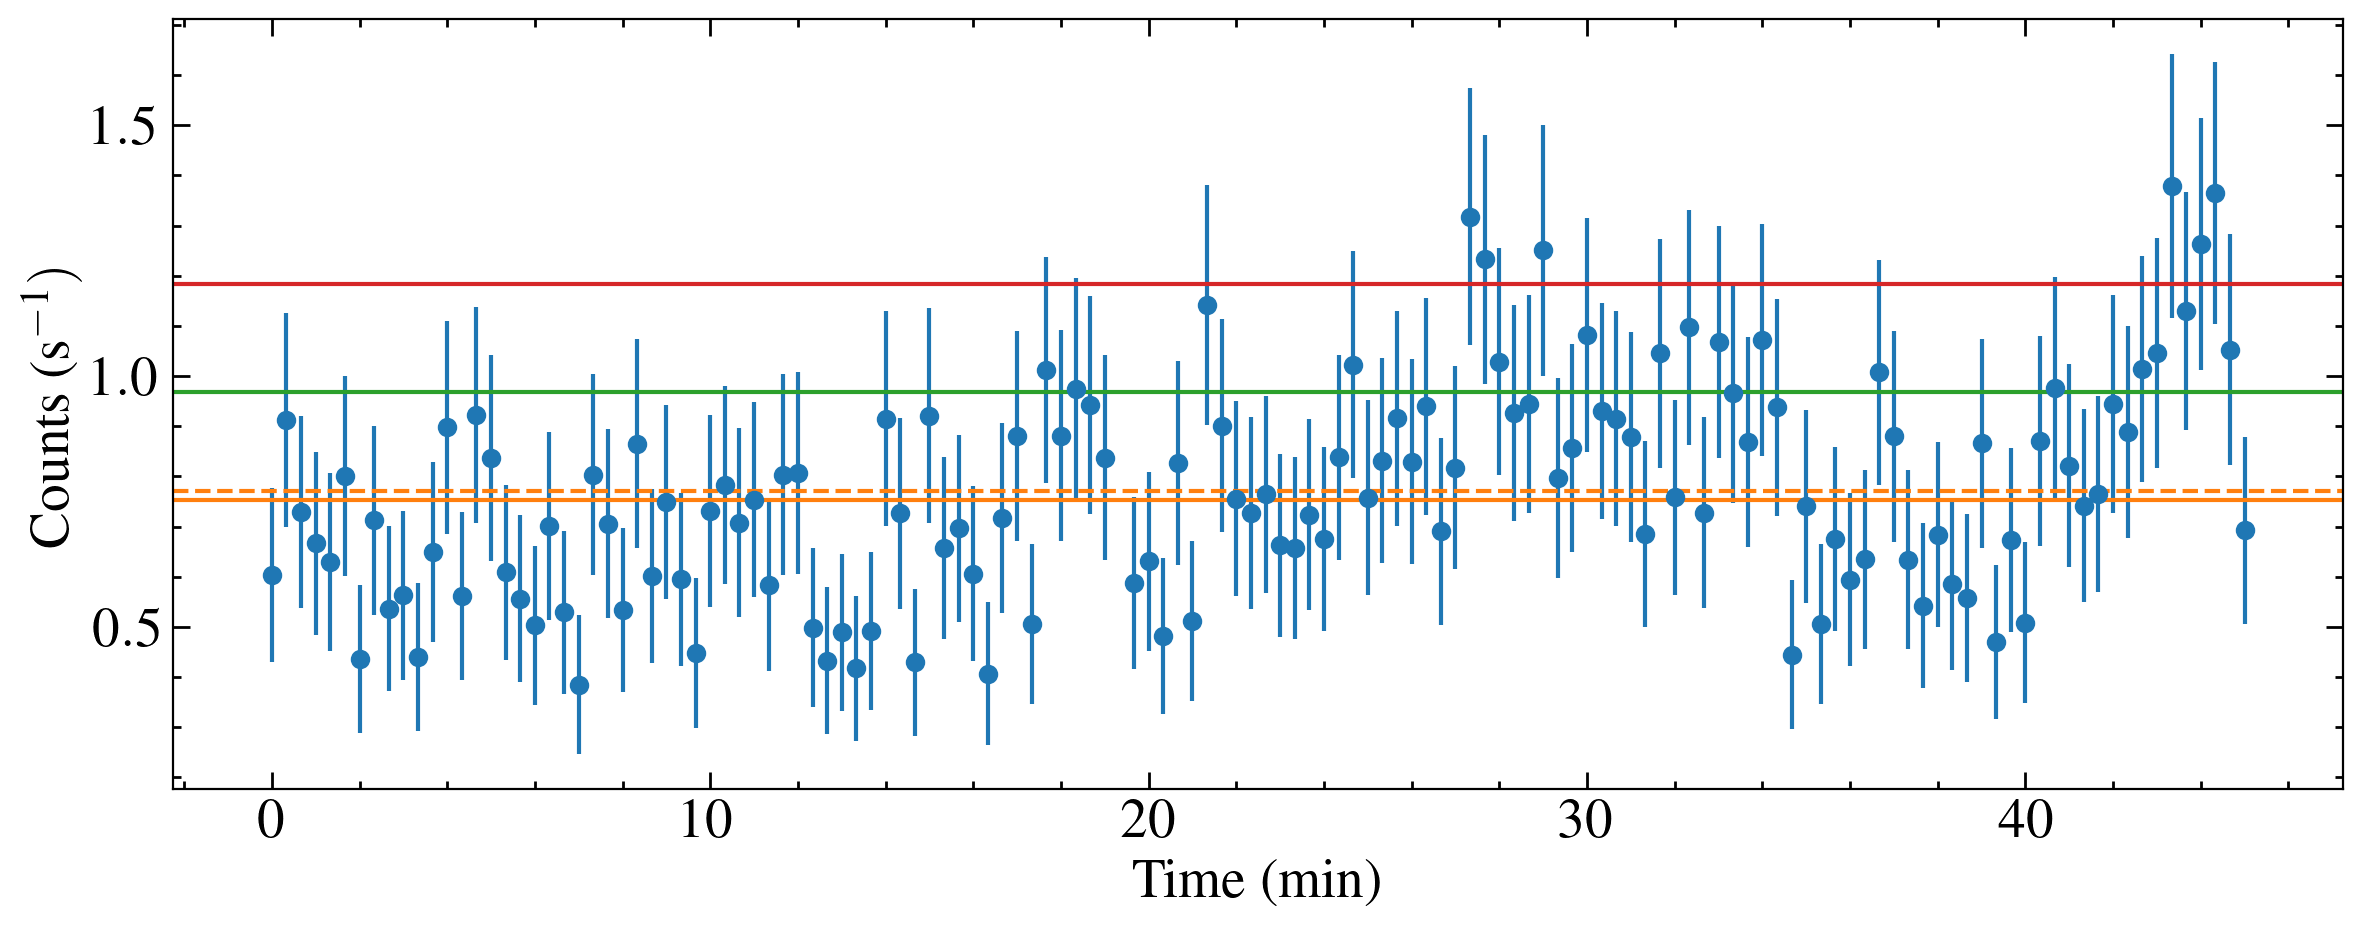

GJ699
0.9522368333341985 1.2973553716412456 1.3624293098373814 26.60169648586323


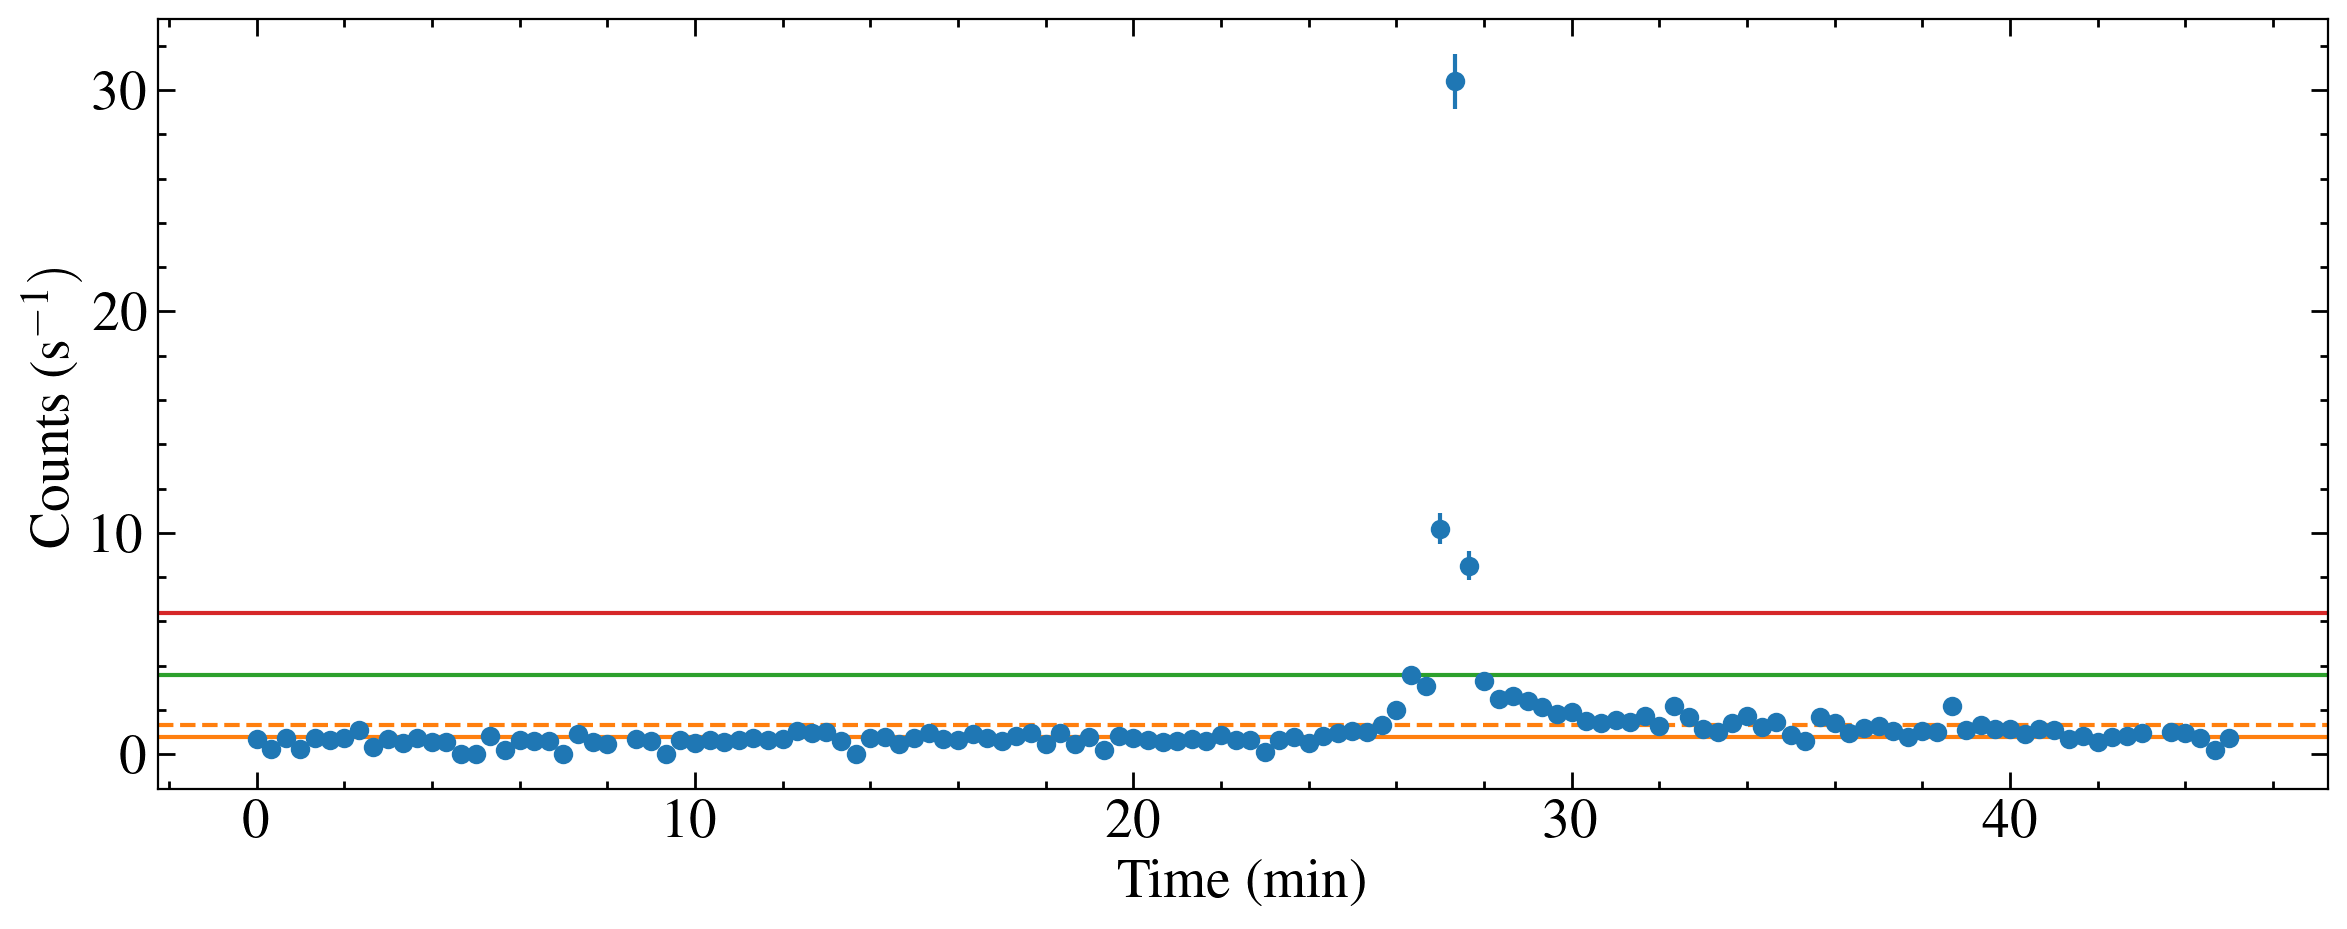

LHS-2686
0.29948205318478216 0.40124526105418246 1.3397973494144966 25.361846667556936


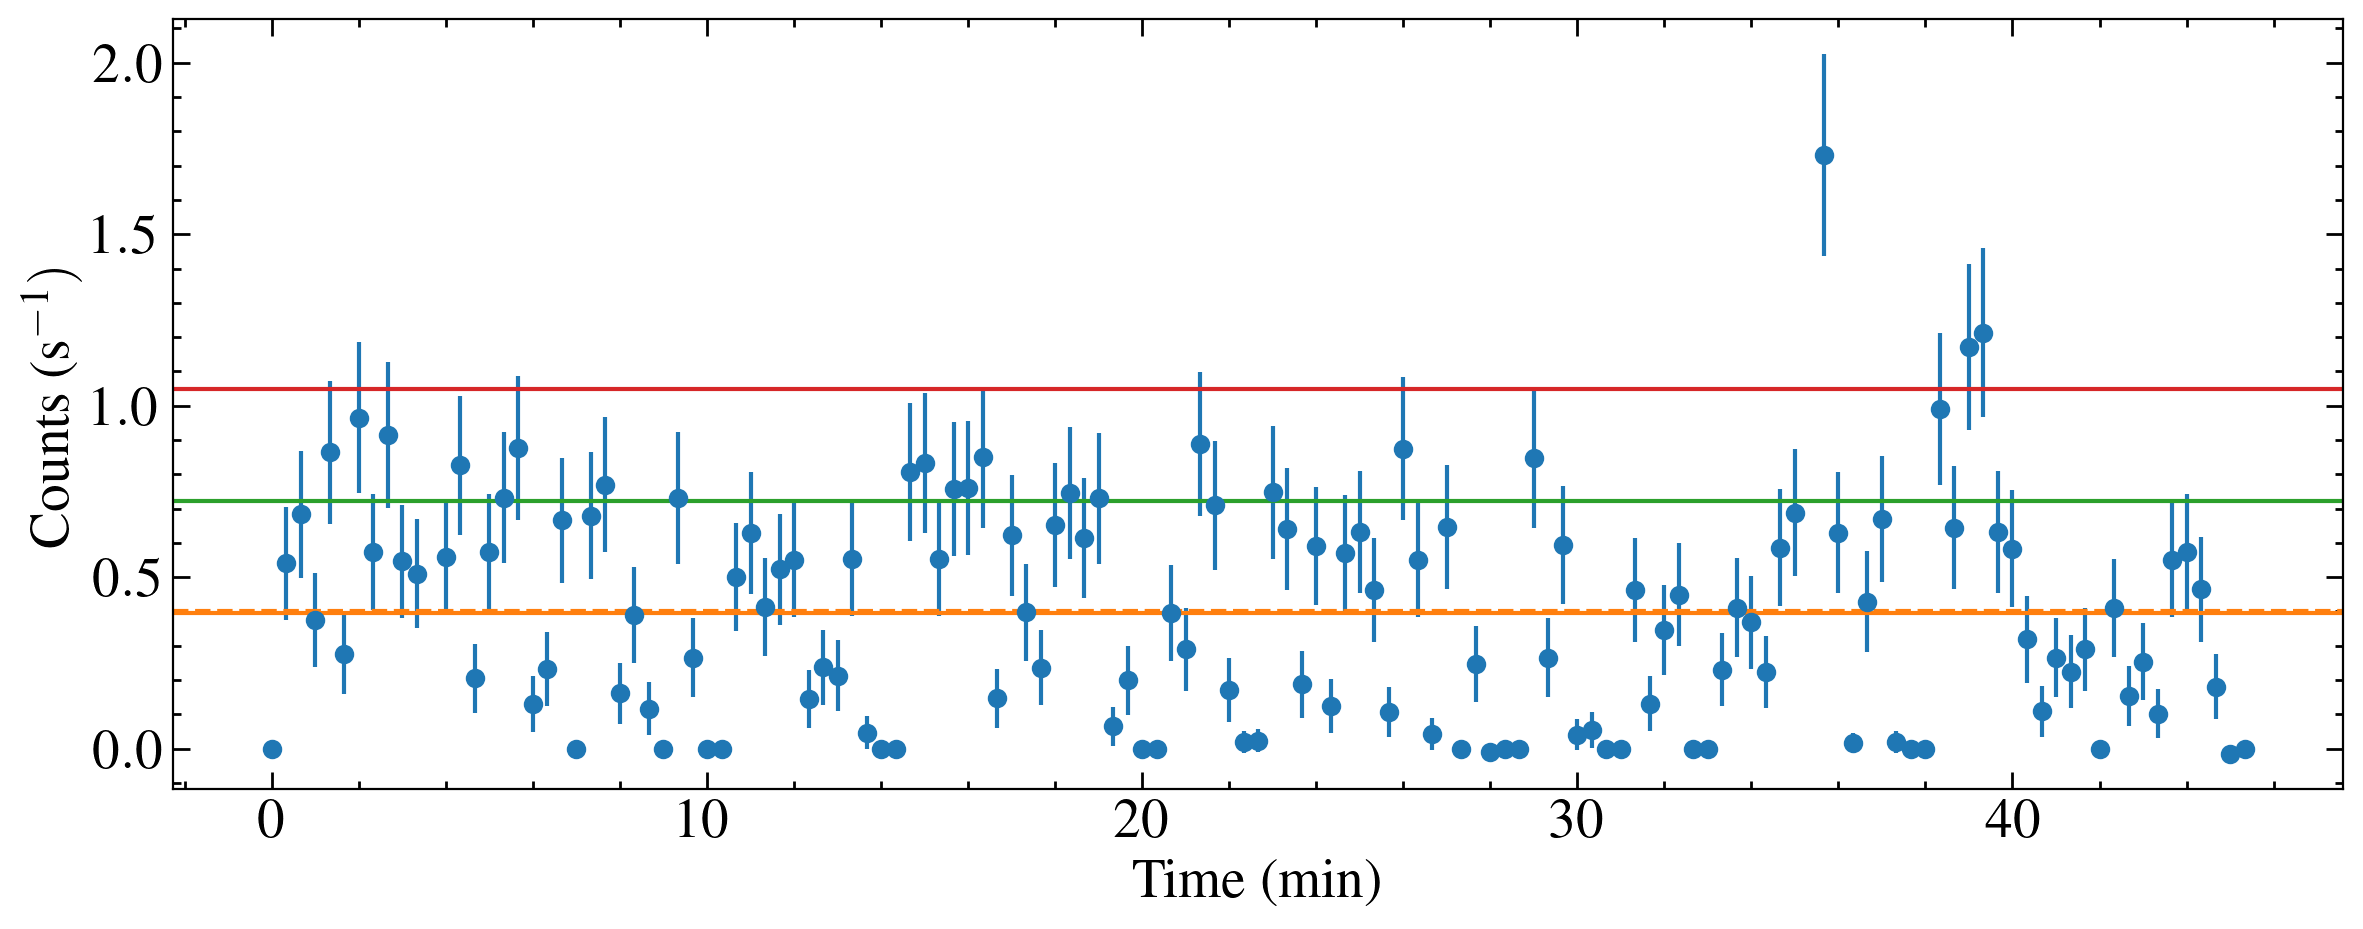

LHS-2686
0.13936917767679216 0.2524145493775167 1.81112175292363 44.78560050500552


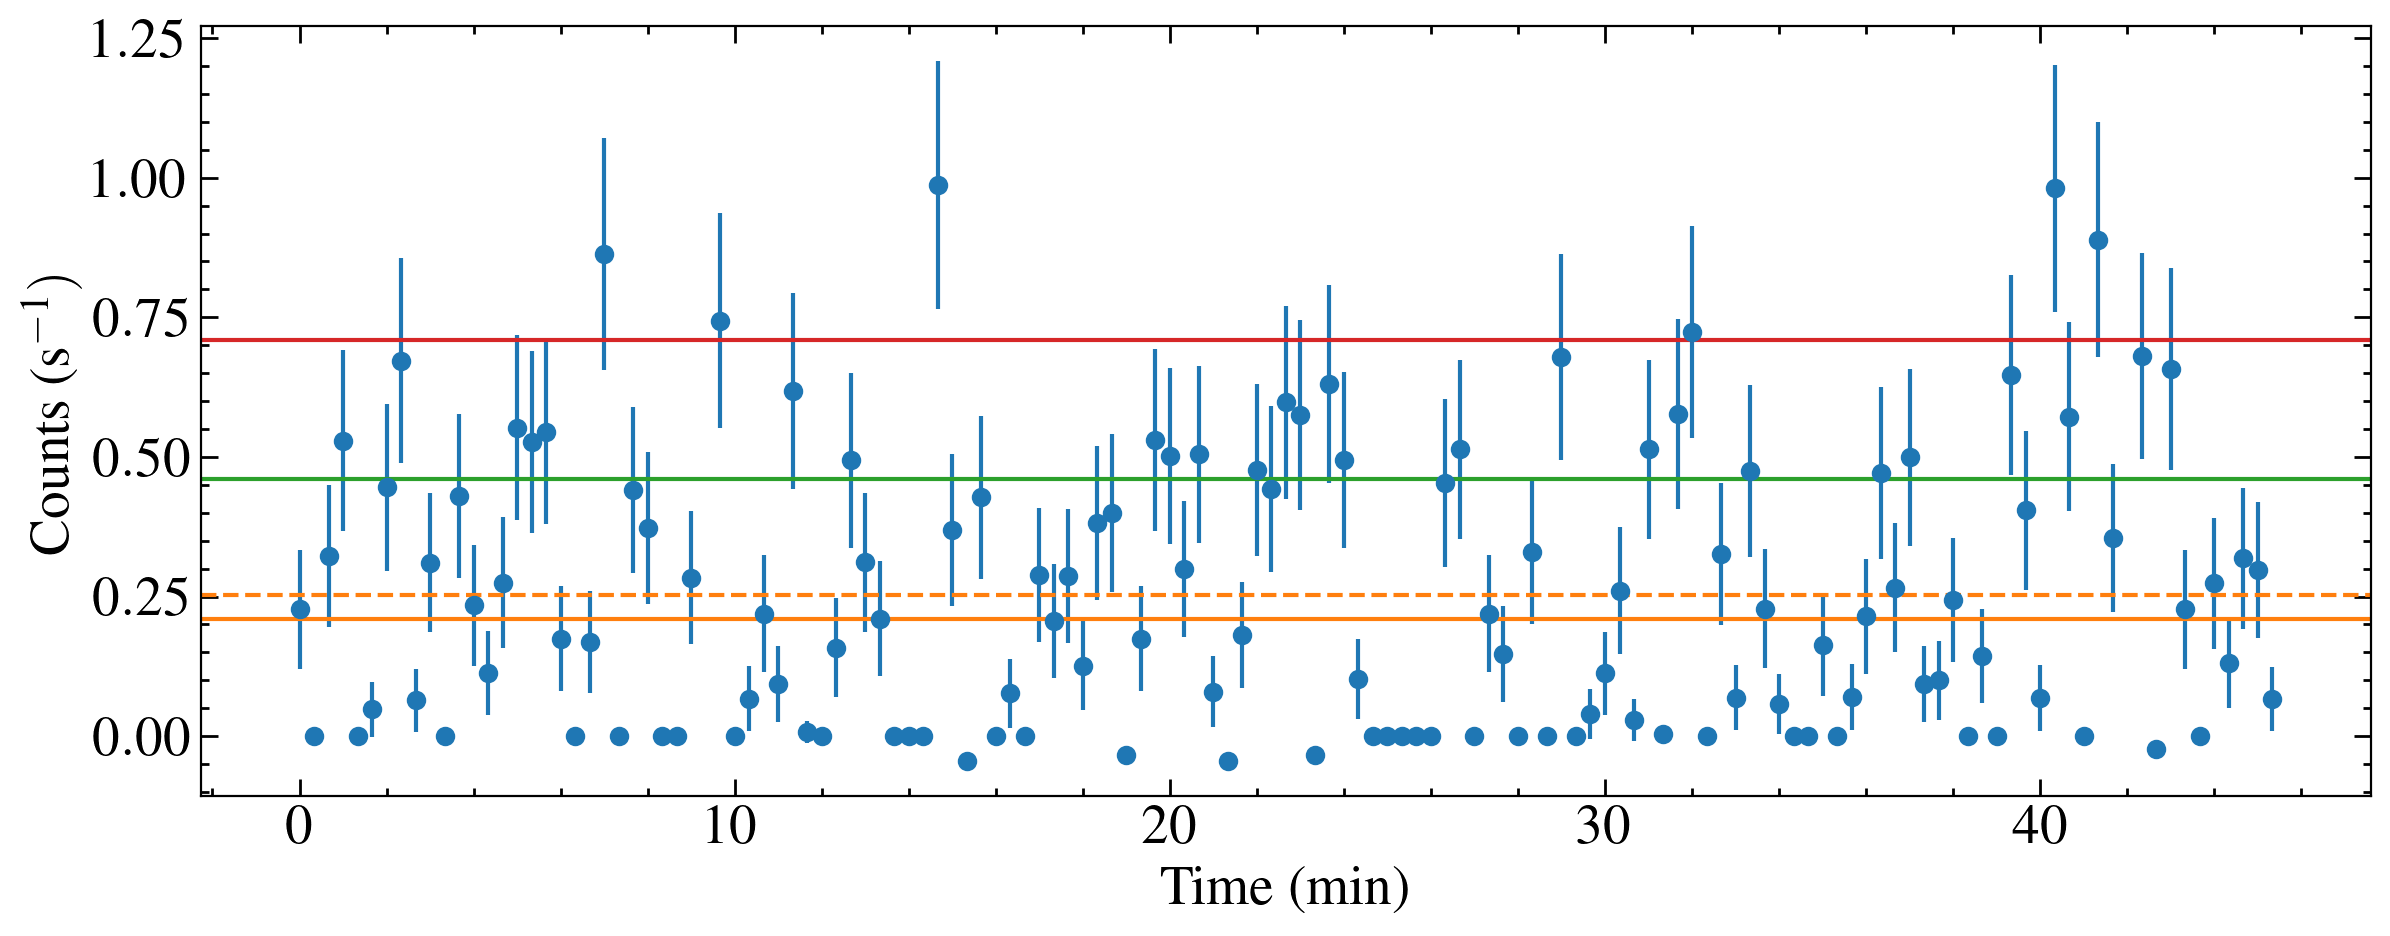

LHS-2686
0.4451409721317254 1.1210116812646014 2.5183295887058303 60.29113883723615


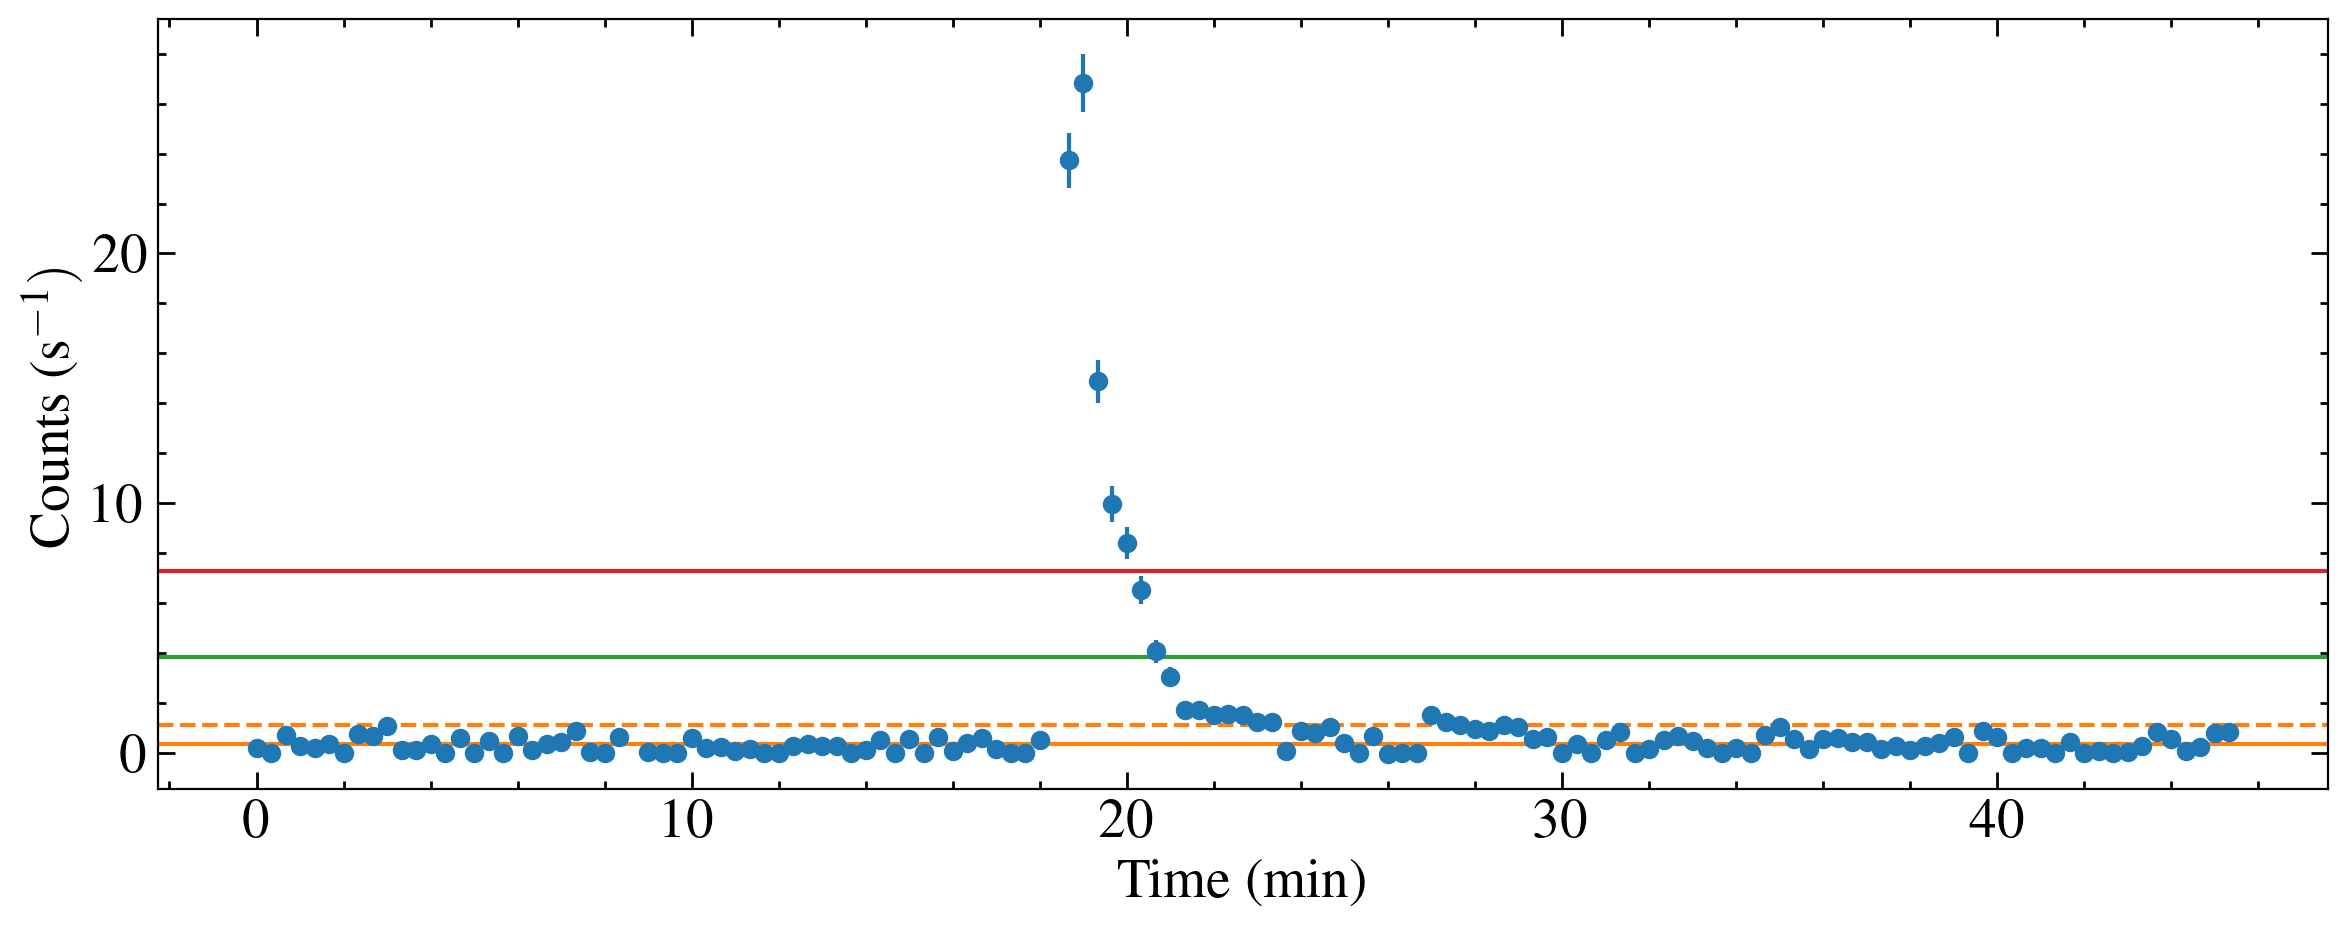

LHS-2686
1.3400838941225992 1.4672364633995048 1.0948840366148545 8.666126588913976


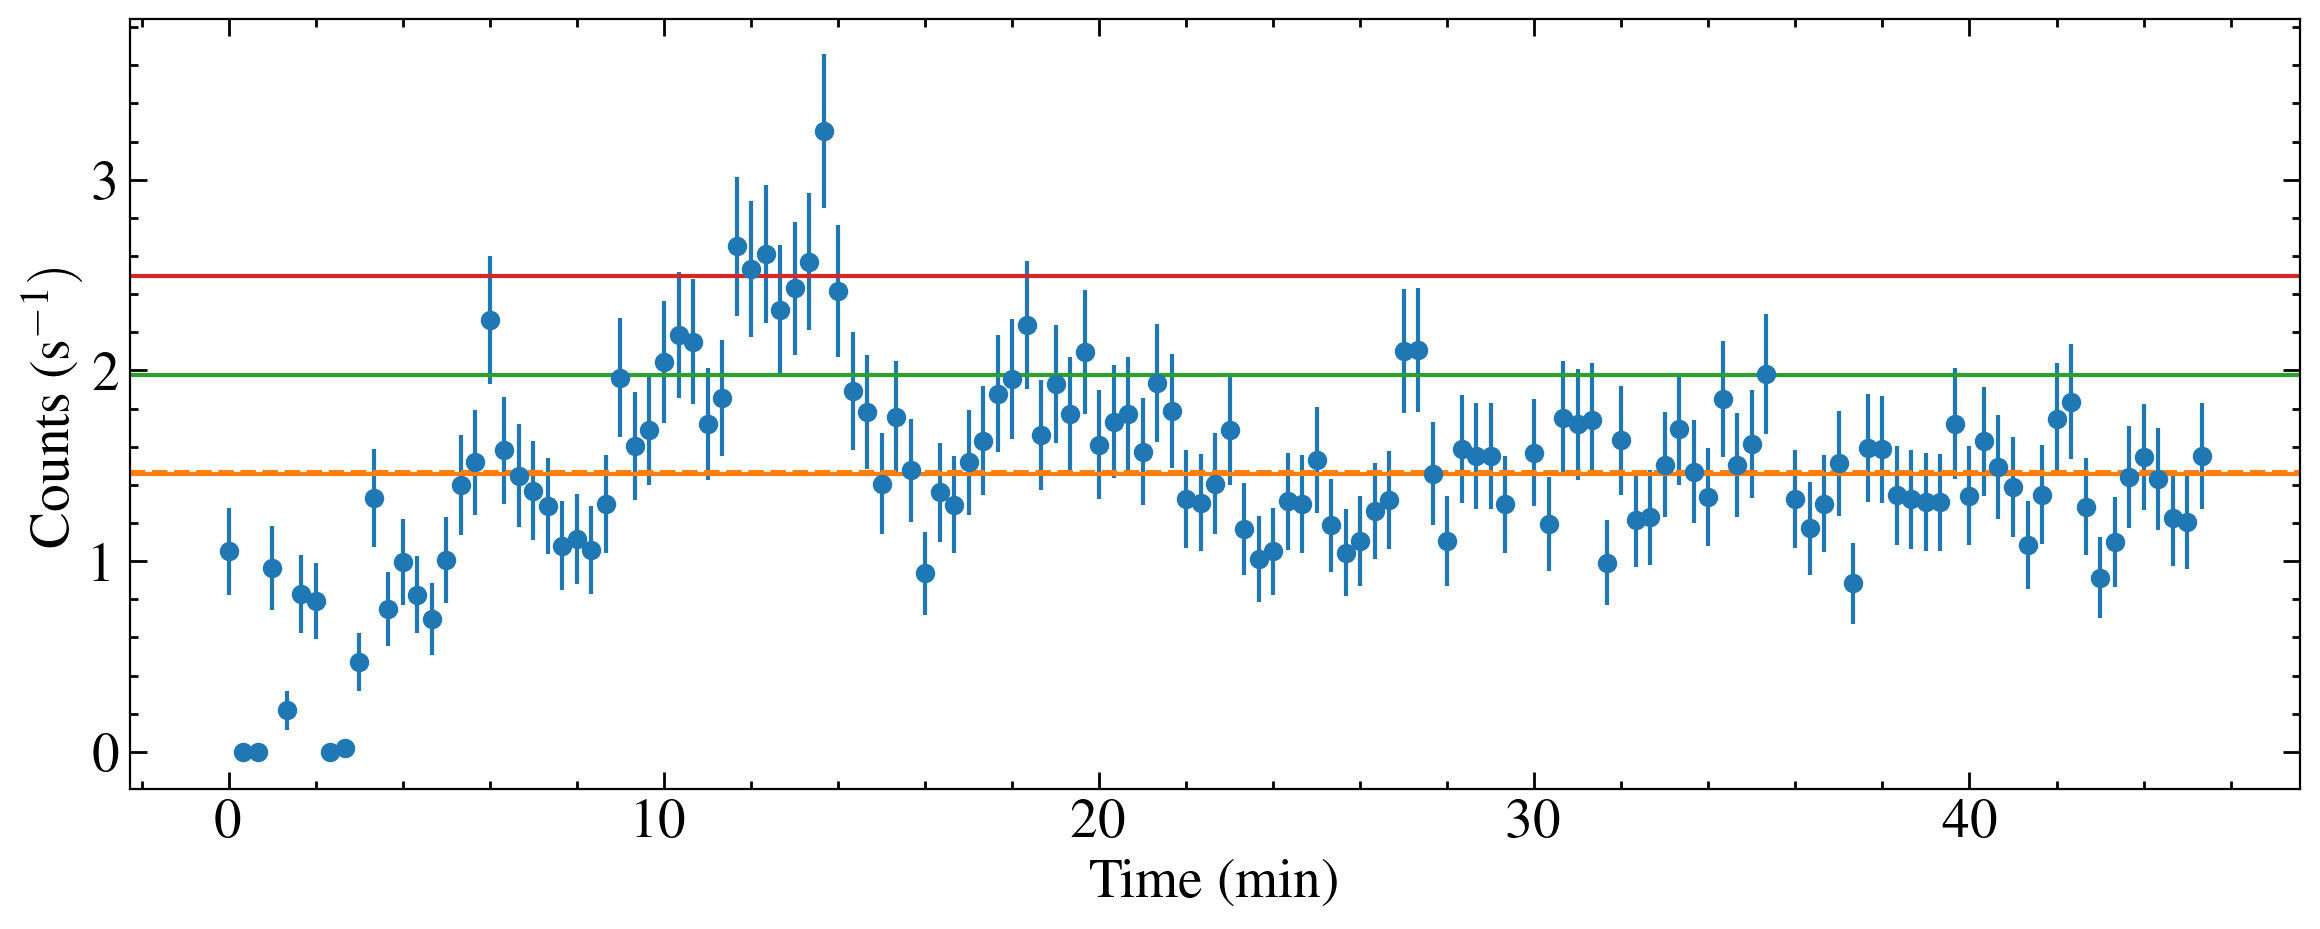

GJ676A
1.5767257165806459 1.6488946526546862 1.0457713953131613 4.3768069693142495


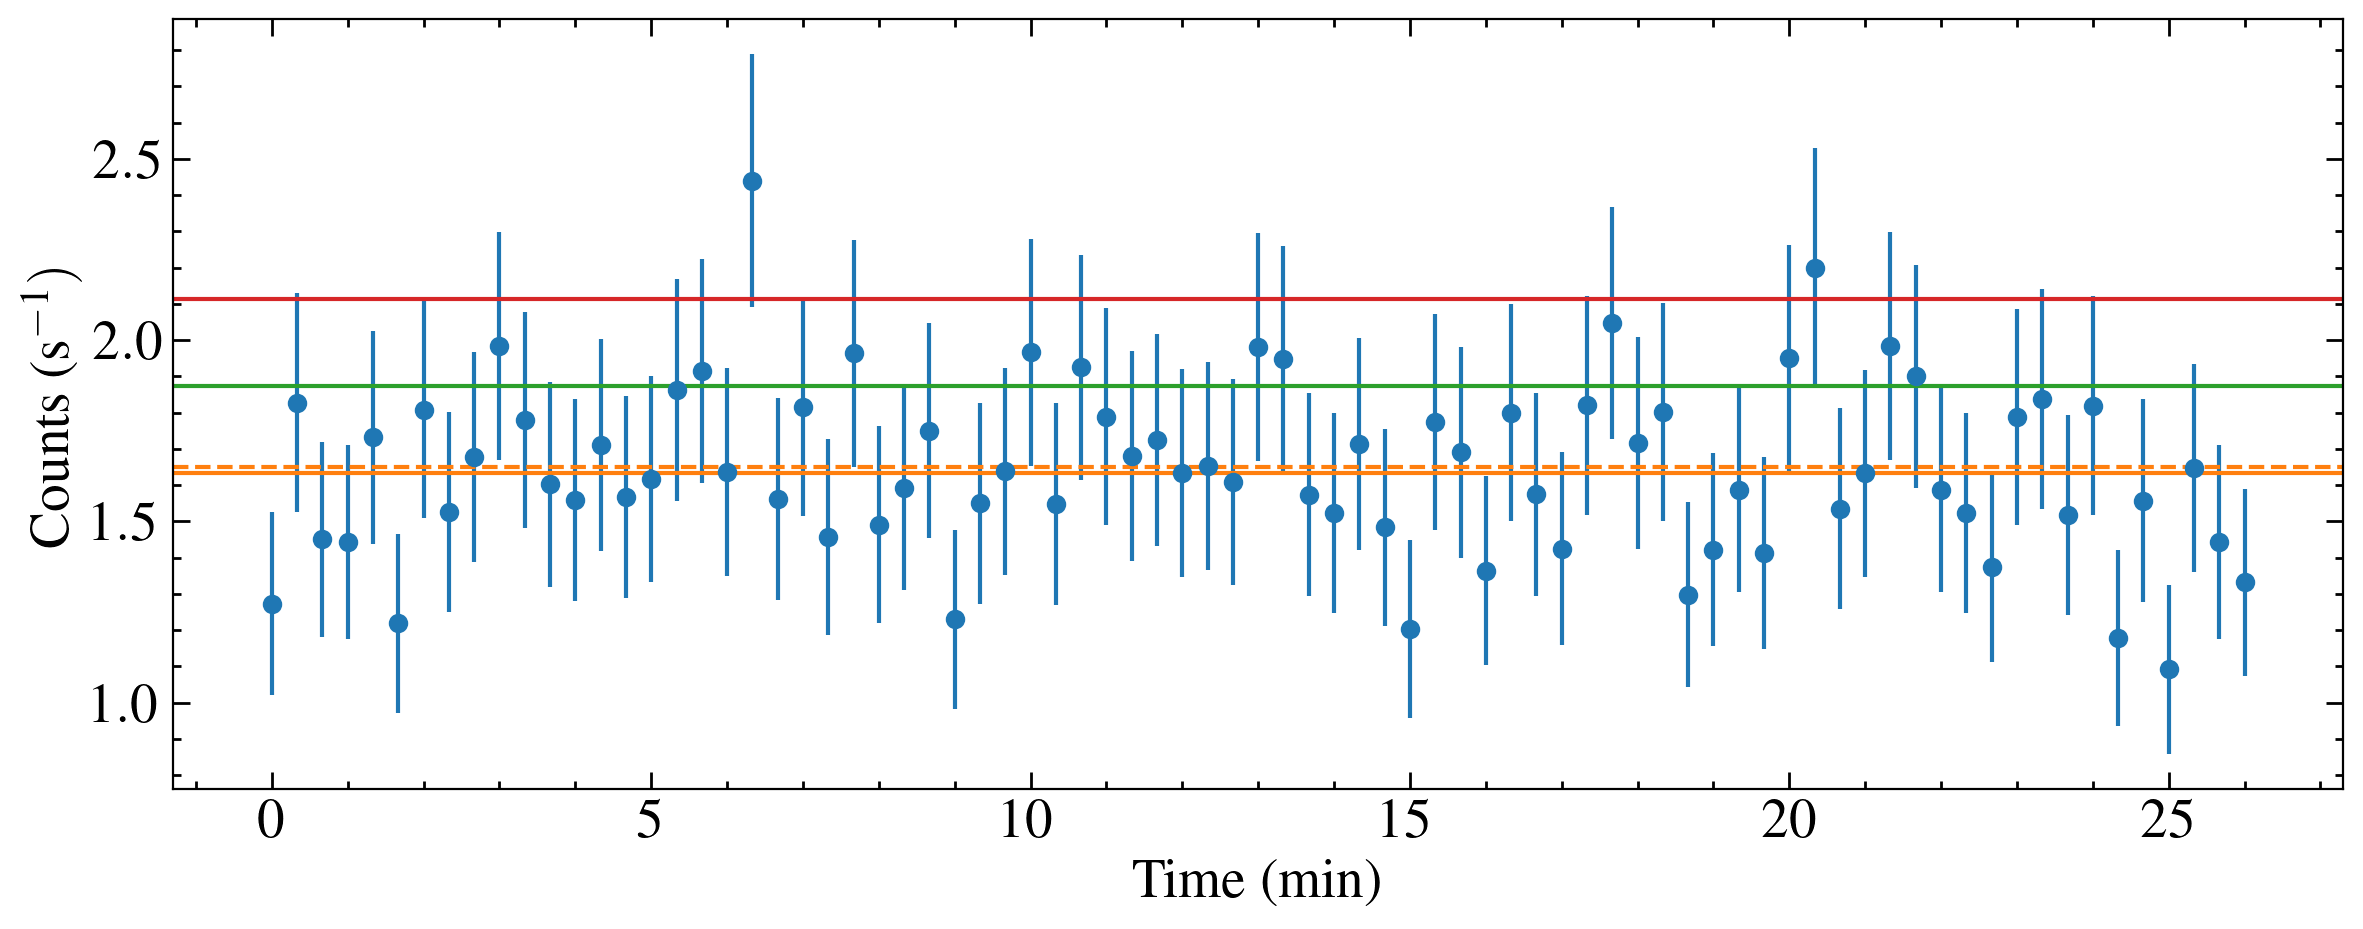

GJ676A
1.6186535636781885 1.701132103536758 1.0509550293585659 4.848450022610914


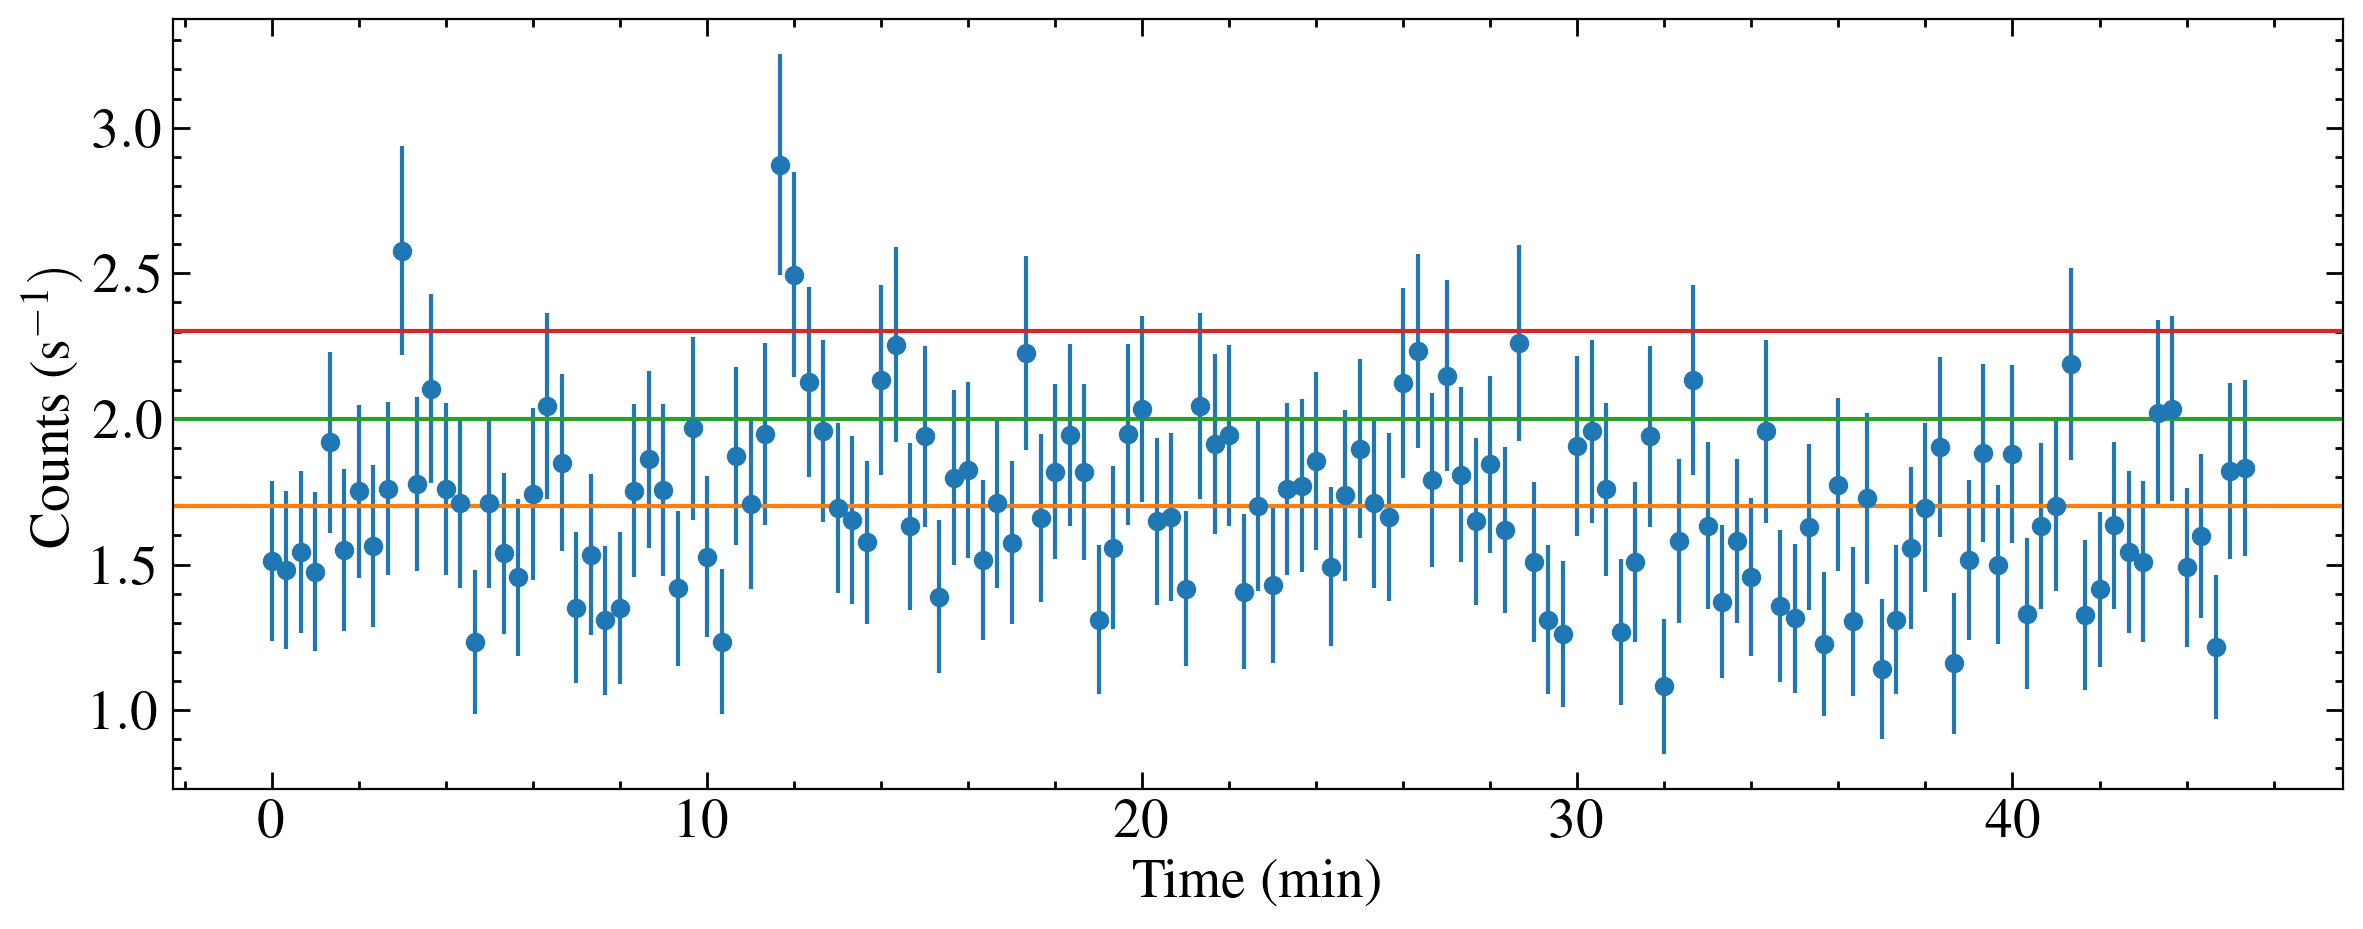

GJ676A
1.6153786039987283 1.7039726718717856 1.0548441508719693 5.199265770837635


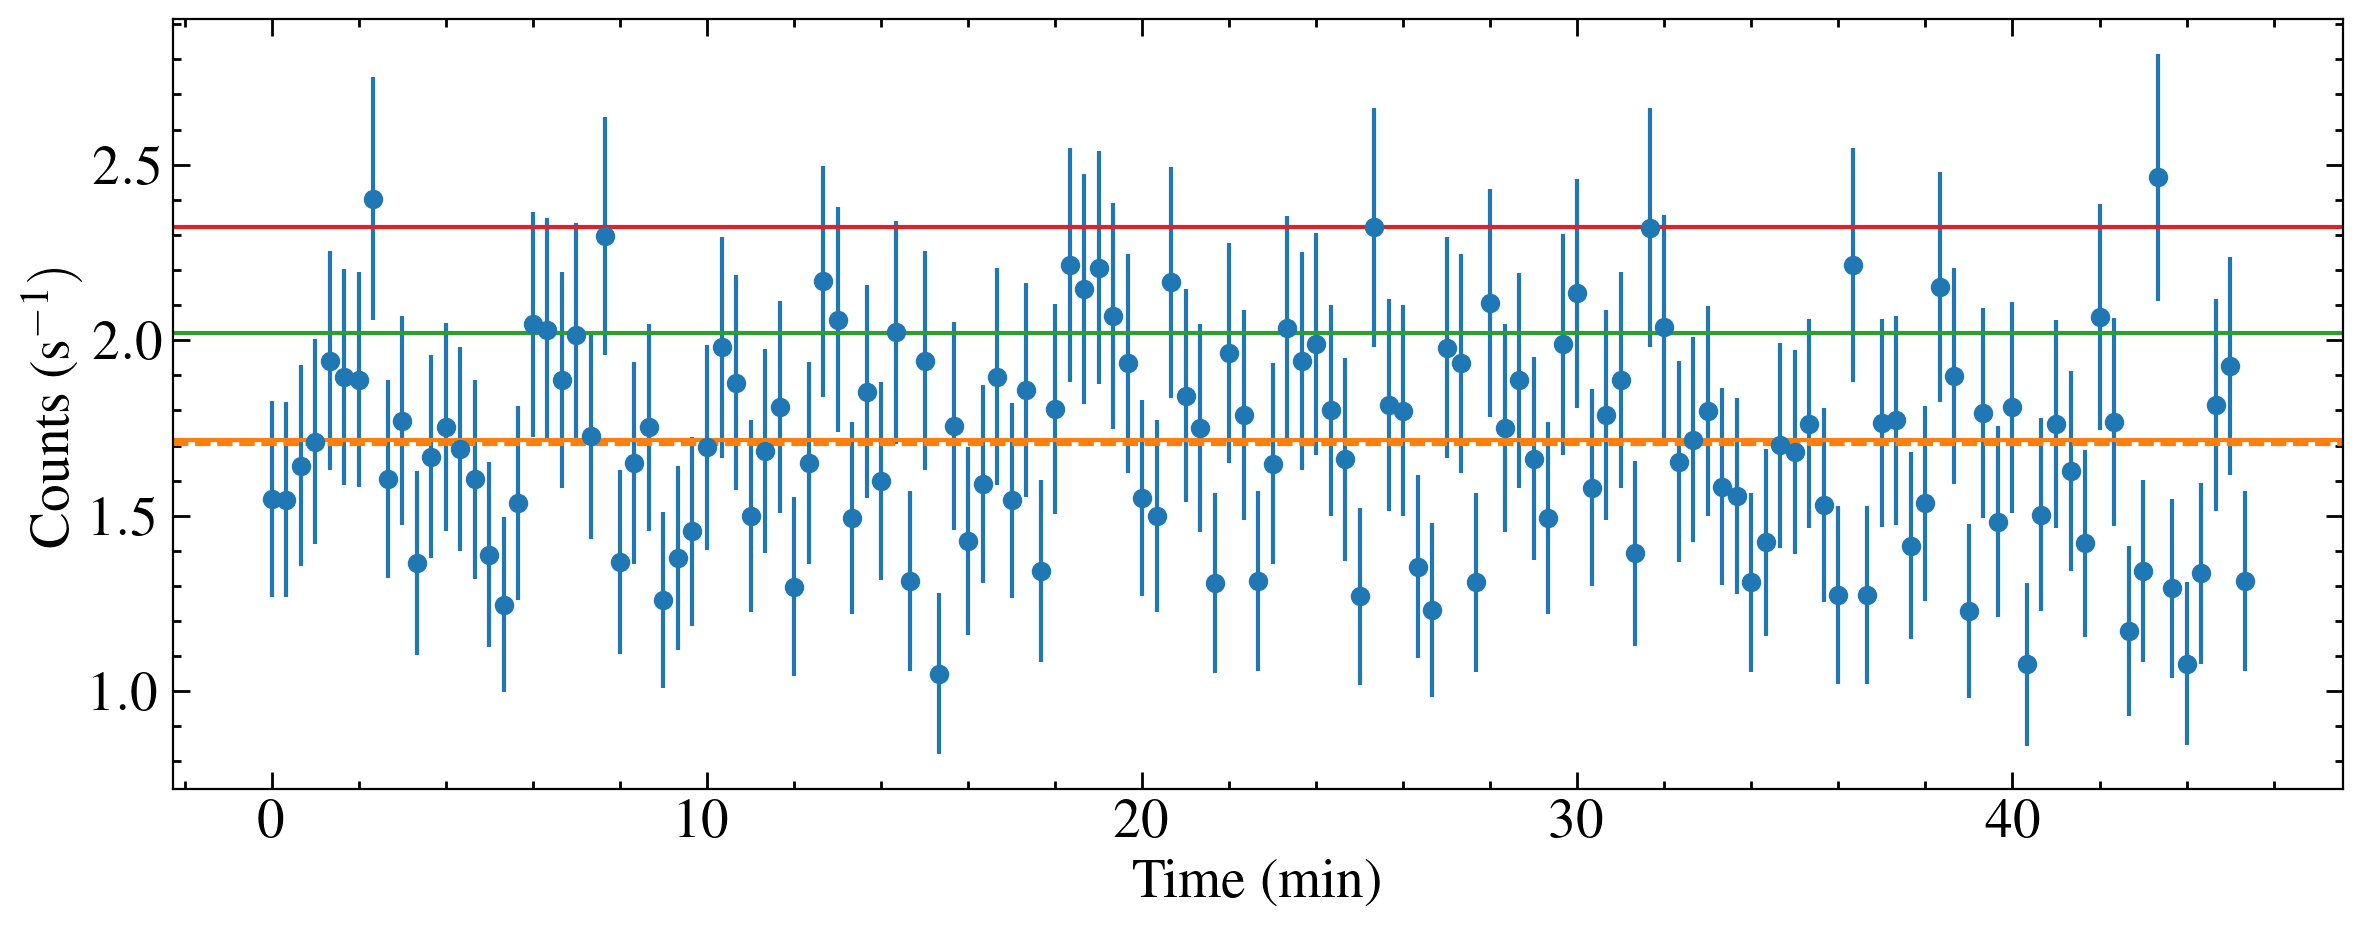

GJ676A
1.5484418723777242 1.6069131704251176 1.0377613774791605 3.6387341347090008


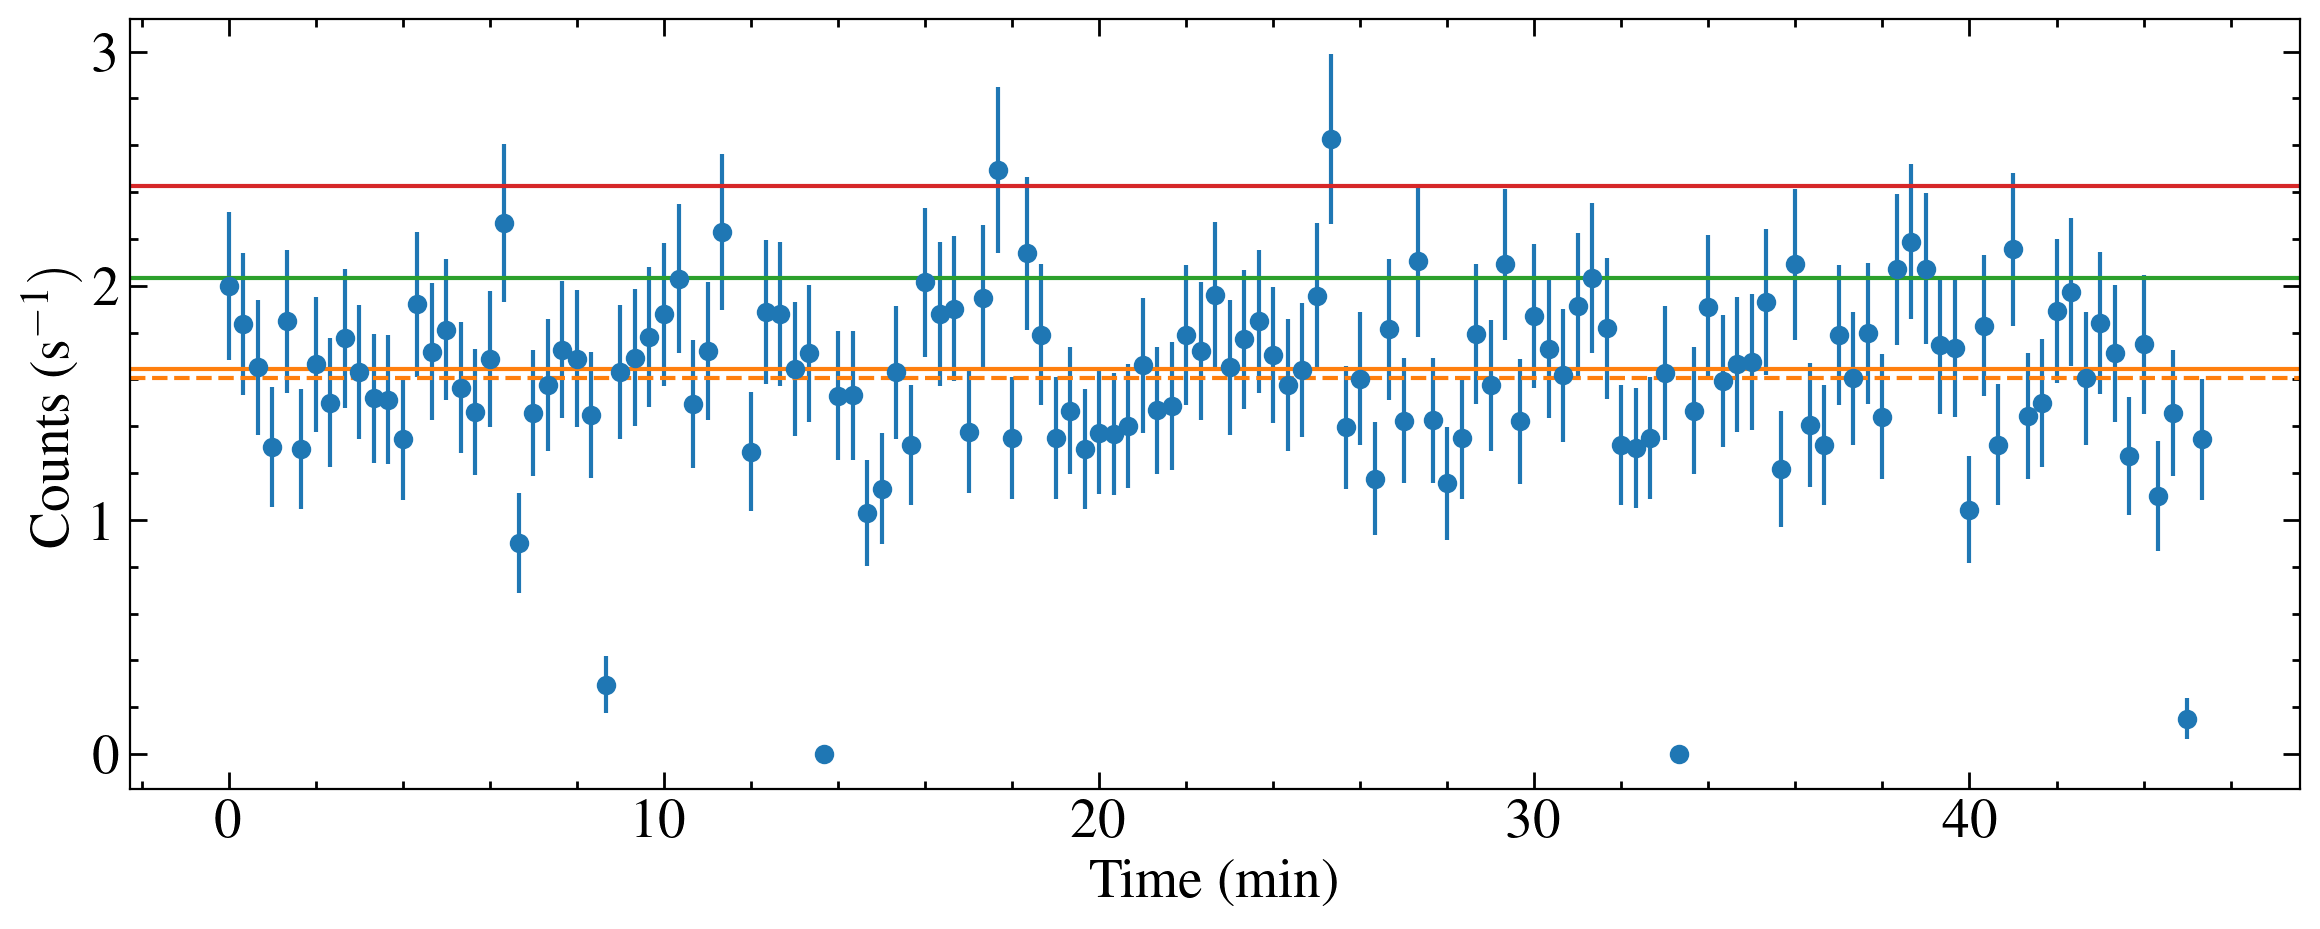

GJ676A
1.8302826445403502 2.0731403967220956 1.1326886603586495 11.714486513587556


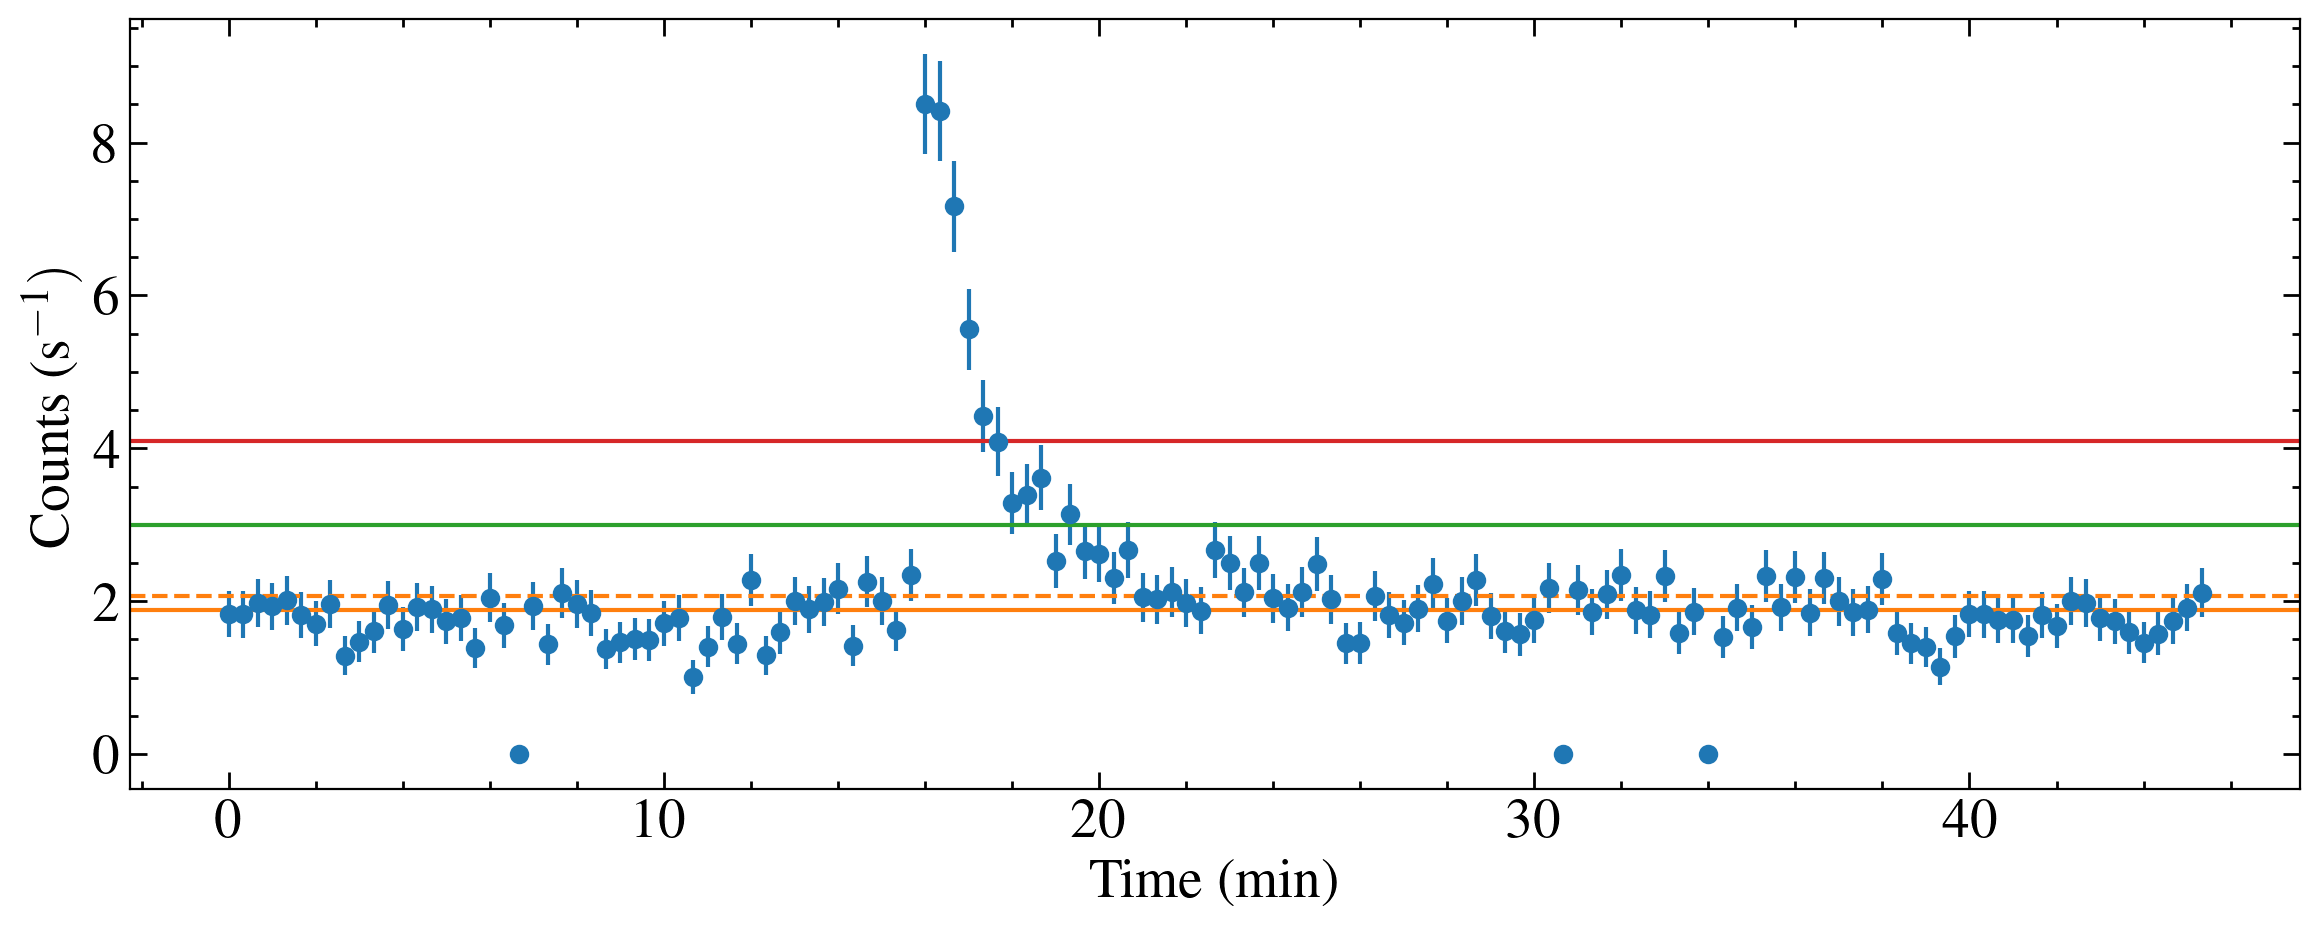

In [26]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

for x in new_x1ds:   
    fig, ax = plt.subplots()
    hdul = fits.open(x)
    print(hdul[0].header['TARGNAME'])
    time = []
    flux = []
    error = []
    error_sqrt = []
    hdul = fits.open(x)
    band = [1230, 1700]
    for ext in hdul[1::]:
        hdr = ext.header
        ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
        time.append(ti)
        data = ext.data
        if grating == 'e140m': 
            w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
            w, f, e , dq = echelle_coadd_dq(w, f,e, dq, nclip =10, find_ratio =False)
        else:
            data = data[0]
            w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
        #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
        w0, w1 = wavelength_edges(w) 
        mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
        w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
        fi = np.sum(f*(w1-w0))
        ei = (np.sum(e**2 * (w1-w0)**2))**0.5
        flux.append(fi)
        error.append(ei)
        ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
        error_sqrt.append(ei) #better approach for these low-signal spectra
        
        
    
    hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error_sqrt, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')

    mean, med, std = np.mean(flux),np.median(flux), np.std(flux) 
    ax.axhline(np.median(flux), c='C1')
    ax.axhline(mean, c='C1', ls ='--')
    ax.axhline(np.median(flux)+std, c='C2')
    ax.axhline(np.median(flux)+2*std, c='C3')

    #estimate of flux w/wo flares , 1 sigma is a good cut off
    flaremask = (flux < (med +std))
    noflare_mean= np.mean(flux[flaremask])
    flare_mean= np.mean(flux)
    print(noflare_mean, flare_mean,flare_mean/noflare_mean, ((flare_mean-noflare_mean)/flare_mean)*100 )
    

    
    
    plt.show()
    
    # print(hdul[0].header['ROOTNAME'])
    # for ext in hdul[1::]: #spectra in every extension after the first
    #     data = ext.data[0]
    #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
    #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
    #     ax.set_ylim(0, 1.1*max(data['FLUX']))
    #     # plt.show()
    # hdul.close()
    # plt.show()
    

In [17]:
# plt.plot(w, f)
# plt.plot(w, e)

nice flare in LHS 2686, quick look at TESS TIC 198511612. Nothing much happening

In [18]:
# import lightkurve as lk
# search_result = lk.search_lightcurve('TIC 198511612')
# search_result

In [19]:
# lc120s = []
# for i, sr in enumerate(search_result):
#     if sr.exptime[0].value == 120 and sr.author[0] == 'SPOC':
#         # print(i)
#         lc120s.append(i)
# #         print(sr./#[0])
#         lc = sr.download(download_dir='mastDownload/')
#         lc.remove_outliers().plot()
# # print(lc120s)

In [20]:
savepath = '/media/david/2tb_ext_hd/hddata/mega_muscles/flare_search/light_curves/'

GJ649


/tmp/ipykernel_199270/172561336.py:37: RuntimeWarning: invalid value encountered in scalar power
  ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts


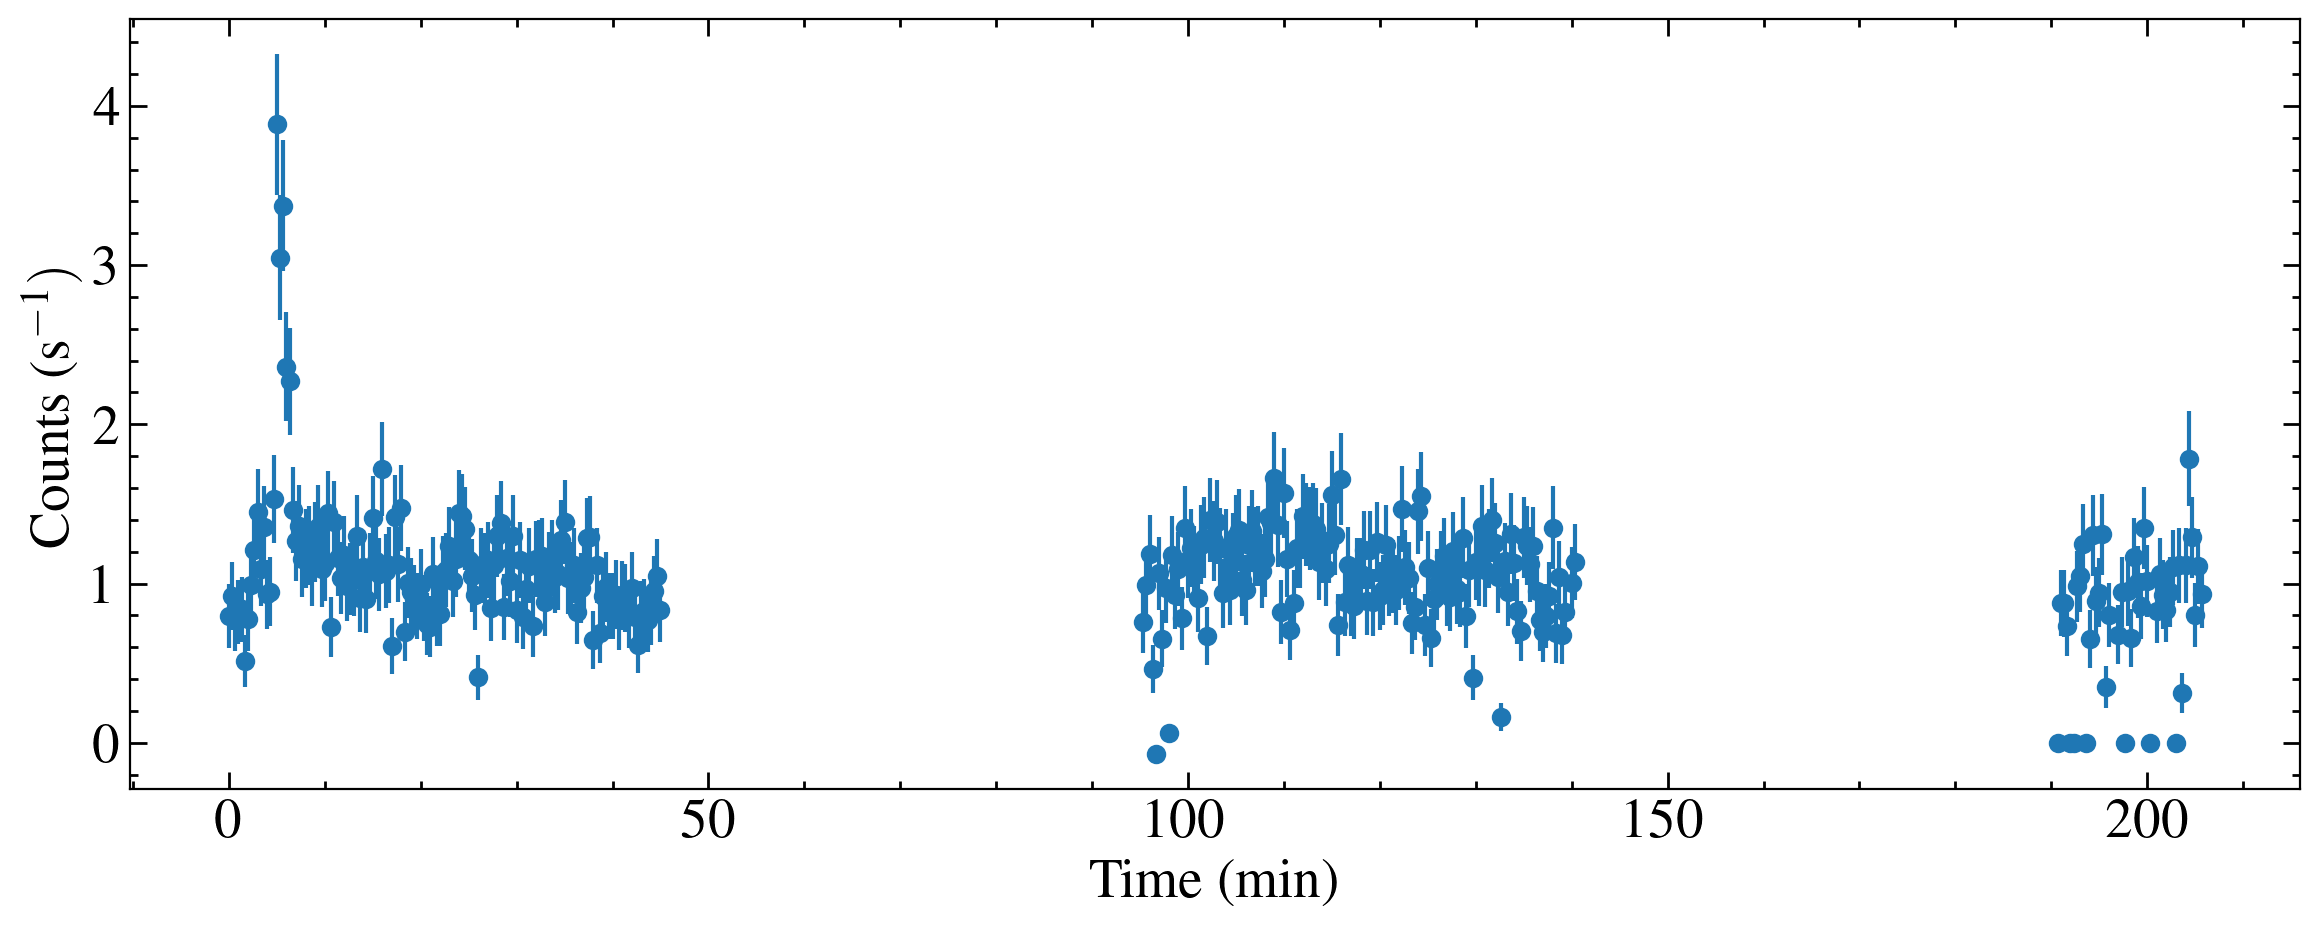

GJ674


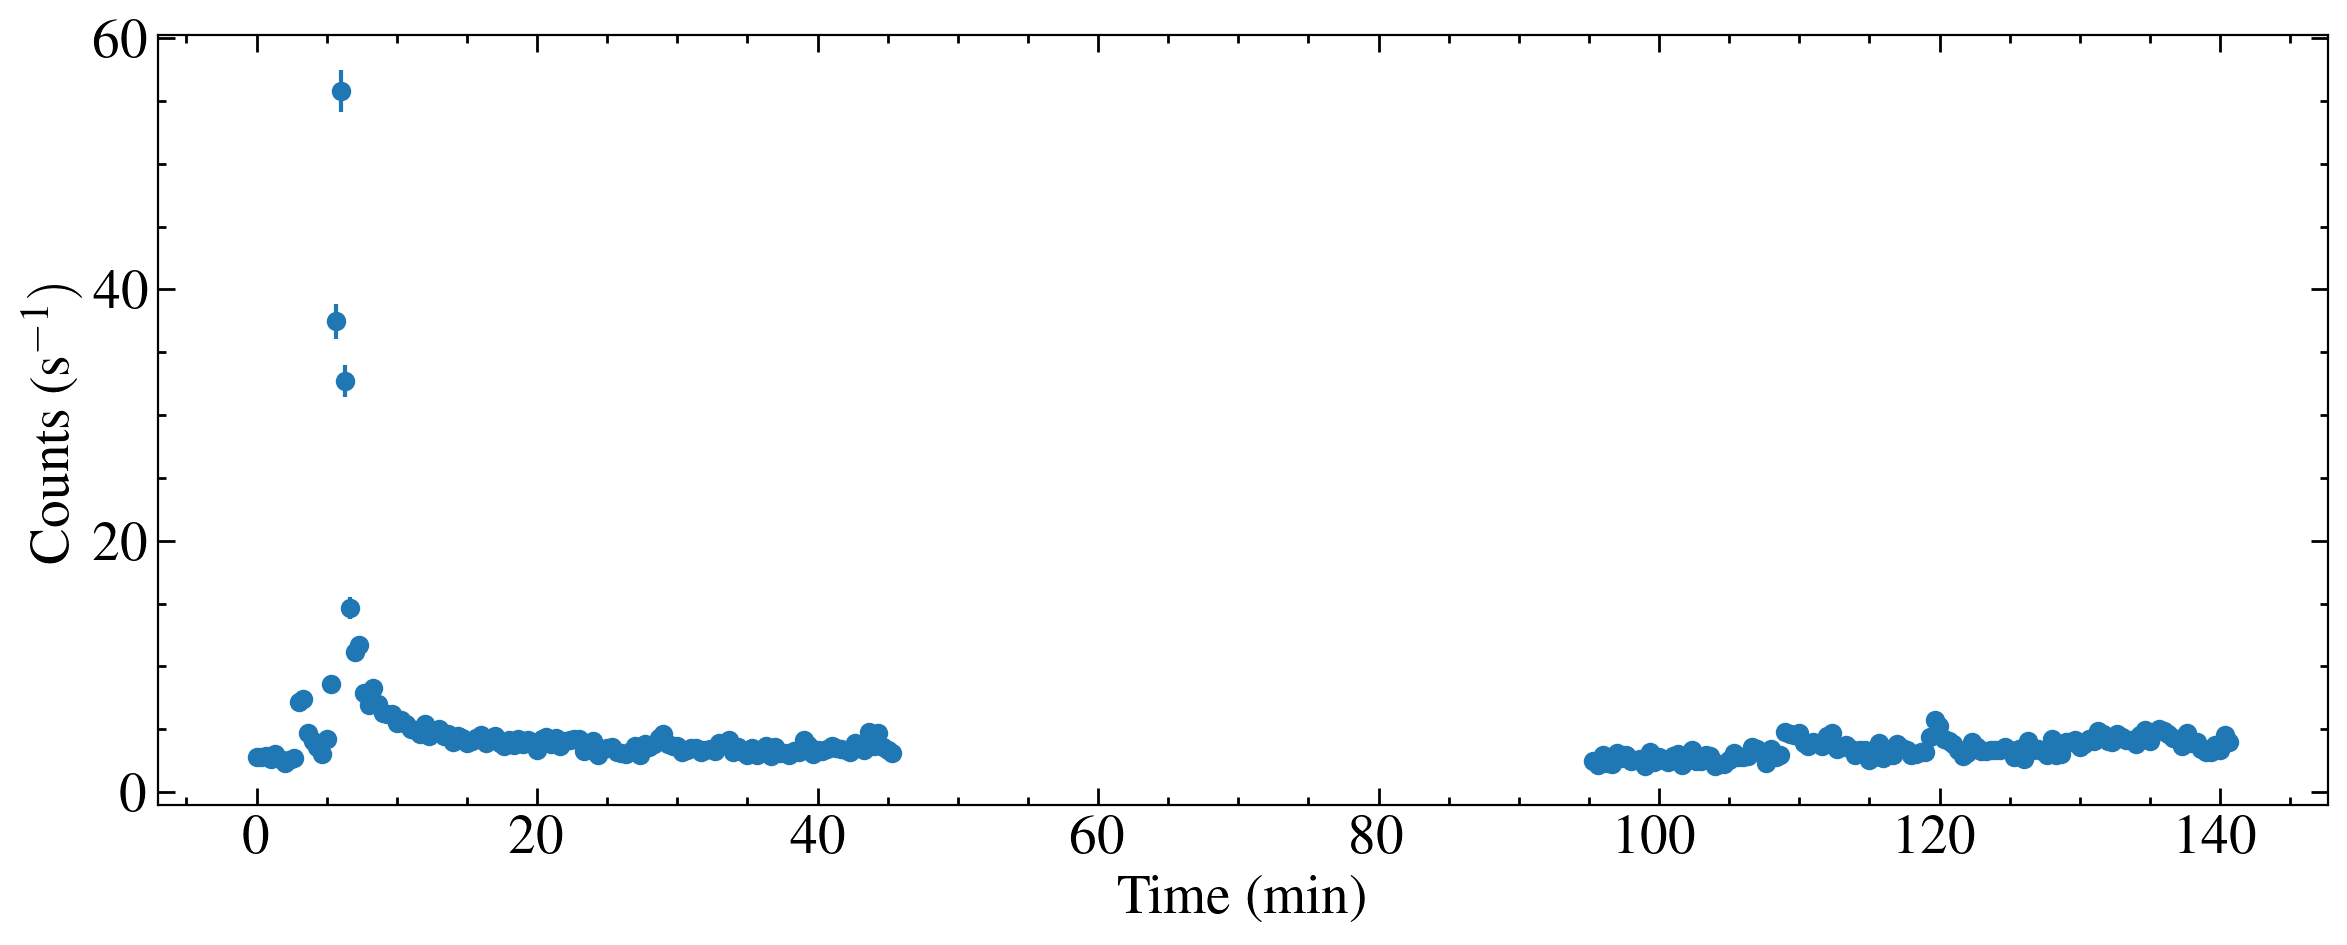

GJ676A


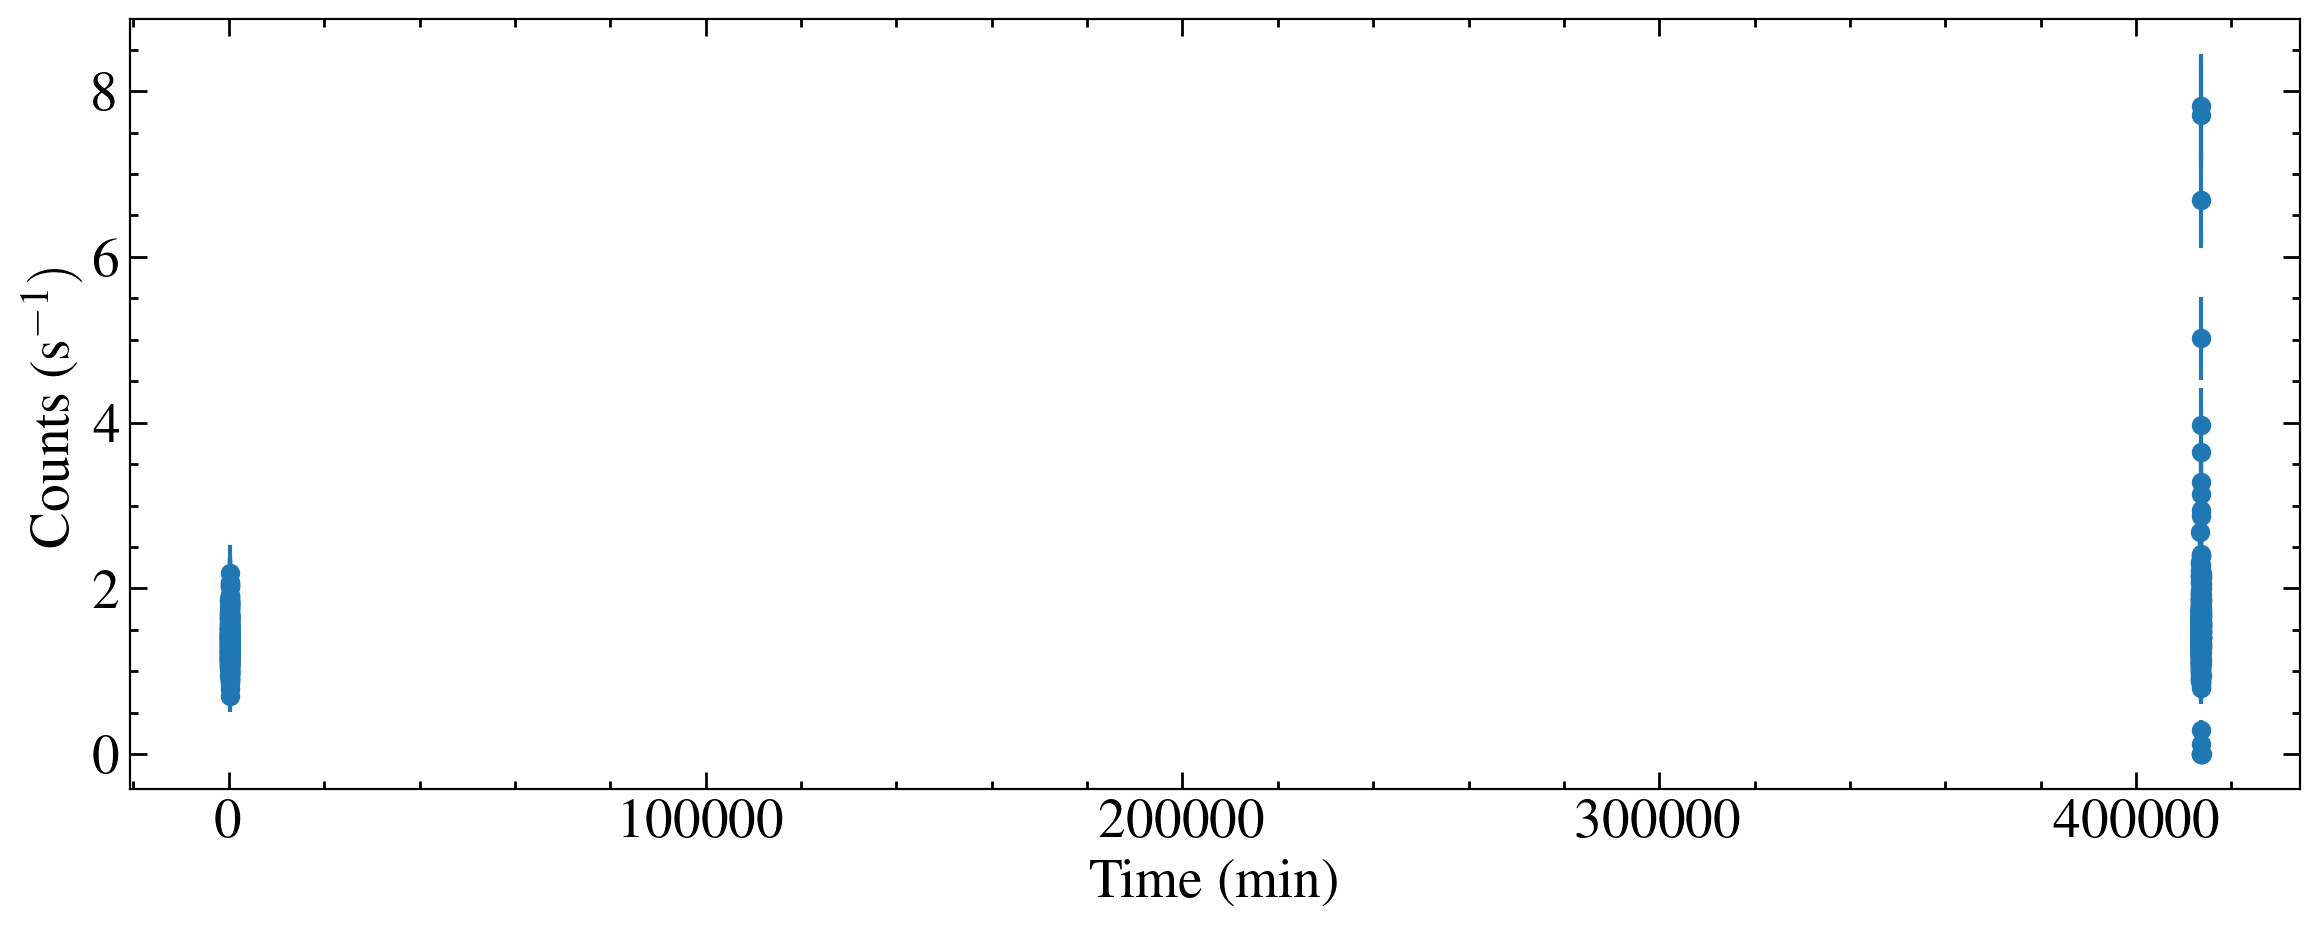

GJ699


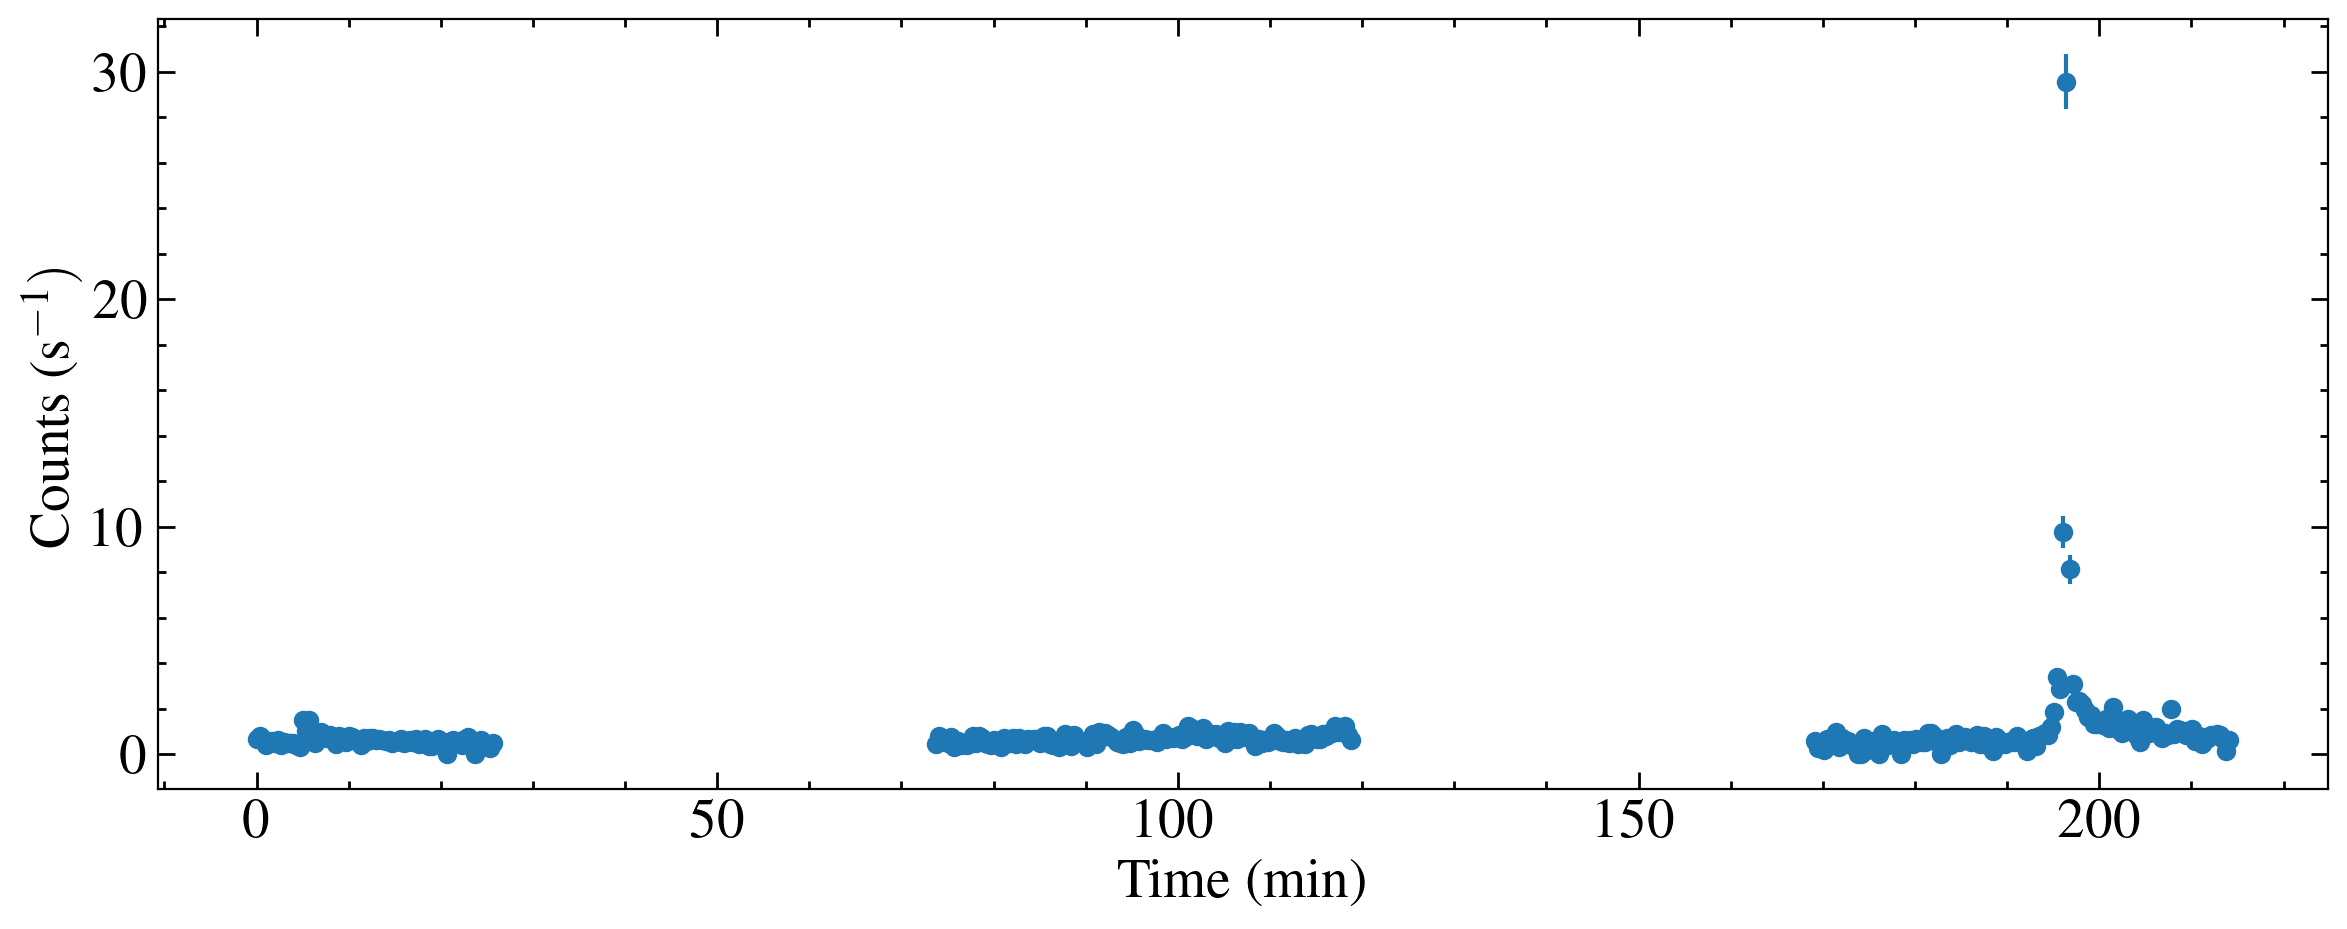

LHS-2686


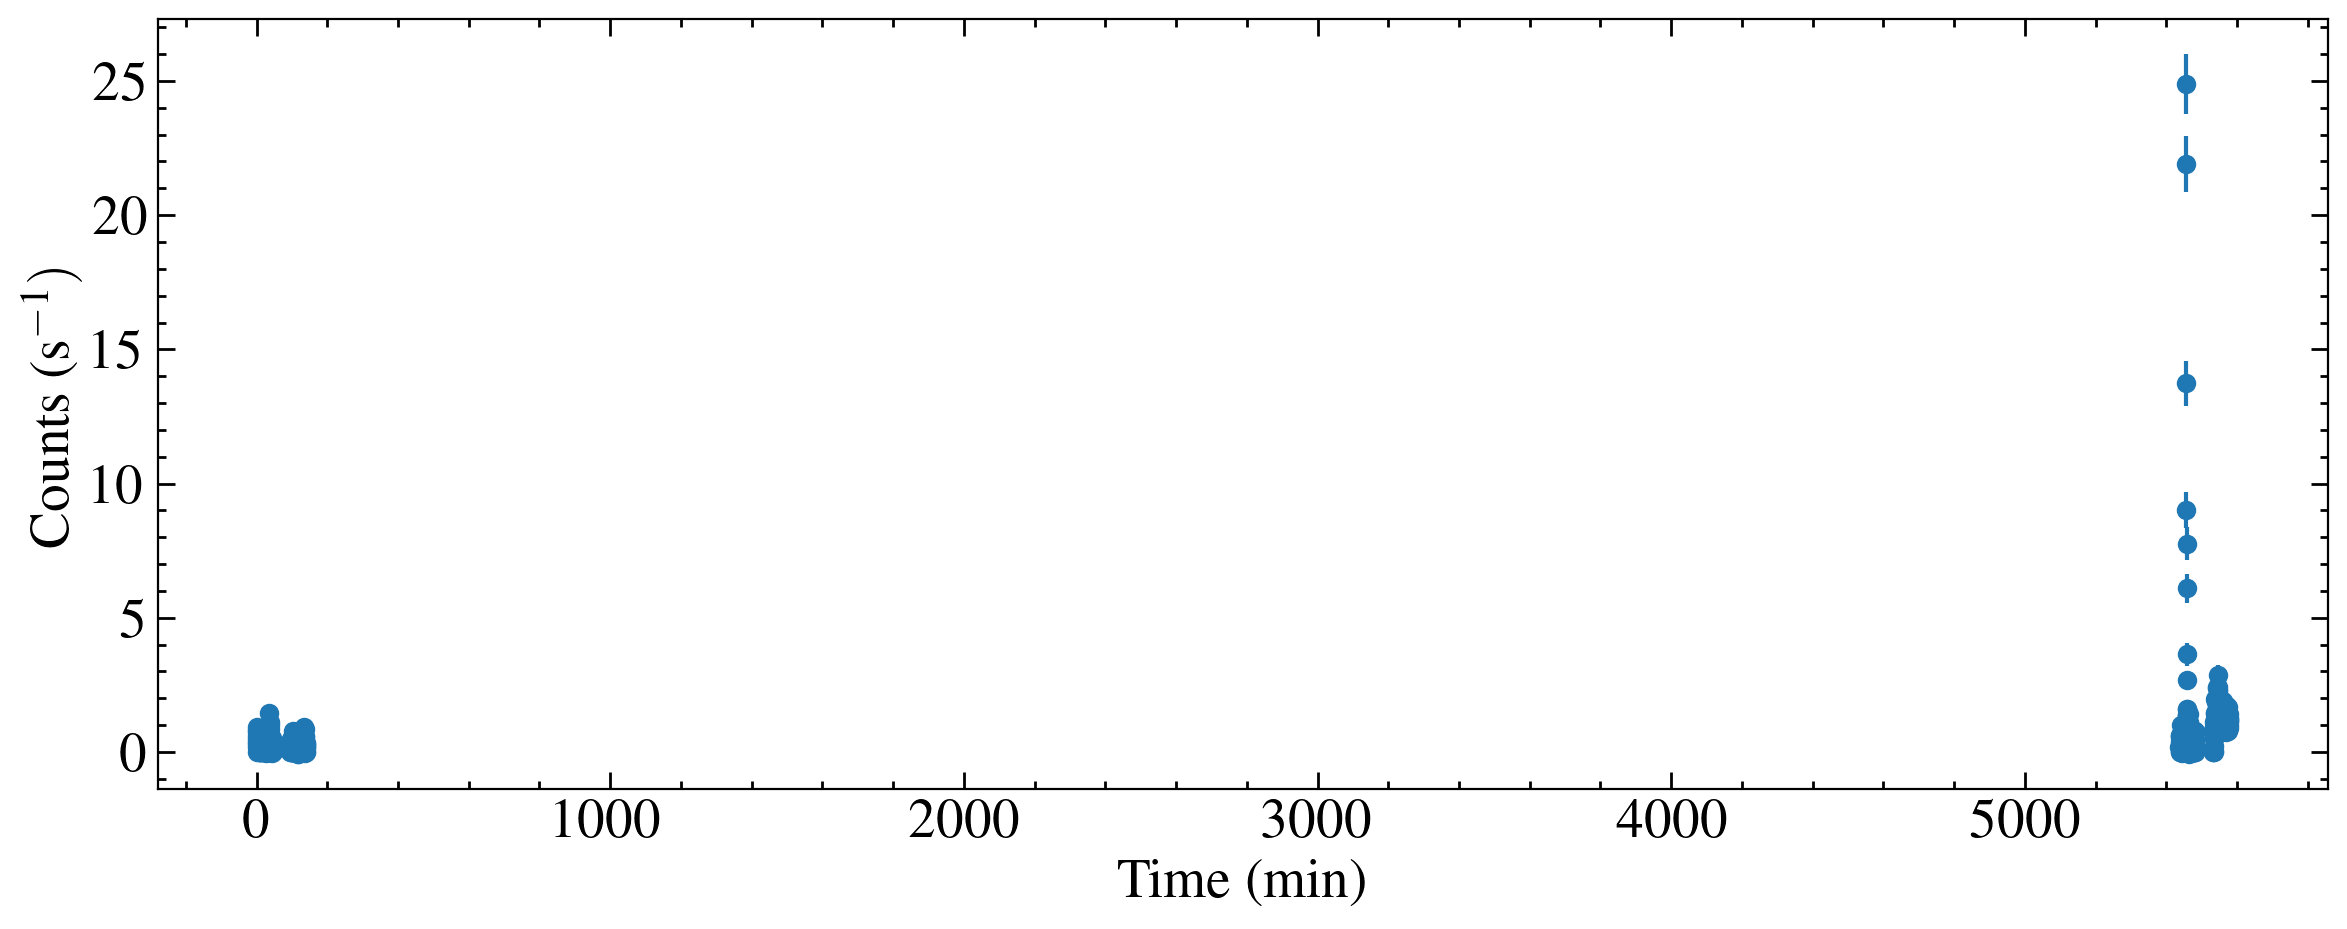

In [21]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff0 = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    diff1 = np.concatenate((diff, np.array([diff[-1]]))) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff0/2.
    w1 = w + diff1/2.
    return w0, w1

band = [1250, 1700]

for star in stars:
    print(star)
    fig, ax = plt.subplots()
    time = []
    flux = []
    error = []
    for x in new_x1ds:   
        hdul = fits.open(x)
        if hdul[0].header['TARGNAME'] == star: 
            for ext in hdul[1::]:
                data = ext.data[0]
                hdr = ext.header
                ti = (hdr['EXPSTART']+hdr['EXPEND'])/2 #work out the mid-point of the time bin and add it to the time array
                time.append(ti)
                w, f, e , dq = (data['WAVELENGTH'], data['NET'], data['NET_ERROR'], data['DQ'])
                #w, f, e , dq = (data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']) #uncomment this line for flux-calibrated light curves
                w0, w1 = wavelength_edges(w) 
                mask  = (w > band[0]) & (w < band[1]) & (dq == 0)
                w, w0, w1, f, e = w[mask], w0[mask], w1[mask], f[mask], e[mask]
                fi = np.sum(f*(w1-w0))
                # ei = (np.sum(e**2 * (w1-w0)**2))**0.5
                flux.append(fi)
                # error.append(ei)
                ei = ((fi*t_bin)**0.5)/t_bin # sqrt total counts 
                error.append(ei) #better approach for these low-signal spectra
                
                
        
        hdul.close()    
    time, flux, error = np.array(time), np.array(flux), np.array(error)
    args = np.argsort(time)
    time, flux, error = time[args], flux[args], error[args]
    t0 = time[0]
    tplot = ((time - t0)*u.d).to(u.min)
    # ax.errorbar(time-t0, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.errorbar(tplot, flux, yerr = error, marker='o', ls='none') #plot the light curve
    ax.set_ylabel('Counts (s$^{-1})$')
    # ax.set_xlabel('Time (MJD-{})'.format(t0))
    ax.set_xlabel('Time (min)')
    plt.show()

    savdat = Table([time*cds.MJD, flux/u.s, error/u.s], names=['MJD', 'COUNTS', 'COUNTS_ERROR'])
    savdat.write('{}{}_{}_{}s_lc.ecsv'.format(savepath, star, grating, t_bin), overwrite=True)
    
        # print(hdul[0].header['ROOTNAME'])
        # for ext in hdul[1::]: #spectra in every extension after the first
        #     data = ext.data[0]
        #     ax.step(data['WAVELENGTH'], data['FLUX'], where='mid', alpha=0.5)
        #     # plt.step(data['WAVELENGTH'], data['ERROR'], alpha =0.5, where='mid')
        #     ax.set_ylim(0, 1.1*max(data['FLUX']))
        #     # plt.show()
        # hdul.close()
        # plt.show()
        